# Evaluation Statistics

This notebook looks at the EvalStatistics over the the main evaluation round.

In [1]:
import os
from datetime import datetime
from collections import defaultdict
import numpy as np
import pandas as pd
import pingouin as pg

from Functions.st_import_merge_and_validate_final_evals import import_merge_and_validate_final_evals
from Functions.st_custom_prauc_rce_display import custom_prauc_rce_display
from Functions.repeated_loc import repeated_loc
from Functions.pp_remove_duplicates_and_inconsistencies import remove_duplicates_and_inconsistencies
from Functions.st_get_common_factor_combinations import get_common_factor_combinations
from Functions.pp_flatten_deflatten import deflatten_evals, flatten_evals
from Functions.st_loc_by_dict import loc_by_dict
from Functions.st_get_best_results import get_best_results

# Importing Evaluations and Getting An Overview

In [2]:
# If on the TU Wien's LBD cluster use yarn, otherwise use local
working_on_cluster = "adbs20" in os.path.abspath(os.getcwd())
ALL_ENGS = ["like", "reply", "retweet", "quote", "react"]
TARGET_COL = "target"  # column name in the flattened form describing whose values are individual tweet engagement goals (ignored if FLATTEN_RESULTS = False)
EVAL_COL = "evaluation"  # column name in the flattened form describing with an individual evaluation value (ignored if FLATTEN_RESULTS = False)
DEV_PREFIX = "dev-"
DATA_TO_BE_CONSIDERED = "combined-"  # can be None or "dev"- to only consider locally produced data, "" to only consider cluster data or "combined-" to consider both

# General setings
CALCULATE_STEPS = True # calculate inbetween steps - provides more transparent progress, but might slow down the run

# Evaluation names
ABSOLUTE_PATH_PREFIX  = "/home/adbs20/e01528091/Master/2020recsystwitter" if working_on_cluster else os.path.abspath(os.path.join("", os.pardir))  # https://prnt.sc/ZaFbM7LWTDbg
CLASSIFIER_NAMES = ["tree", "lr", "svc", "bayes", "forest", "GradientBoosting"]
FEATURES_NOTES = ["oracle_scaled", "scaled", "oracle_unscaled", "unscaled",]  # should be a subset values of dict <FEATURES_SELECTION_TO_FEATURES_NOTE_MAP> that represents the order in which the featuresets are to be processed; set to None to process all in the order given in <FEATURES_SELECTION_TO_FEATURES_NOTE_MAP>
TRAINED_ONS = ["itself", "train"]  # whether fitted on the corresponding train dataset instead of the same dataset
SORTING_ORDER = ["trained_on", "algorithm", "note", "feature_selection", "evaluated_on"]

# Evals settings
FINAL_EVALS_FOLDER = os.path.join(ABSOLUTE_PATH_PREFIX, "Results", "Eval", "Final")
FINAL_PRAUC_FILENAME = "final-prauc.csv"
FINAL_RCE_FILENAME = "final-rce.csv"
EVALS_STATS_FOLDER = os.path.join(ABSOLUTE_PATH_PREFIX, "Results", "Statistics")
EVALS_VALUE_COUNTS_FOLDER = os.path.join(EVALS_STATS_FOLDER, "EvalValueCounts")
EVALS_VALUE_BEST_RESULTS = os.path.join(EVALS_STATS_FOLDER, "BestResults")
EVALS_VALUE_DESCRIPTIVE_STATISTICS_FOLDER = os.path.join(EVALS_STATS_FOLDER, "EvalDescriptiveStatistics") 

First we import the evaluations in the easier-to-read deflattened form.

Evals did not have to be (de)flattened.
(De)flattenig needed: for flatten=True, flatten_statuses={'prauc_evals': False, 'rce_evals': False}
Flattened dict_keys(['prauc_evals', 'rce_evals'])
Shapes of PRAUC/RCE at start: (72650, 7)/(74375, 7), 
after removing duplicates: (59990, 7)/(61595, 7) (kept best), 
and after removing inconsistencies=(59690, 7)/(59690, 7).
(De)flattenig needed: for flatten=False, flatten_statuses={'prauc_evals': True, 'rce_evals': True}
Deflattened dict_keys(['prauc_evals', 'rce_evals'])
____16.05.2023 20:48:44____

Read final evals for final_deflattened_PRAUC of shape (11939, 16) for data_to_be_cosidered=combined-.
final_deflattened_PRAUC shape: (11939, 16), of that non-nans for like=11928; reply=11710; retweet=11577; quote=11544; react=11346.
Present algorithms in final_deflattened_PRAUC


like  reply  retweet  quote  react
algorithm                                           
bayes             4152   4131     4131   4131   4129
forest            3769   3721     3710   3699   3630
tree              2060   2012     2004   1994   1873
GradientBoosting  1700   1675     1628   1628   1628
lr                 174    114       74     74     74
svc                 73     57       30     18     12

Present notes in final_deflattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
note                                              
scaled         11297  11080    10947  10914  10718
oracle_scaled    631    630      630    630    628

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present feature_selections in final_deflattened_PRAUC


like  reply  retweet  quote  react
feature_selection                                    
all                4596   4556     4521   4519   4333
top_10             1985   1965     1939   1930   1930
top_25             1813   1792     1767   1758   1755
top_5              1800   1697     1668   1658   1652
top_50             1734   1700     1682   1679   1676

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_deflattened_PRAUC


like  reply  retweet  quote  react
trained_on                                                           
train_EU_sample_1pct               1221   1221     1221   1221   1220
train_EU_sample_10pct               900    899      900    900    840
train_EWU_sample_2pct               512    512      512    512    512
train_EU_sample_2pct                512    512      512    512    512
train_EWU_sample_1pct               505    477      477    477    477
train_inter_EWU+EU_sample_1pct      497    497      497    497    497
train_random_sample_1pct            496    468      429    426    425
train_inter_EWU+EU_sample_2pct      455    455      455    455    455
test_random_sample_1pct             420    404      364    355    349
train_random_sample_2pct            413    413      413    413    413
train_EU_sample_5pct                320    320      320    320    320
train_EWU_sample_5pct               320    320      320    320    320
train_tweet_sample_2pct             308    308      308    308    308
test_random_sample_2pct             273    271      272    272    272
train_tweet_sample_1pct             263    263      263    263    263
test_inter_EWU+EU_sample_1pct       261    260      260    260    260
train_EWU_sample_10pct              241    240      240    240    240
train_inter_EWU+EU_sample_10pct     240    234      224    214     84
test_EU_sample_2pct                 235    233      232    233    233
test_EWU_sample_2pct                235    234      234    234    234
test_EWU_sample_1pct                231    231      231    231    231
test_EU_sample_1pct                 229    229      230    230    230
test_inter_EWU+EU_sample_2pct       212    210      210    210    210
val+test_random_sample_1pct         172    163      144    144    144
train_random_sample_5pct            158    158      158    158    158
val+test_EU_sample_1pct             154    154      154    154    155
test_tweet_sample_2pct              150    148      148    148    148
test_tweet_sample_1pct              140    139      140    140    140
val_random_sample_1pct              136    129      120    120    120
val+test_EU_sample_2pct             135    133      133    133    133
val+test_random_sample_2pct         108    107      107    107    107
val+test_inter_EWU+EU_sample_2pct    93     91       91     91     91
val+test_inter_EWU+EU_sample_1pct    88     87       87     87     87
train_tweet_sample_5pct              80     80       80     80     80
train_random_sample_10pct            80     68       61     61     61
train_inter_EWU+EU_sample_5pct       80     80       80     80     80
val_inter_EWU+EU_sample_2pct         78     76       76     76     76
val_inter_EWU+EU_sample_1pct         74     74       73     73     73
val_random_sample_2pct               63     62       62     62     62
train_tweet_sample_10pct             60     43       33     20     20
val_EU_sample_2pct                   60     59       59     59     59
val_EWU_sample_2pct                  60     59       59     59     59
val+test_EWU_sample_2pct             60     59       59     59     59
val+test_EWU_sample_1pct             57     57       57     58     58
val_EWU_sample_1pct                  58     58       58     58     58
val_EU_sample_1pct                   57     57       57     57     57
val+test_tweet_sample_2pct           45     43       43     43     43
val+test_tweet_sample_1pct           43     42       42     42     42
val_EWU_sample_5pct                  15     12       12     12     12
val_random_sample_10pct              15     12       12     12     11
val_inter_EWU+EU_sample_5pct         15     12       12     12     12
val_random_sample_5pct               15     12       12     12     12
val_EU_sample_5pct                   15     12       12     12     12
val_tweet_sample_1pct                15     14       14     14     14
val_tweet_sample_2pct                15     13       13     13     13
val_tweet_sample_5pct                15     1

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_deflattened_PRAUC


like  reply  retweet  quote  react
evaluated_on                                                          
val_random_sample_1pct               478    458      446    446    441
val+test_random_sample_1pct          472    456      440    440    435
test_random_sample_1pct              450    433      426    426    421
val_tweet_sample_1pct                427    426      426    426    423
val_inter_EWU+EU_sample_1pct         425    425      424    424    421
val+test_tweet_sample_1pct           425    424      424    424    421
val+test_EWU_sample_1pct             423    423      423    424    421
val+test_inter_EWU+EU_sample_1pct    424    423      423    423    420
val_EWU_sample_1pct                  424    424      424    424    421
val_EU_sample_1pct                   420    420      420    420    417
test_tweet_sample_1pct               417    416      417    417    414
test_inter_EWU+EU_sample_1pct        417    416      416    416    413
test_EWU_sample_1pct                 417    417      417    417    414
val+test_EU_sample_1pct              412    412      412    412    410
test_EU_sample_1pct                  412    412      413    413    410
val_random_sample_2pct               213    202      179    176    173
test_random_sample_2pct              213    201      179    176    173
val+test_random_sample_2pct          213    202      179    176    173
val+test_tweet_sample_2pct           127    125      125    125    122
val_inter_EWU+EU_sample_2pct         127    125      125    125    122
val_tweet_sample_2pct                127    125      125    125    122
val+test_inter_EWU+EU_sample_2pct    127    125      125    125    122
test_tweet_sample_2pct               127    125      125    125    122
test_inter_EWU+EU_sample_2pct        126    124      124    124    121
val_EU_sample_2pct                   123    122      122    122    119
val_EWU_sample_2pct                  123    122      122    122    119
val+test_EWU_sample_2pct             123    122      122    122    119
val+test_EU_sample_2pct              123    121      121    121    118
test_EWU_sample_2pct                 118    117      117    117    114
test_EU_sample_2pct                  118    116      115    116    113
test_tweet_sample_5pct               101     98       98     98     95
val+test_tweet_sample_5pct           101     98       98     98     95
val+test_random_sample_5pct          101     98       98     98     95
val+test_inter_EWU+EU_sample_5pct    101     97       97     97     95
val_random_sample_5pct               101     98       98     98     95
val_tweet_sample_5pct                101     98       98     98     95
val_inter_EWU+EU_sample_5pct         101     98       98     98     95
test_random_sample_5pct              101     98       98     98     95
test_inter_EWU+EU_sample_5pct        101     98       98     98     95
val_random_sample_10pct              101     94       93     93     89
test_random_sample_10pct             101     95       92     92     89
val+test_random_sample_10pct          98     94       91     91     87
val+test_EU_sample_5pct               97     94       94     94     91
val_EWU_sample_5pct                   97     94       94     94     91
val_EU_sample_5pct                    97     94       94     94     91
test_EU_sample_5pct                   97     94       94     94     91
val+test_EWU_sample_5pct              97     94       94     94     91
test_EWU_sample_5pct                  97     94       94     94     91
test_EWU_sample_10pct                 88     85       85     85     83
val_EWU_sample_10pct                  88     86       86     86     83
val+test_EWU_sample_10pct             86     84       84     84     80
val_tweet_sample_10pct                81     75       71     71     68
test_tweet_sample_10pct               81     78       75     71     68
val+test_tweet_sample_10pct           81     81       80     71     68
val+test_inter_EWU+EU_sample_10pct    78     78       77    

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_deflattened_PRAUC


like  reply  retweet  quote  react
to_dataset                                    
train       7661   7568     7503   7477   7285
test        2491   2442     2403   2395   2390
val+test    1055   1015      996    997    997
val          721    685      675    675    674

Present to_techniques in final_deflattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
to_technique                                    
EU            3883   3865     3866   3867   3807
random        2406   2313     2199   2187   2178
EWU           2352   2304     2304   2305   2305
inter_EWU+EU  2123   2099     2088   2078   1949
tweet         1164   1129     1120   1107   1107

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_percents in final_deflattened_PRAUC


like  reply  retweet  quote  react
to_percent                                    
1pct        5117   5024     4918   4907   4900
2pct        4022   3998     3998   3999   3999
10pct       1606   1551     1524   1501   1309
5pct        1183   1137     1137   1137   1138

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_datasets in final_deflattened_PRAUC


like  reply  retweet  quote  react
eo_dataset                                    
val         3869   3799     3751   3746   3683
val+test    3846   3786     3743   3726   3661
test        3797   3731     3695   3686   3620
train        416    394      388    386    382

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_techniques in final_deflattened_PRAUC


like  reply  retweet  quote  react
eo_technique                                    
random        2745   2628     2514   2502   2457
tweet         2271   2236     2227   2214   2178
inter_EWU+EU  2264   2240     2229   2219   2180
EWU           2262   2238     2238   2239   2203
EU            2191   2173     2174   2175   2142
full           195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_deflattened_PRAUC


like  reply  retweet  quote  react
eo_percent                                    
1pct        6572   6509     6472   6470   6418
2pct        2234   2180     2111   2103   2058
5pct        1591   1545     1545   1545   1501
10pct       1336   1281     1254   1231   1183
full         195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent      like     reply   retweet     quote     react  
0      10pct  0.724162  0.512919  0.351565  0.503487  0.771817  
1      10pct  0.694620  0.512919  0.549752  0.503487  0.743221  
2      10pct  0.713781  0.512919  0.342300  0.503487  0.763743  
3      10pct  0.682006       NaN       NaN       NaN       NaN  
4      10pct  0.716546  0.512919  0.549752  0.503487  0.765034

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent      like     reply   retweet     quote     react  
0      10pct  0.724162  0.512919  0.351565  0.503487  0.771817  
1      10pct  0.694620  0.512919  0.549752  0.503487  0.743221  
2      10pct  0.713781  0.512919  0.342300  0.503487  0.763743  
3      10pct  0.682006       NaN       NaN       NaN       NaN  
4      10pct  0.716546  0.512919  0.549752  0.503487  0.765034



____16.05.2023 20:48:47____

Read final evals for final_deflattened_RCE of shape (11939, 16) for data_to_be_cosidered=combined-.
final_deflattened_RCE shape: (11939, 16), of that non-nans for like=11928; reply=11710; retweet=11577; quote=11544; react=11346.
Present algorithms in final_deflattened_RCE


like  reply  retweet  quote  react
algorithm                                           
bayes             4152   4131     4131   4131   4129
forest            3769   3721     3710   3699   3630
tree              2060   2012     2004   1994   1873
GradientBoosting  1700   1675     1628   1628   1628
lr                 174    114       74     74     74
svc                 73     57       30     18     12

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present notes in final_deflattened_RCE


like  reply  retweet  quote  react
note                                              
scaled         11297  11080    10947  10914  10718
oracle_scaled    631    630      630    630    628

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present feature_selections in final_deflattened_RCE


like  reply  retweet  quote  react
feature_selection                                    
all                4596   4556     4521   4519   4333
top_10             1985   1965     1939   1930   1930
top_25             1813   1792     1767   1758   1755
top_5              1800   1697     1668   1658   1652
top_50             1734   1700     1682   1679   1676

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_deflattened_RCE


like  reply  retweet  quote  react
trained_on                                                           
train_EU_sample_1pct               1221   1221     1221   1221   1220
train_EU_sample_10pct               900    899      900    900    840
train_EWU_sample_2pct               512    512      512    512    512
train_EU_sample_2pct                512    512      512    512    512
train_EWU_sample_1pct               505    477      477    477    477
train_inter_EWU+EU_sample_1pct      497    497      497    497    497
train_random_sample_1pct            496    468      429    426    425
train_inter_EWU+EU_sample_2pct      455    455      455    455    455
test_random_sample_1pct             420    404      364    355    349
train_random_sample_2pct            413    413      413    413    413
train_EU_sample_5pct                320    320      320    320    320
train_EWU_sample_5pct               320    320      320    320    320
train_tweet_sample_2pct             308    308      308    308    308
test_random_sample_2pct             273    271      272    272    272
train_tweet_sample_1pct             263    263      263    263    263
test_inter_EWU+EU_sample_1pct       261    260      260    260    260
train_EWU_sample_10pct              241    240      240    240    240
train_inter_EWU+EU_sample_10pct     240    234      224    214     84
test_EU_sample_2pct                 235    233      232    233    233
test_EWU_sample_2pct                235    234      234    234    234
test_EWU_sample_1pct                231    231      231    231    231
test_EU_sample_1pct                 229    229      230    230    230
test_inter_EWU+EU_sample_2pct       212    210      210    210    210
val+test_random_sample_1pct         172    163      144    144    144
train_random_sample_5pct            158    158      158    158    158
val+test_EU_sample_1pct             154    154      154    154    155
test_tweet_sample_2pct              150    148      148    148    148
test_tweet_sample_1pct              140    139      140    140    140
val_random_sample_1pct              136    129      120    120    120
val+test_EU_sample_2pct             135    133      133    133    133
val+test_random_sample_2pct         108    107      107    107    107
val+test_inter_EWU+EU_sample_2pct    93     91       91     91     91
val+test_inter_EWU+EU_sample_1pct    88     87       87     87     87
train_tweet_sample_5pct              80     80       80     80     80
train_random_sample_10pct            80     68       61     61     61
train_inter_EWU+EU_sample_5pct       80     80       80     80     80
val_inter_EWU+EU_sample_2pct         78     76       76     76     76
val_inter_EWU+EU_sample_1pct         74     74       73     73     73
val_random_sample_2pct               63     62       62     62     62
train_tweet_sample_10pct             60     43       33     20     20
val_EU_sample_2pct                   60     59       59     59     59
val_EWU_sample_2pct                  60     59       59     59     59
val+test_EWU_sample_2pct             60     59       59     59     59
val+test_EWU_sample_1pct             57     57       57     58     58
val_EWU_sample_1pct                  58     58       58     58     58
val_EU_sample_1pct                   57     57       57     57     57
val+test_tweet_sample_2pct           45     43       43     43     43
val+test_tweet_sample_1pct           43     42       42     42     42
val_EWU_sample_5pct                  15     12       12     12     12
val_random_sample_10pct              15     12       12     12     11
val_inter_EWU+EU_sample_5pct         15     12       12     12     12
val_random_sample_5pct               15     12       12     12     12
val_EU_sample_5pct                   15     12       12     12     12
val_tweet_sample_1pct                15     14       14     14     14
val_tweet_sample_2pct                15     13       13     13     13
val_tweet_sample_5pct                15     1

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_deflattened_RCE


like  reply  retweet  quote  react
evaluated_on                                                          
val_random_sample_1pct               478    458      446    446    441
val+test_random_sample_1pct          472    456      440    440    435
test_random_sample_1pct              450    433      426    426    421
val_tweet_sample_1pct                427    426      426    426    423
val_inter_EWU+EU_sample_1pct         425    425      424    424    421
val+test_tweet_sample_1pct           425    424      424    424    421
val+test_EWU_sample_1pct             423    423      423    424    421
val+test_inter_EWU+EU_sample_1pct    424    423      423    423    420
val_EWU_sample_1pct                  424    424      424    424    421
val_EU_sample_1pct                   420    420      420    420    417
test_tweet_sample_1pct               417    416      417    417    414
test_inter_EWU+EU_sample_1pct        417    416      416    416    413
test_EWU_sample_1pct                 417    417      417    417    414
val+test_EU_sample_1pct              412    412      412    412    410
test_EU_sample_1pct                  412    412      413    413    410
val_random_sample_2pct               213    202      179    176    173
test_random_sample_2pct              213    201      179    176    173
val+test_random_sample_2pct          213    202      179    176    173
val+test_tweet_sample_2pct           127    125      125    125    122
val_inter_EWU+EU_sample_2pct         127    125      125    125    122
val_tweet_sample_2pct                127    125      125    125    122
val+test_inter_EWU+EU_sample_2pct    127    125      125    125    122
test_tweet_sample_2pct               127    125      125    125    122
test_inter_EWU+EU_sample_2pct        126    124      124    124    121
val_EU_sample_2pct                   123    122      122    122    119
val_EWU_sample_2pct                  123    122      122    122    119
val+test_EWU_sample_2pct             123    122      122    122    119
val+test_EU_sample_2pct              123    121      121    121    118
test_EWU_sample_2pct                 118    117      117    117    114
test_EU_sample_2pct                  118    116      115    116    113
test_tweet_sample_5pct               101     98       98     98     95
val+test_tweet_sample_5pct           101     98       98     98     95
val+test_random_sample_5pct          101     98       98     98     95
val+test_inter_EWU+EU_sample_5pct    101     97       97     97     95
val_random_sample_5pct               101     98       98     98     95
val_tweet_sample_5pct                101     98       98     98     95
val_inter_EWU+EU_sample_5pct         101     98       98     98     95
test_random_sample_5pct              101     98       98     98     95
test_inter_EWU+EU_sample_5pct        101     98       98     98     95
val_random_sample_10pct              101     94       93     93     89
test_random_sample_10pct             101     95       92     92     89
val+test_random_sample_10pct          98     94       91     91     87
val+test_EU_sample_5pct               97     94       94     94     91
val_EWU_sample_5pct                   97     94       94     94     91
val_EU_sample_5pct                    97     94       94     94     91
test_EU_sample_5pct                   97     94       94     94     91
val+test_EWU_sample_5pct              97     94       94     94     91
test_EWU_sample_5pct                  97     94       94     94     91
test_EWU_sample_10pct                 88     85       85     85     83
val_EWU_sample_10pct                  88     86       86     86     83
val+test_EWU_sample_10pct             86     84       84     84     80
val_tweet_sample_10pct                81     75       71     71     68
test_tweet_sample_10pct               81     78       75     71     68
val+test_tweet_sample_10pct           81     81       80     71     68
val+test_inter_EWU+EU_sample_10pct    78     78       77    

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_deflattened_RCE


like  reply  retweet  quote  react
to_dataset                                    
train       7661   7568     7503   7477   7285
test        2491   2442     2403   2395   2390
val+test    1055   1015      996    997    997
val          721    685      675    675    674

Present to_techniques in final_deflattened_RCE


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
to_technique                                    
EU            3883   3865     3866   3867   3807
random        2406   2313     2199   2187   2178
EWU           2352   2304     2304   2305   2305
inter_EWU+EU  2123   2099     2088   2078   1949
tweet         1164   1129     1120   1107   1107

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_percents in final_deflattened_RCE


like  reply  retweet  quote  react
to_percent                                    
1pct        5117   5024     4918   4907   4900
2pct        4022   3998     3998   3999   3999
10pct       1606   1551     1524   1501   1309
5pct        1183   1137     1137   1137   1138

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_datasets in final_deflattened_RCE


like  reply  retweet  quote  react
eo_dataset                                    
val         3869   3799     3751   3746   3683
val+test    3846   3786     3743   3726   3661
test        3797   3731     3695   3686   3620
train        416    394      388    386    382

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",
C:\Users\Jovan\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Present eo_techniques in final_deflattened_RCE


like  reply  retweet  quote  react
eo_technique                                    
random        2745   2628     2514   2502   2457
tweet         2271   2236     2227   2214   2178
inter_EWU+EU  2264   2240     2229   2219   2180
EWU           2262   2238     2238   2239   2203
EU            2191   2173     2174   2175   2142
full           195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_deflattened_RCE


like  reply  retweet  quote  react
eo_percent                                    
1pct        6572   6509     6472   6470   6418
2pct        2234   2180     2111   2103   2058
5pct        1591   1545     1545   1545   1501
10pct       1336   1281     1254   1231   1183
full         195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent         like       reply     retweet       quote        react  
0      10pct -1352.785472 -643.912756 -949.838046 -479.297808 -1345.101797  
1      10pct -1548.416171 -643.912756 -960.750619 -479.297808 -1527.608112  
2      10pct -1413.243864 -643.912756 -953.166170 -479.297808 -1392.067281  
3      10pct -1638.160571         NaN         NaN         NaN          NaN  
4      10pct -1403.385682 -643.912756 -945.354071 -479.297808 -1384.992853

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent         like       reply     retweet       quote        react  
0      10pct -1352.785472 -643.912756 -949.838046 -479.297808 -1345.101797  
1      10pct -1548.416171 -643.912756 -960.750619 -479.297808 -1527.608112  
2      10pct -1413.243864 -643.912756 -953.166170 -479.297808 -1392.067281  
3      10pct -1638.160571         NaN         NaN         NaN          NaN  
4      10pct -1403.385682 -643.912756 -945.354071 -479.297808 -1384.992853

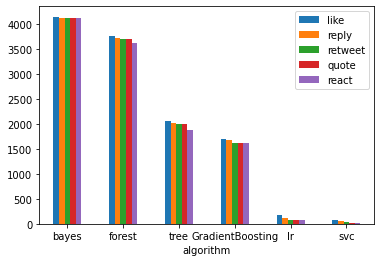

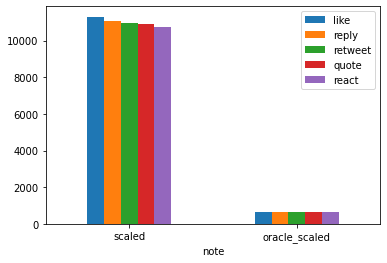

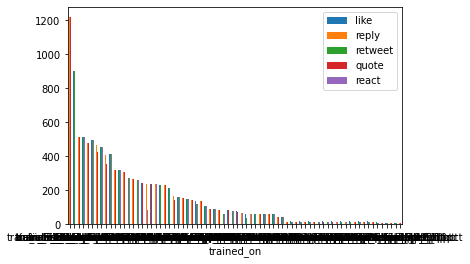

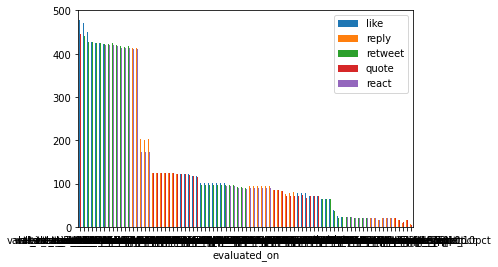

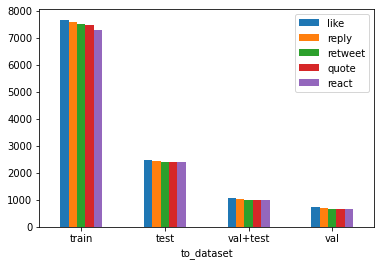

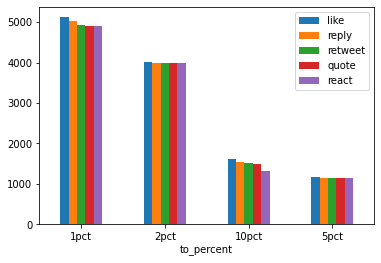

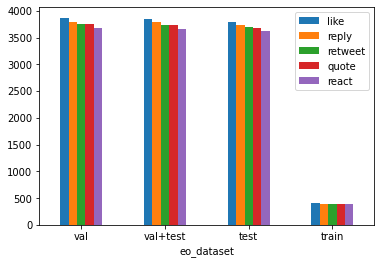

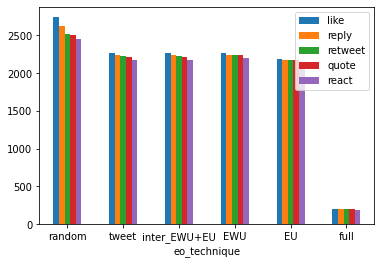

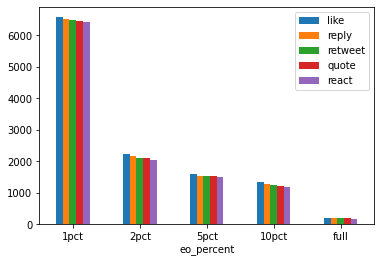

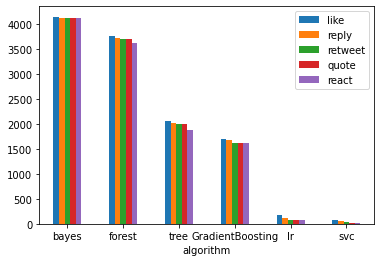

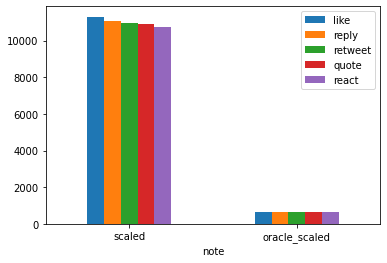

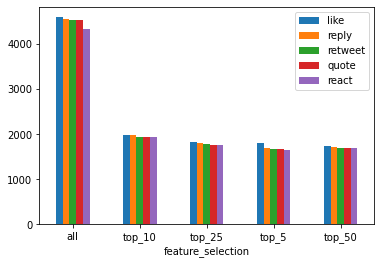

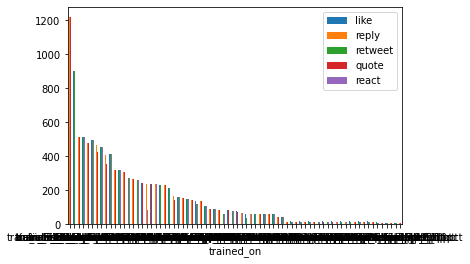

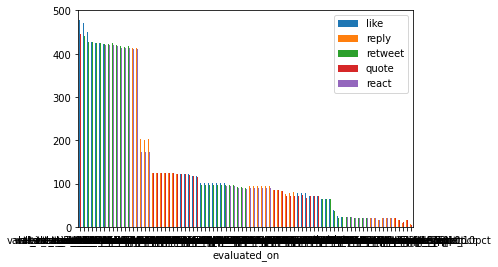

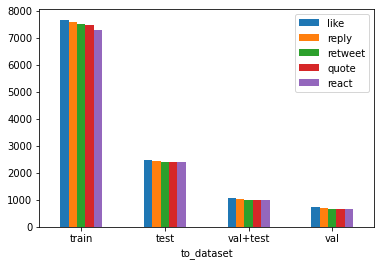

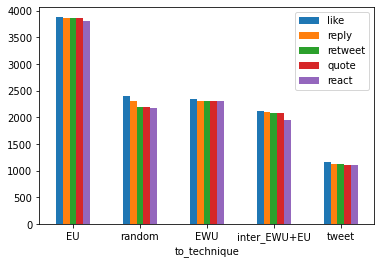

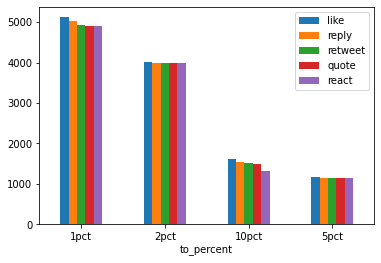

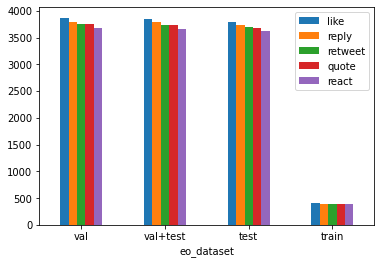

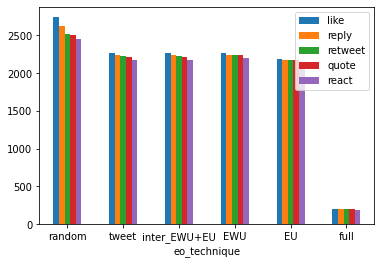

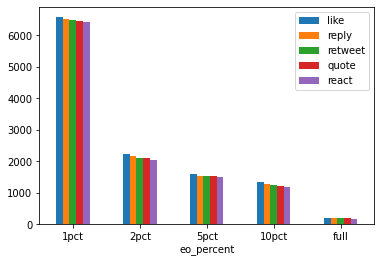

In [3]:
deflattened_prauc, deflattened_rce = import_merge_and_validate_final_evals(data_to_be_cosidered=DATA_TO_BE_CONSIDERED,
                                      final_evals_folder=FINAL_EVALS_FOLDER, 
                                      final_prauc_filename=FINAL_PRAUC_FILENAME, 
                                      final_rce_filename=FINAL_RCE_FILENAME, 
                                      dev_prefix=DEV_PREFIX,
                                      all_engs=ALL_ENGS, 
                                      eval_col=EVAL_COL, 
                                      flatten=False,
                                      sorting_order=SORTING_ORDER,
                                      keep="best",
                                      print_progress=CALCULATE_STEPS)

custom_prauc_rce_display(deflattened_prauc, 
                         deflattened_rce, 
                         df_name="final_deflattened",
                         export_path=EVALS_VALUE_COUNTS_FOLDER,
                         data_to_be_cosidered=DATA_TO_BE_CONSIDERED, 
                         flatten=False, 
                         print_progress=CALCULATE_STEPS)

Let us now see how many of these rows have no NaN value, that is we have all four reaction types.


Evals did not have to be (de)flattened.
(De)flattenig needed: for flatten=True, flatten_statuses={'prauc_evals': False, 'rce_evals': False}
Flattened dict_keys(['prauc_evals', 'rce_evals'])
Shapes of PRAUC/RCE at start: (72650, 7)/(74375, 7), 
after removing duplicates: (59990, 7)/(61595, 7) (kept best), 
and after removing inconsistencies=(59690, 7)/(59690, 7).
(De)flattenig needed: for flatten=False, flatten_statuses={'prauc_evals': True, 'rce_evals': True}
Deflattened dict_keys(['prauc_evals', 'rce_evals'])
____16.05.2023 20:49:10____

Read final evals for final_deflattened_nonan_PRAUC of shape (11939, 16) for data_to_be_cosidered=combined-.
final_deflattened_nonan_PRAUC shape: (11939, 16), of that non-nans for like=11928; reply=11710; retweet=11577; quote=11544; react=11346.
Present algorithms in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
algorithm                                           
bayes             4152   4131     4131   4131   4129
forest            3769   3721     3710   3699   3630
tree              2060   2012     2004   1994   1873
GradientBoosting  1700   1675     1628   1628   1628
lr                 174    114       74     74     74
svc                 73     57       30     18     12

Present notes in final_deflattened_nonan_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
note                                              
scaled         11297  11080    10947  10914  10718
oracle_scaled    631    630      630    630    628

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present feature_selections in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
feature_selection                                    
all                4596   4556     4521   4519   4333
top_10             1985   1965     1939   1930   1930
top_25             1813   1792     1767   1758   1755
top_5              1800   1697     1668   1658   1652
top_50             1734   1700     1682   1679   1676

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
trained_on                                                           
train_EU_sample_1pct               1221   1221     1221   1221   1220
train_EU_sample_10pct               900    899      900    900    840
train_EWU_sample_2pct               512    512      512    512    512
train_EU_sample_2pct                512    512      512    512    512
train_EWU_sample_1pct               505    477      477    477    477
train_inter_EWU+EU_sample_1pct      497    497      497    497    497
train_random_sample_1pct            496    468      429    426    425
train_inter_EWU+EU_sample_2pct      455    455      455    455    455
test_random_sample_1pct             420    404      364    355    349
train_random_sample_2pct            413    413      413    413    413
train_EU_sample_5pct                320    320      320    320    320
train_EWU_sample_5pct               320    320      320    320    320
train_tweet_sample_2pct             308    308      308    308    308
test_random_sample_2pct             273    271      272    272    272
train_tweet_sample_1pct             263    263      263    263    263
test_inter_EWU+EU_sample_1pct       261    260      260    260    260
train_EWU_sample_10pct              241    240      240    240    240
train_inter_EWU+EU_sample_10pct     240    234      224    214     84
test_EU_sample_2pct                 235    233      232    233    233
test_EWU_sample_2pct                235    234      234    234    234
test_EWU_sample_1pct                231    231      231    231    231
test_EU_sample_1pct                 229    229      230    230    230
test_inter_EWU+EU_sample_2pct       212    210      210    210    210
val+test_random_sample_1pct         172    163      144    144    144
train_random_sample_5pct            158    158      158    158    158
val+test_EU_sample_1pct             154    154      154    154    155
test_tweet_sample_2pct              150    148      148    148    148
test_tweet_sample_1pct              140    139      140    140    140
val_random_sample_1pct              136    129      120    120    120
val+test_EU_sample_2pct             135    133      133    133    133
val+test_random_sample_2pct         108    107      107    107    107
val+test_inter_EWU+EU_sample_2pct    93     91       91     91     91
val+test_inter_EWU+EU_sample_1pct    88     87       87     87     87
train_tweet_sample_5pct              80     80       80     80     80
train_random_sample_10pct            80     68       61     61     61
train_inter_EWU+EU_sample_5pct       80     80       80     80     80
val_inter_EWU+EU_sample_2pct         78     76       76     76     76
val_inter_EWU+EU_sample_1pct         74     74       73     73     73
val_random_sample_2pct               63     62       62     62     62
train_tweet_sample_10pct             60     43       33     20     20
val_EU_sample_2pct                   60     59       59     59     59
val_EWU_sample_2pct                  60     59       59     59     59
val+test_EWU_sample_2pct             60     59       59     59     59
val+test_EWU_sample_1pct             57     57       57     58     58
val_EWU_sample_1pct                  58     58       58     58     58
val_EU_sample_1pct                   57     57       57     57     57
val+test_tweet_sample_2pct           45     43       43     43     43
val+test_tweet_sample_1pct           43     42       42     42     42
val_EWU_sample_5pct                  15     12       12     12     12
val_random_sample_10pct              15     12       12     12     11
val_inter_EWU+EU_sample_5pct         15     12       12     12     12
val_random_sample_5pct               15     12       12     12     12
val_EU_sample_5pct                   15     12       12     12     12
val_tweet_sample_1pct                15     14       14     14     14
val_tweet_sample_2pct                15     13       13     13     13
val_tweet_sample_5pct                15     1

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
evaluated_on                                                          
val_random_sample_1pct               478    458      446    446    441
val+test_random_sample_1pct          472    456      440    440    435
test_random_sample_1pct              450    433      426    426    421
val_tweet_sample_1pct                427    426      426    426    423
val_inter_EWU+EU_sample_1pct         425    425      424    424    421
val+test_tweet_sample_1pct           425    424      424    424    421
val+test_EWU_sample_1pct             423    423      423    424    421
val+test_inter_EWU+EU_sample_1pct    424    423      423    423    420
val_EWU_sample_1pct                  424    424      424    424    421
val_EU_sample_1pct                   420    420      420    420    417
test_tweet_sample_1pct               417    416      417    417    414
test_inter_EWU+EU_sample_1pct        417    416      416    416    413
test_EWU_sample_1pct                 417    417      417    417    414
val+test_EU_sample_1pct              412    412      412    412    410
test_EU_sample_1pct                  412    412      413    413    410
val_random_sample_2pct               213    202      179    176    173
test_random_sample_2pct              213    201      179    176    173
val+test_random_sample_2pct          213    202      179    176    173
val+test_tweet_sample_2pct           127    125      125    125    122
val_inter_EWU+EU_sample_2pct         127    125      125    125    122
val_tweet_sample_2pct                127    125      125    125    122
val+test_inter_EWU+EU_sample_2pct    127    125      125    125    122
test_tweet_sample_2pct               127    125      125    125    122
test_inter_EWU+EU_sample_2pct        126    124      124    124    121
val_EU_sample_2pct                   123    122      122    122    119
val_EWU_sample_2pct                  123    122      122    122    119
val+test_EWU_sample_2pct             123    122      122    122    119
val+test_EU_sample_2pct              123    121      121    121    118
test_EWU_sample_2pct                 118    117      117    117    114
test_EU_sample_2pct                  118    116      115    116    113
test_tweet_sample_5pct               101     98       98     98     95
val+test_tweet_sample_5pct           101     98       98     98     95
val+test_random_sample_5pct          101     98       98     98     95
val+test_inter_EWU+EU_sample_5pct    101     97       97     97     95
val_random_sample_5pct               101     98       98     98     95
val_tweet_sample_5pct                101     98       98     98     95
val_inter_EWU+EU_sample_5pct         101     98       98     98     95
test_random_sample_5pct              101     98       98     98     95
test_inter_EWU+EU_sample_5pct        101     98       98     98     95
val_random_sample_10pct              101     94       93     93     89
test_random_sample_10pct             101     95       92     92     89
val+test_random_sample_10pct          98     94       91     91     87
val+test_EU_sample_5pct               97     94       94     94     91
val_EWU_sample_5pct                   97     94       94     94     91
val_EU_sample_5pct                    97     94       94     94     91
test_EU_sample_5pct                   97     94       94     94     91
val+test_EWU_sample_5pct              97     94       94     94     91
test_EWU_sample_5pct                  97     94       94     94     91
test_EWU_sample_10pct                 88     85       85     85     83
val_EWU_sample_10pct                  88     86       86     86     83
val+test_EWU_sample_10pct             86     84       84     84     80
val_tweet_sample_10pct                81     75       71     71     68
test_tweet_sample_10pct               81     78       75     71     68
val+test_tweet_sample_10pct           81     81       80     71     68
val+test_inter_EWU+EU_sample_10pct    78     78       77    

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
to_dataset                                    
train       7661   7568     7503   7477   7285
test        2491   2442     2403   2395   2390
val+test    1055   1015      996    997    997
val          721    685      675    675    674

Present to_techniques in final_deflattened_nonan_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
to_technique                                    
EU            3883   3865     3866   3867   3807
random        2406   2313     2199   2187   2178
EWU           2352   2304     2304   2305   2305
inter_EWU+EU  2123   2099     2088   2078   1949
tweet         1164   1129     1120   1107   1107

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_percents in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
to_percent                                    
1pct        5117   5024     4918   4907   4900
2pct        4022   3998     3998   3999   3999
10pct       1606   1551     1524   1501   1309
5pct        1183   1137     1137   1137   1138

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_datasets in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
eo_dataset                                    
val         3869   3799     3751   3746   3683
val+test    3846   3786     3743   3726   3661
test        3797   3731     3695   3686   3620
train        416    394      388    386    382

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_techniques in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
eo_technique                                    
random        2745   2628     2514   2502   2457
tweet         2271   2236     2227   2214   2178
inter_EWU+EU  2264   2240     2229   2219   2180
EWU           2262   2238     2238   2239   2203
EU            2191   2173     2174   2175   2142
full           195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_deflattened_nonan_PRAUC


like  reply  retweet  quote  react
eo_percent                                    
1pct        6572   6509     6472   6470   6418
2pct        2234   2180     2111   2103   2058
5pct        1591   1545     1545   1545   1501
10pct       1336   1281     1254   1231   1183
full         195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent      like     reply   retweet     quote     react  
0      10pct  0.724162  0.512919  0.351565  0.503487  0.771817  
1      10pct  0.694620  0.512919  0.549752  0.503487  0.743221  
2      10pct  0.713781  0.512919  0.342300  0.503487  0.763743  
3      10pct  0.682006       NaN       NaN       NaN       NaN  
4      10pct  0.716546  0.512919  0.549752  0.503487  0.765034

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent      like     reply   retweet     quote     react  
0      10pct  0.724162  0.512919  0.351565  0.503487  0.771817  
1      10pct  0.694620  0.512919  0.549752  0.503487  0.743221  
2      10pct  0.713781  0.512919  0.342300  0.503487  0.763743  
3      10pct  0.682006       NaN       NaN       NaN       NaN  
4      10pct  0.716546  0.512919  0.549752  0.503487  0.765034



____16.05.2023 20:49:12____

Read final evals for final_deflattened_nonan_RCE of shape (11939, 16) for data_to_be_cosidered=combined-.
final_deflattened_nonan_RCE shape: (11939, 16), of that non-nans for like=11928; reply=11710; retweet=11577; quote=11544; react=11346.
Present algorithms in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
algorithm                                           
bayes             4152   4131     4131   4131   4129
forest            3769   3721     3710   3699   3630
tree              2060   2012     2004   1994   1873
GradientBoosting  1700   1675     1628   1628   1628
lr                 174    114       74     74     74
svc                 73     57       30     18     12

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present notes in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
note                                              
scaled         11297  11080    10947  10914  10718
oracle_scaled    631    630      630    630    628

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present feature_selections in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
feature_selection                                    
all                4596   4556     4521   4519   4333
top_10             1985   1965     1939   1930   1930
top_25             1813   1792     1767   1758   1755
top_5              1800   1697     1668   1658   1652
top_50             1734   1700     1682   1679   1676

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
trained_on                                                           
train_EU_sample_1pct               1221   1221     1221   1221   1220
train_EU_sample_10pct               900    899      900    900    840
train_EWU_sample_2pct               512    512      512    512    512
train_EU_sample_2pct                512    512      512    512    512
train_EWU_sample_1pct               505    477      477    477    477
train_inter_EWU+EU_sample_1pct      497    497      497    497    497
train_random_sample_1pct            496    468      429    426    425
train_inter_EWU+EU_sample_2pct      455    455      455    455    455
test_random_sample_1pct             420    404      364    355    349
train_random_sample_2pct            413    413      413    413    413
train_EU_sample_5pct                320    320      320    320    320
train_EWU_sample_5pct               320    320      320    320    320
train_tweet_sample_2pct             308    308      308    308    308
test_random_sample_2pct             273    271      272    272    272
train_tweet_sample_1pct             263    263      263    263    263
test_inter_EWU+EU_sample_1pct       261    260      260    260    260
train_EWU_sample_10pct              241    240      240    240    240
train_inter_EWU+EU_sample_10pct     240    234      224    214     84
test_EU_sample_2pct                 235    233      232    233    233
test_EWU_sample_2pct                235    234      234    234    234
test_EWU_sample_1pct                231    231      231    231    231
test_EU_sample_1pct                 229    229      230    230    230
test_inter_EWU+EU_sample_2pct       212    210      210    210    210
val+test_random_sample_1pct         172    163      144    144    144
train_random_sample_5pct            158    158      158    158    158
val+test_EU_sample_1pct             154    154      154    154    155
test_tweet_sample_2pct              150    148      148    148    148
test_tweet_sample_1pct              140    139      140    140    140
val_random_sample_1pct              136    129      120    120    120
val+test_EU_sample_2pct             135    133      133    133    133
val+test_random_sample_2pct         108    107      107    107    107
val+test_inter_EWU+EU_sample_2pct    93     91       91     91     91
val+test_inter_EWU+EU_sample_1pct    88     87       87     87     87
train_tweet_sample_5pct              80     80       80     80     80
train_random_sample_10pct            80     68       61     61     61
train_inter_EWU+EU_sample_5pct       80     80       80     80     80
val_inter_EWU+EU_sample_2pct         78     76       76     76     76
val_inter_EWU+EU_sample_1pct         74     74       73     73     73
val_random_sample_2pct               63     62       62     62     62
train_tweet_sample_10pct             60     43       33     20     20
val_EU_sample_2pct                   60     59       59     59     59
val_EWU_sample_2pct                  60     59       59     59     59
val+test_EWU_sample_2pct             60     59       59     59     59
val+test_EWU_sample_1pct             57     57       57     58     58
val_EWU_sample_1pct                  58     58       58     58     58
val_EU_sample_1pct                   57     57       57     57     57
val+test_tweet_sample_2pct           45     43       43     43     43
val+test_tweet_sample_1pct           43     42       42     42     42
val_EWU_sample_5pct                  15     12       12     12     12
val_random_sample_10pct              15     12       12     12     11
val_inter_EWU+EU_sample_5pct         15     12       12     12     12
val_random_sample_5pct               15     12       12     12     12
val_EU_sample_5pct                   15     12       12     12     12
val_tweet_sample_1pct                15     14       14     14     14
val_tweet_sample_2pct                15     13       13     13     13
val_tweet_sample_5pct                15     1

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
evaluated_on                                                          
val_random_sample_1pct               478    458      446    446    441
val+test_random_sample_1pct          472    456      440    440    435
test_random_sample_1pct              450    433      426    426    421
val_tweet_sample_1pct                427    426      426    426    423
val_inter_EWU+EU_sample_1pct         425    425      424    424    421
val+test_tweet_sample_1pct           425    424      424    424    421
val+test_EWU_sample_1pct             423    423      423    424    421
val+test_inter_EWU+EU_sample_1pct    424    423      423    423    420
val_EWU_sample_1pct                  424    424      424    424    421
val_EU_sample_1pct                   420    420      420    420    417
test_tweet_sample_1pct               417    416      417    417    414
test_inter_EWU+EU_sample_1pct        417    416      416    416    413
test_EWU_sample_1pct                 417    417      417    417    414
val+test_EU_sample_1pct              412    412      412    412    410
test_EU_sample_1pct                  412    412      413    413    410
val_random_sample_2pct               213    202      179    176    173
test_random_sample_2pct              213    201      179    176    173
val+test_random_sample_2pct          213    202      179    176    173
val+test_tweet_sample_2pct           127    125      125    125    122
val_inter_EWU+EU_sample_2pct         127    125      125    125    122
val_tweet_sample_2pct                127    125      125    125    122
val+test_inter_EWU+EU_sample_2pct    127    125      125    125    122
test_tweet_sample_2pct               127    125      125    125    122
test_inter_EWU+EU_sample_2pct        126    124      124    124    121
val_EU_sample_2pct                   123    122      122    122    119
val_EWU_sample_2pct                  123    122      122    122    119
val+test_EWU_sample_2pct             123    122      122    122    119
val+test_EU_sample_2pct              123    121      121    121    118
test_EWU_sample_2pct                 118    117      117    117    114
test_EU_sample_2pct                  118    116      115    116    113
test_tweet_sample_5pct               101     98       98     98     95
val+test_tweet_sample_5pct           101     98       98     98     95
val+test_random_sample_5pct          101     98       98     98     95
val+test_inter_EWU+EU_sample_5pct    101     97       97     97     95
val_random_sample_5pct               101     98       98     98     95
val_tweet_sample_5pct                101     98       98     98     95
val_inter_EWU+EU_sample_5pct         101     98       98     98     95
test_random_sample_5pct              101     98       98     98     95
test_inter_EWU+EU_sample_5pct        101     98       98     98     95
val_random_sample_10pct              101     94       93     93     89
test_random_sample_10pct             101     95       92     92     89
val+test_random_sample_10pct          98     94       91     91     87
val+test_EU_sample_5pct               97     94       94     94     91
val_EWU_sample_5pct                   97     94       94     94     91
val_EU_sample_5pct                    97     94       94     94     91
test_EU_sample_5pct                   97     94       94     94     91
val+test_EWU_sample_5pct              97     94       94     94     91
test_EWU_sample_5pct                  97     94       94     94     91
test_EWU_sample_10pct                 88     85       85     85     83
val_EWU_sample_10pct                  88     86       86     86     83
val+test_EWU_sample_10pct             86     84       84     84     80
val_tweet_sample_10pct                81     75       71     71     68
test_tweet_sample_10pct               81     78       75     71     68
val+test_tweet_sample_10pct           81     81       80     71     68
val+test_inter_EWU+EU_sample_10pct    78     78       77    

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
to_dataset                                    
train       7661   7568     7503   7477   7285
test        2491   2442     2403   2395   2390
val+test    1055   1015      996    997    997
val          721    685      675    675    674

Present to_techniques in final_deflattened_nonan_RCE


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
to_technique                                    
EU            3883   3865     3866   3867   3807
random        2406   2313     2199   2187   2178
EWU           2352   2304     2304   2305   2305
inter_EWU+EU  2123   2099     2088   2078   1949
tweet         1164   1129     1120   1107   1107

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_percents in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
to_percent                                    
1pct        5117   5024     4918   4907   4900
2pct        4022   3998     3998   3999   3999
10pct       1606   1551     1524   1501   1309
5pct        1183   1137     1137   1137   1138

Present eo_datasets in final_deflattened_nonan_RCE


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


like  reply  retweet  quote  react
eo_dataset                                    
val         3869   3799     3751   3746   3683
val+test    3846   3786     3743   3726   3661
test        3797   3731     3695   3686   3620
train        416    394      388    386    382

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",
C:\Users\Jovan\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Present eo_techniques in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
eo_technique                                    
random        2745   2628     2514   2502   2457
tweet         2271   2236     2227   2214   2178
inter_EWU+EU  2264   2240     2229   2219   2180
EWU           2262   2238     2238   2239   2203
EU            2191   2173     2174   2175   2142
full           195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_deflattened_nonan_RCE


like  reply  retweet  quote  react
eo_percent                                    
1pct        6572   6509     6472   6470   6418
2pct        2234   2180     2111   2103   2058
5pct        1591   1545     1545   1545   1501
10pct       1336   1281     1254   1231   1183
full         195    195      195    195    186

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent         like       reply     retweet       quote        react  
0      10pct -1352.785472 -643.912756 -949.838046 -479.297808 -1345.101797  
1      10pct -1548.416171 -643.912756 -960.750619 -479.297808 -1527.608112  
2      10pct -1413.243864 -643.912756 -953.166170 -479.297808 -1392.067281  
3      10pct -1638.160571         NaN         NaN         NaN          NaN  
4      10pct -1403.385682 -643.912756 -945.354071 -479.297808 -1384.992853

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled            top_10  test_EU_sample_10pct       test   
2      tree  scaled            top_25  test_EU_sample_10pct       test   
3      tree  scaled             top_5  test_EU_sample_10pct       test   
4      tree  scaled            top_50  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent         like       reply     retweet       quote        react  
0      10pct -1352.785472 -643.912756 -949.838046 -479.297808 -1345.101797  
1      10pct -1548.416171 -643.912756 -960.750619 -479.297808 -1527.608112  
2      10pct -1413.243864 -643.912756 -953.166170 -479.297808 -1392.067281  
3      10pct -1638.160571         NaN         NaN         NaN          NaN  
4      10pct -1403.385682 -643.912756 -945.354071 -479.297808 -1384.992853

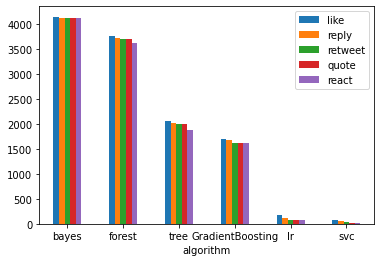

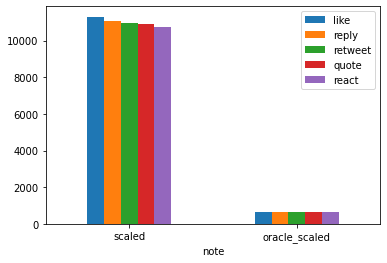

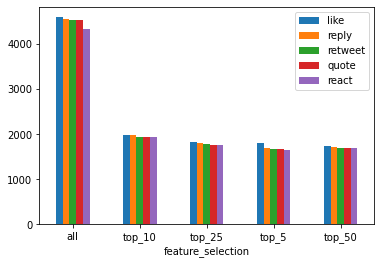

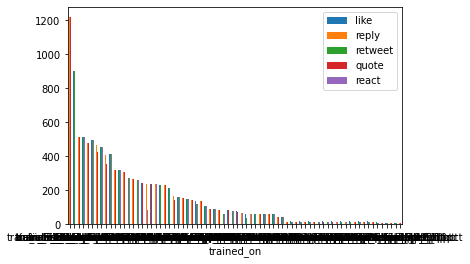

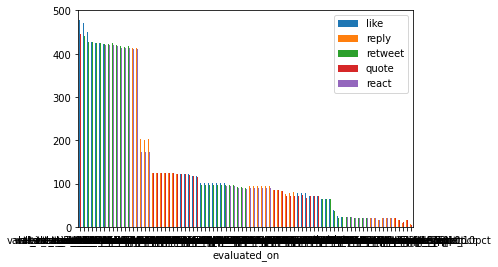

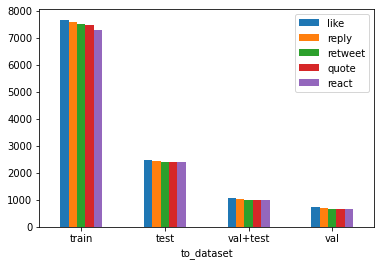

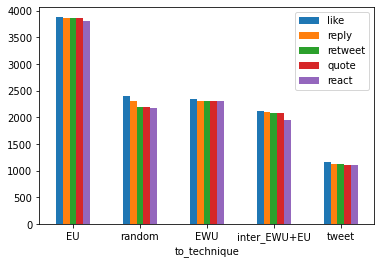

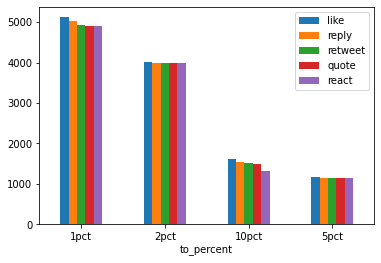

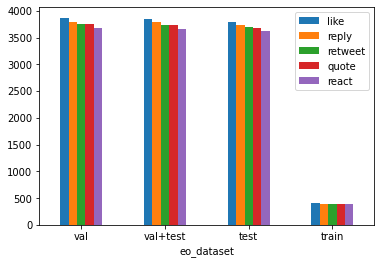

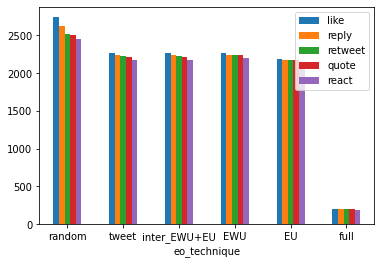

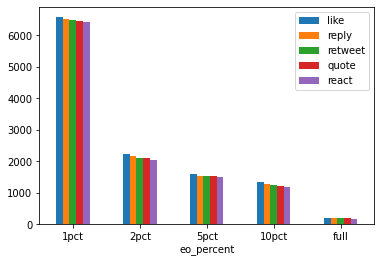

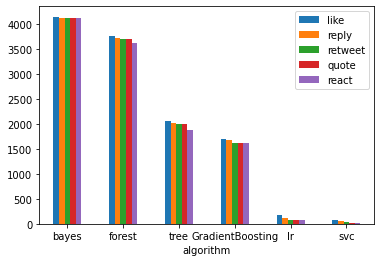

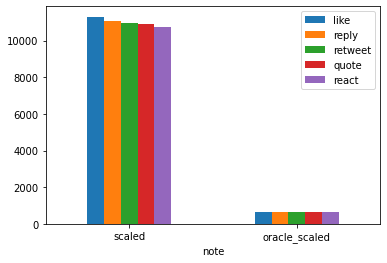

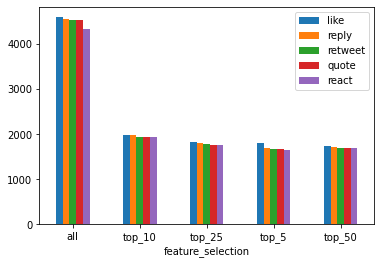

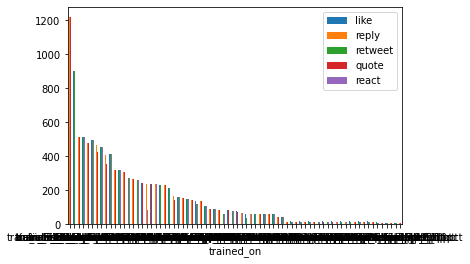

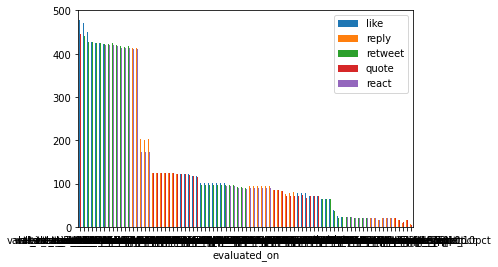

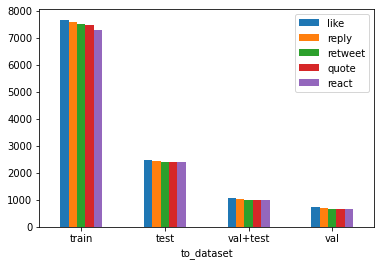

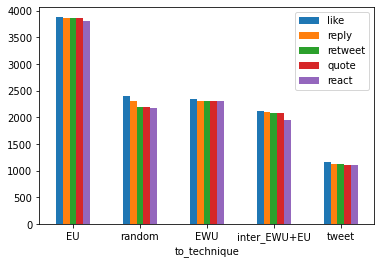

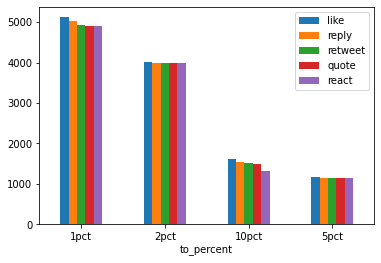

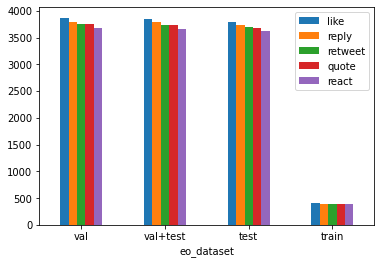

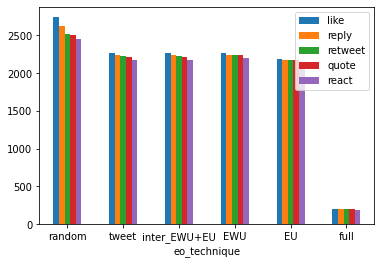

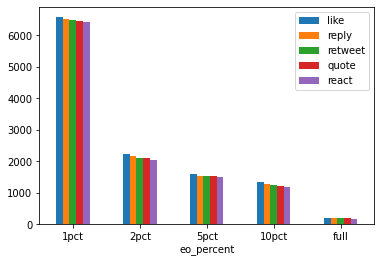

In [4]:
nonans_deflattened_prauc, nonans_deflattened_rce = import_merge_and_validate_final_evals(data_to_be_cosidered=DATA_TO_BE_CONSIDERED,
                                      final_evals_folder=FINAL_EVALS_FOLDER, 
                                      final_prauc_filename=FINAL_PRAUC_FILENAME, 
                                      final_rce_filename=FINAL_RCE_FILENAME, 
                                      dev_prefix=DEV_PREFIX,
                                      all_engs=ALL_ENGS, 
                                      eval_col=EVAL_COL, 
                                      flatten=False,
                                      sorting_order=SORTING_ORDER,
                                      keep="best",
                                      print_progress=CALCULATE_STEPS,)

custom_prauc_rce_display(nonans_deflattened_prauc, 
                         nonans_deflattened_rce, 
                         df_name="final_deflattened_nonan",
                         export_path=EVALS_VALUE_COUNTS_FOLDER, 
                         data_to_be_cosidered=DATA_TO_BE_CONSIDERED, 
                         flatten=False, 
                         print_progress=CALCULATE_STEPS)

Let us also load the flattened version that we would use latter.

Evals did not have to be (de)flattened.
(De)flattenig needed: for flatten=True, flatten_statuses={'prauc_evals': False, 'rce_evals': False}
Flattened dict_keys(['prauc_evals', 'rce_evals'])
Shapes of PRAUC/RCE at start: (72650, 7)/(74375, 7), 
after removing duplicates: (59990, 7)/(61595, 7) (kept best), 
and after removing inconsistencies=(59690, 7)/(59690, 7).
Evals did not have to be (de)flattened.
____16.05.2023 20:50:09____

Read final evals for final_flattened_PRAUC of shape (59690, 13) for data_to_be_cosidered=combined-.
final_flattened_PRAUC shape: (59690, 13), of that non-nans for evaluation=58105.
Present algorithms in final_flattened_PRAUC


evaluations
algorithm                    
bayes                   20760
forest                  18855
tree                    10309
GradientBoosting         8531
lr                        870
svc                       365

Present notes in final_flattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
note                      
scaled               56540
oracle_scaled         3150

Present feature_selections in final_flattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
feature_selection             
all                      22995
top_10                    9935
top_25                    9070
top_5                     9010
top_50                    8680

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_flattened_PRAUC


evaluations
trained_on                                    
train_EU_sample_1pct                      6104
train_EU_sample_10pct                     4500
train_EWU_sample_2pct                     2560
train_EU_sample_2pct                      2560
train_EWU_sample_1pct                     2525
train_inter_EWU+EU_sample_1pct            2485
train_random_sample_1pct                  2480
train_inter_EWU+EU_sample_2pct            2275
test_random_sample_1pct                   2125
train_random_sample_2pct                  2065
train_EU_sample_5pct                      1600
train_EWU_sample_5pct                     1600
train_tweet_sample_2pct                   1540
test_random_sample_2pct                   1365
train_tweet_sample_1pct                   1315
test_inter_EWU+EU_sample_1pct             1305
train_EWU_sample_10pct                    1205
train_inter_EWU+EU_sample_10pct           1200
test_EU_sample_2pct                       1175
test_EWU_sample_2pct                      1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
train_random_sample_5pct                   790
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
train_tweet_sample_5pct                    400
train_random_sample_10pct                  400
train_inter_EWU+EU_sample_5pct             400
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
train_tweet_sample_10pct                   300
val_EU_sample_2pct                         300
val_EWU_sample_2pct                        300
val+test_EWU_sample_2pct                   300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_random_sample_10pct                     75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_5pct                      75
val_EU_sample_5pct                          75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_flattened_PRAUC


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val_inter_EWU+EU_sample_1pct               2125
val+test_tweet_sample_1pct                 2125
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EWU_sample_1pct                        2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_inter_EWU+EU_sample_1pct              2085
test_EWU_sample_1pct                       2085
val+test_EU_sample_1pct                    2065
test_EU_sample_1pct                        2065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_random_sample_2pct                1065
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
test_tweet_sample_5pct                      505
val+test_tweet_sample_5pct                  505
val+test_random_sample_5pct                 505
val+test_inter_EWU+EU_sample_5pct           505
val_random_sample_5pct                      505
val_tweet_sample_5pct                       505
val_inter_EWU+EU_sample_5pct                505
test_random_sample_5pct                     505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
test_random_sample_10pct                    505
val+test_random_sample_10pct                490
val+test_EU_sample_5pct                     485
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
test_EU_sample_5pct                         485
val+test_EWU_sample_5pct                    485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val_EU_sample_10pct                         360
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
test                                        325
val+test                                    325
val                                         325
train_random_sample_1pct                    200
train_EWU_sample_1pct                       125
train_random_sample_2pct                    115
train_inter_EWU+EU_sample_2pct              115
train_inter_EWU+EU_sample_1pct              115
train_EU_sample_1pct                        104
train_EWU_sample_2pct                       100
train_EWU_sample_5pct                       100
train_EU_sample_5pct                        100
train_EU_sample_2pct                        100
train_inter_EWU+EU_sample_5pct              100
train_random_sample_10pct                   100
train_random_sample_5pct                    100
train_tweet_sample_1pct                     100
train_tweet_sample_2pct                     100
train_tweet_sample_5pct                     100
train_EWU_sample_10pct                       80
train_inter_EWU+EU_sample_10pct              75
train_EU_sample_10pct                        75
trai

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_flattened_PRAUC


evaluations
to_dataset             
train             38304
test              12490
val+test           5286
val                3610

Present to_techniques in final_flattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
to_technique             
EU                  19424
random              12061
EWU                 11765
inter_EWU+EU        10615
tweet                5825

Present to_percents in final_flattened_PRAUC


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
to_percent             
1pct              25635
2pct              20110
10pct              8030
5pct               5915

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_datasets in final_flattened_PRAUC


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020
train              2079

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_techniques in final_flattened_PRAUC


evaluations
eo_technique             
random              13756
tweet               11360
inter_EWU+EU        11320
EWU                 11315
EU                  10964
full                  975

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_flattened_PRAUC


evaluations
eo_percent             
1pct              32910
2pct              11170
5pct               7955
10pct              6680
full                975

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817



____16.05.2023 20:50:11____

Read final evals for final_flattened_RCE of shape (59690, 13) for data_to_be_cosidered=combined-.
final_flattened_RCE shape: (59690, 13), of that non-nans for evaluation=58105.
Present algorithms in final_flattened_RCE


evaluations
algorithm                    
bayes                   20760
forest                  18855
tree                    10309
GradientBoosting         8531
lr                        870
svc                       365

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present notes in final_flattened_RCE


evaluations
note                      
scaled               56540
oracle_scaled         3150

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present feature_selections in final_flattened_RCE


evaluations
feature_selection             
all                      22995
top_10                    9935
top_25                    9070
top_5                     9010
top_50                    8680

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present trained_ons in final_flattened_RCE


evaluations
trained_on                                    
train_EU_sample_1pct                      6104
train_EU_sample_10pct                     4500
train_EWU_sample_2pct                     2560
train_EU_sample_2pct                      2560
train_EWU_sample_1pct                     2525
train_inter_EWU+EU_sample_1pct            2485
train_random_sample_1pct                  2480
train_inter_EWU+EU_sample_2pct            2275
test_random_sample_1pct                   2125
train_random_sample_2pct                  2065
train_EU_sample_5pct                      1600
train_EWU_sample_5pct                     1600
train_tweet_sample_2pct                   1540
test_random_sample_2pct                   1365
train_tweet_sample_1pct                   1315
test_inter_EWU+EU_sample_1pct             1305
train_EWU_sample_10pct                    1205
train_inter_EWU+EU_sample_10pct           1200
test_EU_sample_2pct                       1175
test_EWU_sample_2pct                      1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
train_random_sample_5pct                   790
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
train_tweet_sample_5pct                    400
train_random_sample_10pct                  400
train_inter_EWU+EU_sample_5pct             400
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
train_tweet_sample_10pct                   300
val_EU_sample_2pct                         300
val_EWU_sample_2pct                        300
val+test_EWU_sample_2pct                   300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_random_sample_10pct                     75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_5pct                      75
val_EU_sample_5pct                          75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present evaluated_ons in final_flattened_RCE


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val_inter_EWU+EU_sample_1pct               2125
val+test_tweet_sample_1pct                 2125
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EWU_sample_1pct                        2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_inter_EWU+EU_sample_1pct              2085
test_EWU_sample_1pct                       2085
val+test_EU_sample_1pct                    2065
test_EU_sample_1pct                        2065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_random_sample_2pct                1065
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
test_tweet_sample_5pct                      505
val+test_tweet_sample_5pct                  505
val+test_random_sample_5pct                 505
val+test_inter_EWU+EU_sample_5pct           505
val_random_sample_5pct                      505
val_tweet_sample_5pct                       505
val_inter_EWU+EU_sample_5pct                505
test_random_sample_5pct                     505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
test_random_sample_10pct                    505
val+test_random_sample_10pct                490
val+test_EU_sample_5pct                     485
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
test_EU_sample_5pct                         485
val+test_EWU_sample_5pct                    485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val_EU_sample_10pct                         360
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
test                                        325
val+test                                    325
val                                         325
train_random_sample_1pct                    200
train_EWU_sample_1pct                       125
train_random_sample_2pct                    115
train_inter_EWU+EU_sample_2pct              115
train_inter_EWU+EU_sample_1pct              115
train_EU_sample_1pct                        104
train_EWU_sample_2pct                       100
train_EWU_sample_5pct                       100
train_EU_sample_5pct                        100
train_EU_sample_2pct                        100
train_inter_EWU+EU_sample_5pct              100
train_random_sample_10pct                   100
train_random_sample_5pct                    100
train_tweet_sample_1pct                     100
train_tweet_sample_2pct                     100
train_tweet_sample_5pct                     100
train_EWU_sample_10pct                       80
train_inter_EWU+EU_sample_10pct              75
train_EU_sample_10pct                        75
trai

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present to_datasets in final_flattened_RCE


evaluations
to_dataset             
train             38304
test              12490
val+test           5286
val                3610

Present to_techniques in final_flattened_RCE


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
to_technique             
EU                  19424
random              12061
EWU                 11765
inter_EWU+EU        10615
tweet                5825

Present to_percents in final_flattened_RCE


D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


evaluations
to_percent             
1pct              25635
2pct              20110
10pct              8030
5pct               5915

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_datasets in final_flattened_RCE


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020
train              2079

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",
C:\Users\Jovan\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Present eo_techniques in final_flattened_RCE


evaluations
eo_technique             
random              13756
tweet               11360
inter_EWU+EU        11320
EWU                 11315
EU                  10964
full                  975

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


Present eo_percents in final_flattened_RCE


evaluations
eo_percent             
1pct              32910
2pct              11170
5pct               7955
10pct              6680
full                975

D:\Recsys-Data-Backup\2020recsystwitter\PS_Statistics\Functions\st_print_basic_eval_all_stats.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfvc.to_latex(tex_export_path, index=True,  caption=f"Counts of values of {col} in {df_name}",


algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target   evaluation  
0      10pct     like -1352.785472  
1      10pct    reply  -643.912756  
2      10pct  retweet  -949.838046  
3      10pct    quote  -479.297808  
4      10pct    react -1345.101797

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target   evaluation  
0      10pct     like -1352.785472  
1      10pct    reply  -643.912756  
2      10pct  retweet  -949.838046  
3      10pct    quote  -479.297808  
4      10pct    react -1345.101797

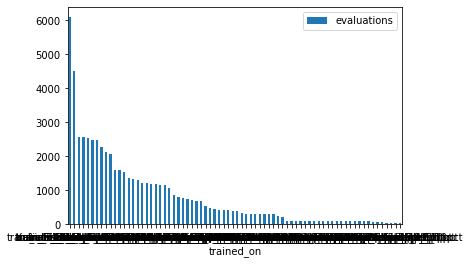

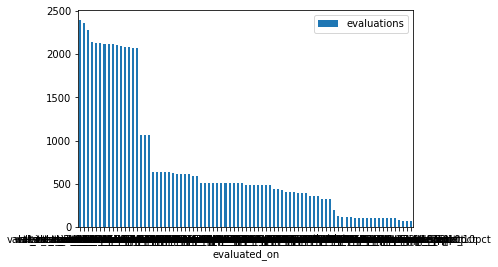

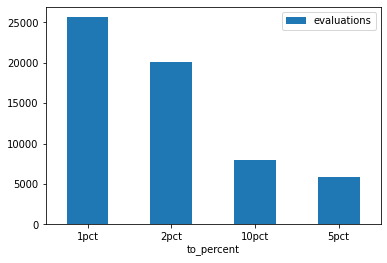

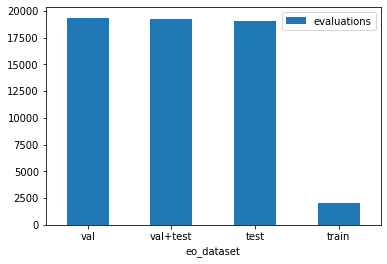

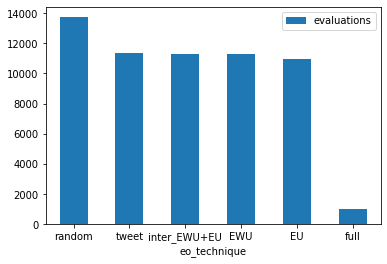

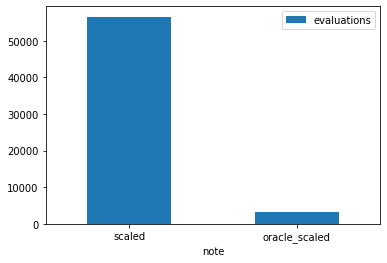

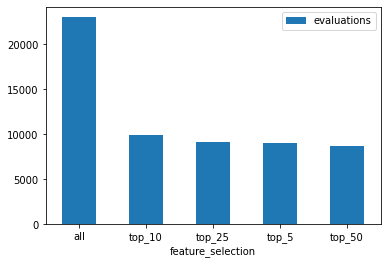

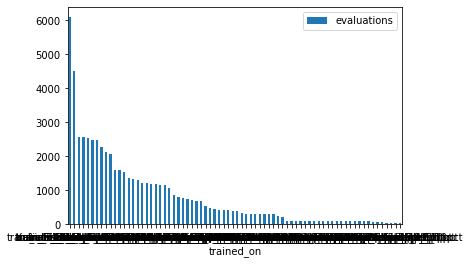

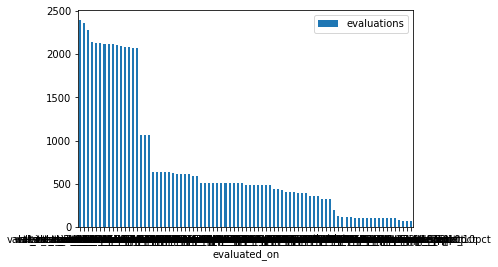

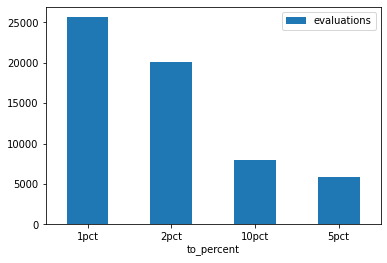

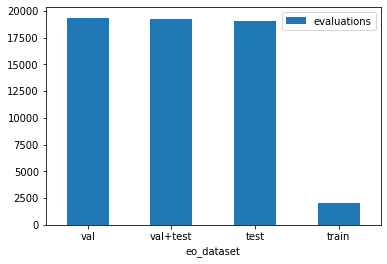

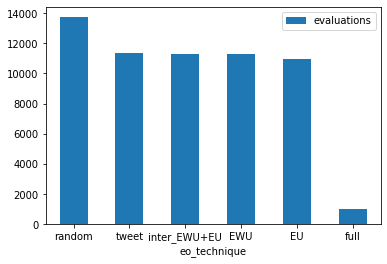

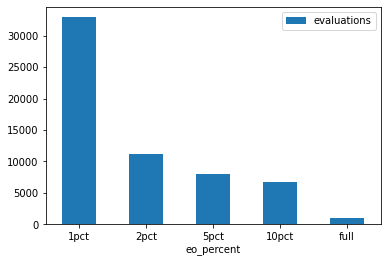

In [5]:
prauc, rce = import_merge_and_validate_final_evals(data_to_be_cosidered=DATA_TO_BE_CONSIDERED,
                                      final_evals_folder=FINAL_EVALS_FOLDER, 
                                      final_prauc_filename=FINAL_PRAUC_FILENAME, 
                                      final_rce_filename=FINAL_RCE_FILENAME, 
                                      dev_prefix=DEV_PREFIX,
                                      all_engs=ALL_ENGS, 
                                      eval_col=EVAL_COL, 
                                      flatten=True,
                                      sorting_order=SORTING_ORDER,
                                      keep="best",
                                      print_progress=CALCULATE_STEPS,)

custom_prauc_rce_display(prauc, 
                         rce,  
                         df_name="final_flattened",
                         export_path=EVALS_VALUE_COUNTS_FOLDER,
                         data_to_be_cosidered=DATA_TO_BE_CONSIDERED, 
                         flatten=True)

In [6]:
cols = [col for col in prauc.columns if col != "evaluation"]
unique_col_values = prauc[cols].nunique()
unique_col_values

algorithm             6
note                  2
feature_selection     5
trained_on           74
to_dataset            4
to_technique          5
to_percent            4
evaluated_on         83
eo_dataset            4
eo_technique          6
eo_percent            5
target                5
dtype: int64

In [7]:
np.prod(unique_col_values)

17688960000

17688960000 is the number 17,688,960,000, which is 17 billion, 688 million, 960 thousand.

In [8]:
unique_col_counts = prauc[cols].value_counts()
pd.DataFrame(unique_col_counts)

0
algorithm        note          feature_selection trained_on              to_dataset to_technique to_percent evaluated_on                      eo_dataset eo_technique eo_percent target    
GradientBoosting oracle_scaled all               test_random_sample_1pct test       random       1pct       test_EU_sample_1pct               test       EU           1pct       like     1
forest           scaled        top_25            test_EU_sample_2pct     test       EU           2pct       val+test_inter_EWU+EU_sample_1pct val+test   inter_EWU+EU 1pct       quote    1
                                                                                                            test_tweet_sample_1pct            test       tweet        1pct       retweet  1
                                                                                                            val+test_EU_sample_1pct           val+test   EU           1pct       like     1
                                                                                                                                                                                 quote    1
...                                                                                                                                                                                      ..
bayes            scaled        top_25            test_EU_sample_1pct     test       EU           1pct       test_random_sample_1pct           test       random       1pct       like     1
                                                                                                                                                                                 quote    1
                                                                                                                                                                                 react    1
                                                                                                                                                                                 reply    1
tree             scaled        top_50            val_tweet_sample_5pct   val        tweet        5pct       val_tweet_sample_5pct             val        tweet        5pct       retweet  1

[59690 rows x 1 columns]

### Investigating common factors for eval_all

Now let us consider how many samples we would have if we wanted to balance our data for each factors.

In [9]:
common_factors_prauc, common_factors_prauc_stats = get_common_factor_combinations(prauc, return_found_counts=True, print_progress=False)
common_factors_rce, common_factors_rce_stats = get_common_factor_combinations(rce, return_found_counts=True, print_progress=False)
common_factors_dict = {"PRAUC":common_factors_prauc, "RCE":common_factors_rce}

if CALCULATE_STEPS:
    print("PRAUC common factors:")
    display(common_factors_prauc_stats)
    print("RCE common factors:")
    display(common_factors_rce_stats)
    print("Common factors dict: PRAUC, algorithm:")
    display(common_factors_dict["PRAUC"]["algorithm"])

PRAUC common factors:


factor        calculated_dt  \
0             algorithm  16.05.2023 20:50:19   
1                  note  16.05.2023 20:50:21   
2     feature_selection  16.05.2023 20:50:24   
3            trained_on  16.05.2023 20:50:26   
4            to_dataset  16.05.2023 20:50:28   
5          to_technique  16.05.2023 20:50:31   
6            to_percent  16.05.2023 20:50:33   
7          evaluated_on  16.05.2023 20:50:36   
8                target  16.05.2023 20:50:38   
9  all factors combined  16.05.2023 20:50:41   

                                             values  common_counts   None  
0  [GradientBoosting, bayes, forest, lr, svc, tree]            612    612  
1                           [oracle_scaled, scaled]           5182   5182  
2              [all, top_10, top_25, top_5, top_50]          37845  37845  
3                                                []              0      0  
4                                                []              0      0  
5                                                []              0      0  
6                                                []              0      0  
7                                                []              0      0  
8              [like, reply, retweet, quote, react]          56635  56635  
9                              all factors combined              0      0

RCE common factors:


factor        calculated_dt  \
0             algorithm  16.05.2023 20:50:44   
1                  note  16.05.2023 20:50:46   
2     feature_selection  16.05.2023 20:50:49   
3            trained_on  16.05.2023 20:50:51   
4            to_dataset  16.05.2023 20:50:54   
5          to_technique  16.05.2023 20:50:56   
6            to_percent  16.05.2023 20:50:58   
7          evaluated_on  16.05.2023 20:51:01   
8                target  16.05.2023 20:51:03   
9  all factors combined  16.05.2023 20:51:05   

                                             values  common_counts   None  
0  [GradientBoosting, bayes, forest, lr, svc, tree]            612    612  
1                           [oracle_scaled, scaled]           5182   5182  
2              [all, top_10, top_25, top_5, top_50]          37845  37845  
3                                                []              0      0  
4                                                []              0      0  
5                                                []              0      0  
6                                                []              0      0  
7                                                []              0      0  
8              [like, reply, retweet, quote, react]          56635  56635  
9                              all factors combined              0      0

Common factors dict: PRAUC, algorithm:


algorithm    note feature_selection               trained_on  \
7475   GradientBoosting  scaled               all  test_random_sample_1pct   
7480   GradientBoosting  scaled               all  test_random_sample_1pct   
7485   GradientBoosting  scaled               all  test_random_sample_1pct   
7490   GradientBoosting  scaled               all  test_random_sample_1pct   
7495   GradientBoosting  scaled               all  test_random_sample_1pct   
...                 ...     ...               ...                      ...   
59070              tree  scaled            top_50   val_random_sample_1pct   
59071              tree  scaled            top_50   val_random_sample_1pct   
59072              tree  scaled            top_50   val_random_sample_1pct   
59073              tree  scaled            top_50   val_random_sample_1pct   
59074              tree  scaled            top_50   val_random_sample_1pct   

      to_dataset to_technique to_percent                 evaluated_on  \
7475        test       random       1pct      test_random_sample_2pct   
7480        test       random       1pct  val+test_random_sample_1pct   
7485        test       random       1pct  val+test_random_sample_2pct   
7490        test       random       1pct       val_random_sample_1pct   
7495        test       random       1pct       val_random_sample_2pct   
...          ...          ...        ...                          ...   
59070        val       random       1pct       val_random_sample_1pct   
59071        val       random       1pct       val_random_sample_1pct   
59072        val       random       1pct       val_random_sample_1pct   
59073        val       random       1pct       val_random_sample_1pct   
59074        val       random       1pct       val_random_sample_1pct   

      eo_dataset eo_technique eo_percent   target  evaluation  
7475        test       random       2pct     like    0.708857  
7480    val+test       random       1pct     like    0.696456  
7485    val+test       random       2pct     like    0.708649  
7490         val       random       1pct     like    0.691725  
7495         val       random       2pct     like    0.705202  
...          ...          ...        ...      ...         ...  
59070        val       random       1pct     like    0.682113  
59071        val       random       1pct    reply    0.512918  
59072        val       random       1pct  retweet    0.377381  
59073        val       random       1pct    quote    0.504417  
59074        val       random       1pct    react    0.728355  

[612 rows x 13 columns]

We would be using ```evaluated_on``` as the subject in paired (repeated measurement tests). Let us take a preliminary glance at this factor only.

In [10]:
common_prauc_dict_paired = get_common_factor_combinations(prauc, factors_to_investigate=["evaluated_on"], target_col = "target")

	At 16.05.2023 20:51:08 done with common factor evaluated_on with values [] and shape (0, 13).
		 → {'like': (0, 13), 'reply': (0, 13), 'retweet': (0, 13), 'quote': (0, 13), 'react': (0, 13)}.
	At 16.05.2023 20:51:10 done with all factors together with shape (0, 13).
		 → {'like': (0, 13), 'reply': (0, 13), 'retweet': (0, 13), 'quote': (0, 13), 'react': (0, 13)}.


So there are no intersections of factors for each ```evaluated_on```. Let us look at distribution as well.

____16.05.2023 20:51:10____

Read final evals for _PRAUC of shape (59690, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (59690, 13), of that non-nans for evaluation=58105.
Present algorithms in _PRAUC


evaluations
algorithm                    
bayes                   20760
forest                  18855
tree                    10309
GradientBoosting         8531
lr                        870
svc                       365

Present notes in _PRAUC


evaluations
note                      
scaled               56540
oracle_scaled         3150

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                      22995
top_10                    9935
top_25                    9070
top_5                     9010
top_50                    8680

Present trained_ons in _PRAUC


evaluations
trained_on                                    
train_EU_sample_1pct                      6104
train_EU_sample_10pct                     4500
train_EWU_sample_2pct                     2560
train_EU_sample_2pct                      2560
train_EWU_sample_1pct                     2525
train_inter_EWU+EU_sample_1pct            2485
train_random_sample_1pct                  2480
train_inter_EWU+EU_sample_2pct            2275
test_random_sample_1pct                   2125
train_random_sample_2pct                  2065
train_EU_sample_5pct                      1600
train_EWU_sample_5pct                     1600
train_tweet_sample_2pct                   1540
test_random_sample_2pct                   1365
train_tweet_sample_1pct                   1315
test_inter_EWU+EU_sample_1pct             1305
train_EWU_sample_10pct                    1205
train_inter_EWU+EU_sample_10pct           1200
test_EU_sample_2pct                       1175
test_EWU_sample_2pct                      1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
train_random_sample_5pct                   790
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
train_tweet_sample_5pct                    400
train_random_sample_10pct                  400
train_inter_EWU+EU_sample_5pct             400
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
train_tweet_sample_10pct                   300
val_EU_sample_2pct                         300
val_EWU_sample_2pct                        300
val+test_EWU_sample_2pct                   300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_random_sample_10pct                     75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_5pct                      75
val_EU_sample_5pct                          75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val_inter_EWU+EU_sample_1pct               2125
val+test_tweet_sample_1pct                 2125
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EWU_sample_1pct                        2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_inter_EWU+EU_sample_1pct              2085
test_EWU_sample_1pct                       2085
val+test_EU_sample_1pct                    2065
test_EU_sample_1pct                        2065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_random_sample_2pct                1065
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
test_tweet_sample_5pct                      505
val+test_tweet_sample_5pct                  505
val+test_random_sample_5pct                 505
val+test_inter_EWU+EU_sample_5pct           505
val_random_sample_5pct                      505
val_tweet_sample_5pct                       505
val_inter_EWU+EU_sample_5pct                505
test_random_sample_5pct                     505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
test_random_sample_10pct                    505
val+test_random_sample_10pct                490
val+test_EU_sample_5pct                     485
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
test_EU_sample_5pct                         485
val+test_EWU_sample_5pct                    485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val_EU_sample_10pct                         360
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
test                                        325
val+test                                    325
val                                         325
train_random_sample_1pct                    200
train_EWU_sample_1pct                       125
train_random_sample_2pct                    115
train_inter_EWU+EU_sample_2pct              115
train_inter_EWU+EU_sample_1pct              115
train_EU_sample_1pct                        104
train_EWU_sample_2pct                       100
train_EWU_sample_5pct                       100
train_EU_sample_5pct                        100
train_EU_sample_2pct                        100
train_inter_EWU+EU_sample_5pct              100
train_random_sample_10pct                   100
train_random_sample_5pct                    100
train_tweet_sample_1pct                     100
train_tweet_sample_2pct                     100
train_tweet_sample_5pct                     100
train_EWU_sample_10pct                       80
train_inter_EWU+EU_sample_10pct              75
train_EU_sample_10pct                        75
trai

Present to_datasets in _PRAUC


evaluations
to_dataset             
train             38304
test              12490
val+test           5286
val                3610

Present to_techniques in _PRAUC


evaluations
to_technique             
EU                  19424
random              12061
EWU                 11765
inter_EWU+EU        10615
tweet                5825

Present to_percents in _PRAUC


evaluations
to_percent             
1pct              25635
2pct              20110
10pct              8030
5pct               5915

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020
train              2079

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random              13756
tweet               11360
inter_EWU+EU        11320
EWU                 11315
EU                  10964
full                  975

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct              32910
2pct              11170
5pct               7955
10pct              6680
full                975

algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

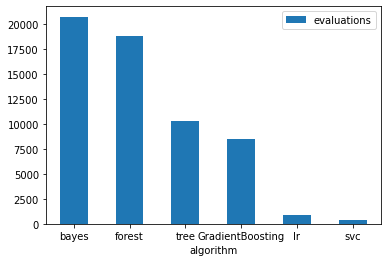

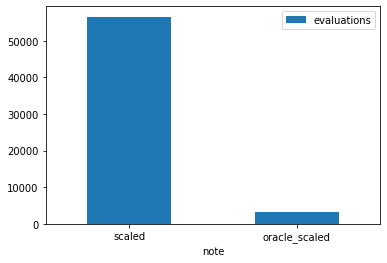

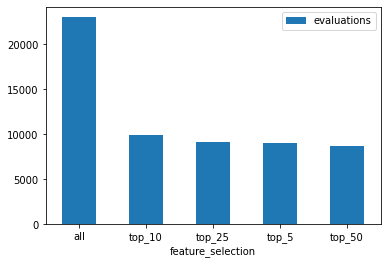

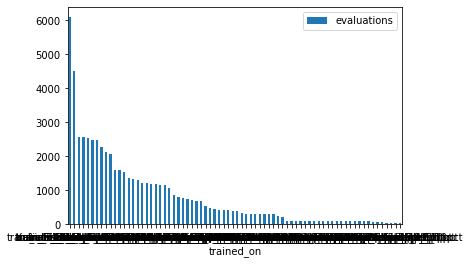

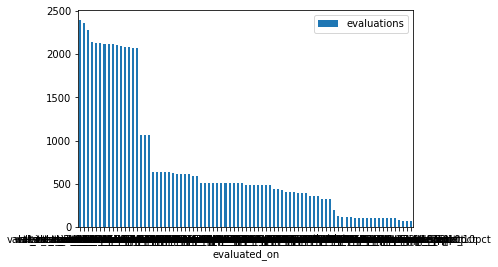

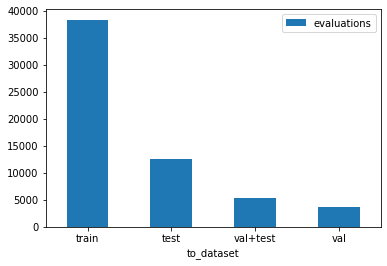

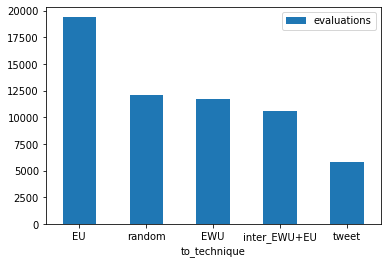

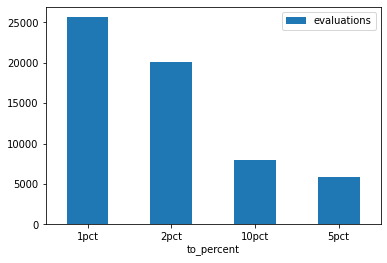

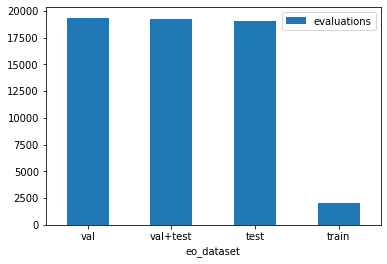

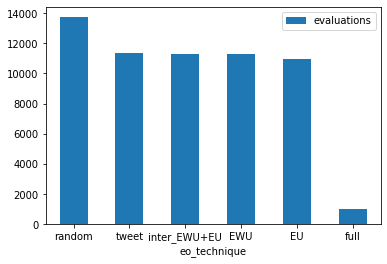

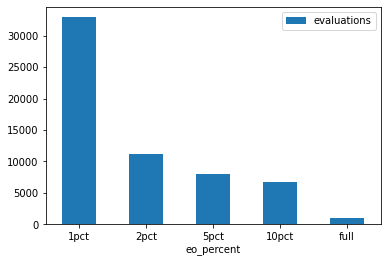

In [11]:
custom_prauc_rce_display(prauc, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

We will have to examine why there are no commom factors at all. But first, let us get some descriptive statistics.


## Descriptive Statistics

### Best Achieved Results Overall

PRAUC PRAUC 47524
PRAUC PRAUC 28805
PRAUC PRAUC 29204
PRAUC PRAUC 3603
PRAUC PRAUC 30583


target         algorithm           note feature_selection  \
0     like              tree         scaled            top_50   
1    reply  GradientBoosting         scaled            top_10   
2  retweet             bayes         scaled               all   
3    quote              tree  oracle_scaled               all   
4    react              tree  oracle_scaled               all   

                 trained_on              evaluated_on     PRAUC  
0  train_tweet_sample_10pct  train_tweet_sample_10pct  0.796888  
1     train_EWU_sample_1pct     train_EWU_sample_1pct  0.514221  
2     train_EWU_sample_1pct     train_EWU_sample_1pct  0.556201  
3      test_EWU_sample_1pct      test_EWU_sample_1pct  0.508153  
4     train_EWU_sample_1pct     train_EWU_sample_1pct  0.808995

RCE RCE 47524
RCE RCE 56381
RCE RCE 15498
RCE RCE 3608
RCE RCE 57079


target algorithm           note feature_selection  \
0     like      tree         scaled            top_50   
1    reply      tree         scaled             top_5   
2  retweet      tree         scaled               all   
3    quote      tree         scaled               all   
4    react      tree  oracle_scaled               all   

                 trained_on              evaluated_on          RCE  
0  train_tweet_sample_10pct  train_tweet_sample_10pct -1022.949339  
1        val_EU_sample_1pct        val_EU_sample_1pct  -634.663816  
2     train_EU_sample_10pct     train_EU_sample_10pct  -794.830702  
3      test_EWU_sample_1pct      test_EWU_sample_1pct  -464.951610  
4       val_EWU_sample_1pct       val_EWU_sample_1pct -1133.436467

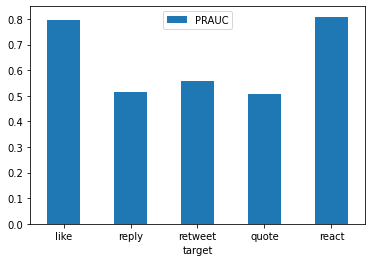

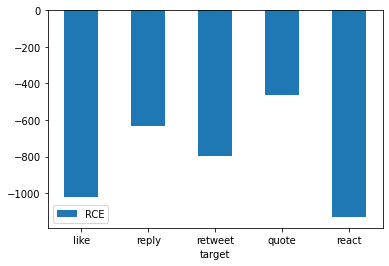

In [12]:
important_columns = ["target", "algorithm", "note", "feature_selection", "trained_on", "evaluated_on",]

best_results_overall = get_best_results(prauc, rce, df_name="", print_progress = CALCULATE_STEPS,
                     important_columns=important_columns, export_path=EVALS_VALUE_BEST_RESULTS)

### Best Achieved Results that were Trained on a Train Subset and Evaluate on a val+test Subset

trained on a train subset and evaluated on a val+test subsetPRAUC PRAUC 25769
trained on a train subset and evaluated on a val+test subsetPRAUC PRAUC 31170
trained on a train subset and evaluated on a val+test subsetPRAUC PRAUC 36781
trained on a train subset and evaluated on a val+test subsetPRAUC PRAUC 12633
trained on a train subset and evaluated on a val+test subsetPRAUC PRAUC 25773


target         algorithm    note feature_selection  \
0     like  GradientBoosting  scaled               all   
1    reply  GradientBoosting  scaled               all   
2  retweet  GradientBoosting  scaled            top_25   
3    quote             bayes  scaled            top_10   
4    react  GradientBoosting  scaled               all   

                       trained_on                 evaluated_on     PRAUC  
0            train_EU_sample_5pct                     val+test  0.727348  
1           train_EWU_sample_2pct  val+test_random_sample_1pct  0.513177  
2  train_inter_EWU+EU_sample_1pct     val+test_EWU_sample_1pct  0.550549  
3           train_EU_sample_10pct     val+test_EU_sample_10pct  0.503527  
4            train_EU_sample_5pct                     val+test  0.762271

trained on a train subset and evaluated on a val+test subsetRCE RCE 25769
trained on a train subset and evaluated on a val+test subsetRCE RCE 23545
trained on a train subset and evaluated on a val+test subsetRCE RCE 25771
trained on a train subset and evaluated on a val+test subsetRCE RCE 23472
trained on a train subset and evaluated on a val+test subsetRCE RCE 34463


target         algorithm    note feature_selection             trained_on  \
0     like  GradientBoosting  scaled               all   train_EU_sample_5pct   
1    reply  GradientBoosting  scaled            top_25   train_EU_sample_2pct   
2  retweet  GradientBoosting  scaled               all   train_EU_sample_5pct   
3    quote  GradientBoosting  scaled            top_10   train_EU_sample_2pct   
4    react            forest  scaled               all  train_EWU_sample_5pct   

                  evaluated_on          RCE  
0                     val+test -1418.213510  
1      val+test_EU_sample_1pct  -638.960142  
2                     val+test  -865.185403  
3  val+test_random_sample_1pct  -474.871808  
4                     val+test -1450.434933

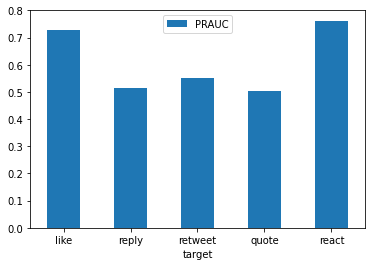

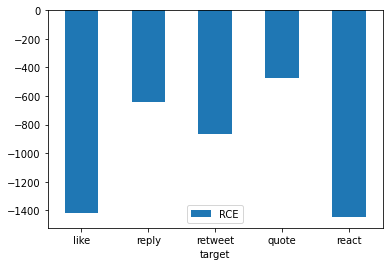

In [13]:
tsvts_prauc = prauc.loc[(prauc["eo_dataset"]=="val+test") & (prauc["to_dataset"]=="train")]
tsvts_rce = rce.loc[(rce["eo_dataset"] == "val+test") & (rce["to_dataset"] == "train")]
best_results_tsvts = get_best_results(tsvts_prauc, tsvts_rce, df_name="trained on a train subset and evaluated on a val+test subset", print_progress = CALCULATE_STEPS,
                     important_columns=important_columns, export_path=EVALS_VALUE_BEST_RESULTS)

### Best Achieved Results Full val+test Dataset

evaluated on full val+testPRAUC PRAUC 25769
evaluated on full val+testPRAUC PRAUC 13906
evaluated on full val+testPRAUC PRAUC 18707
evaluated on full val+testPRAUC PRAUC 12628
evaluated on full val+testPRAUC PRAUC 25773


target         algorithm    note feature_selection             trained_on  \
0     like  GradientBoosting  scaled               all   train_EU_sample_5pct   
1    reply            forest  scaled               all  train_EU_sample_10pct   
2  retweet             bayes  scaled               all   train_EU_sample_1pct   
3    quote             bayes  scaled            top_10  train_EU_sample_10pct   
4    react  GradientBoosting  scaled               all   train_EU_sample_5pct   

  evaluated_on     PRAUC  
0     val+test  0.727348  
1     val+test  0.512895  
2     val+test  0.549688  
3     val+test  0.503454  
4     val+test  0.762271

evaluated on full val+testRCE RCE 25769
evaluated on full val+testRCE RCE 23210
evaluated on full val+testRCE RCE 25771
evaluated on full val+testRCE RCE 12628
evaluated on full val+testRCE RCE 34463


target         algorithm    note feature_selection             trained_on  \
0     like  GradientBoosting  scaled               all   train_EU_sample_5pct   
1    reply  GradientBoosting  scaled               all   train_EU_sample_2pct   
2  retweet  GradientBoosting  scaled               all   train_EU_sample_5pct   
3    quote             bayes  scaled            top_10  train_EU_sample_10pct   
4    react            forest  scaled               all  train_EWU_sample_5pct   

  evaluated_on          RCE  
0     val+test -1418.213510  
1     val+test  -643.540953  
2     val+test  -865.185403  
3     val+test  -478.373692  
4     val+test -1450.434933

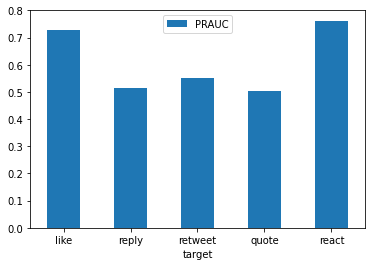

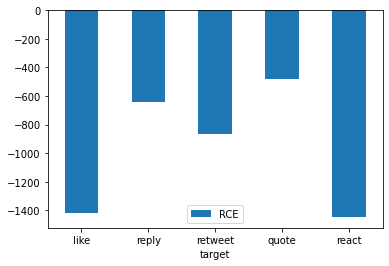

In [14]:
vt_prauc = prauc.loc[prauc["evaluated_on"]=="val+test"]
vt_rce = rce.loc[rce["evaluated_on"] == "val+test"]
best_results_vt = get_best_results(vt_prauc, vt_rce, df_name="evaluated on full val+test", print_progress = CALCULATE_STEPS,
                     important_columns=important_columns, export_path=EVALS_VALUE_BEST_RESULTS)

### Best Achieved Results Full val+test Dataset that were Trained on a Train Subset and Evaluate on a val+test Subset

trained on a train subset and evaluated on full val+testPRAUC PRAUC 25769
trained on a train subset and evaluated on full val+testPRAUC PRAUC 13906
trained on a train subset and evaluated on full val+testPRAUC PRAUC 18707
trained on a train subset and evaluated on full val+testPRAUC PRAUC 12628
trained on a train subset and evaluated on full val+testPRAUC PRAUC 25773


target         algorithm    note feature_selection             trained_on  \
0     like  GradientBoosting  scaled               all   train_EU_sample_5pct   
1    reply            forest  scaled               all  train_EU_sample_10pct   
2  retweet             bayes  scaled               all   train_EU_sample_1pct   
3    quote             bayes  scaled            top_10  train_EU_sample_10pct   
4    react  GradientBoosting  scaled               all   train_EU_sample_5pct   

  evaluated_on     PRAUC  
0     val+test  0.727348  
1     val+test  0.512895  
2     val+test  0.549688  
3     val+test  0.503454  
4     val+test  0.762271

trained on a train subset and evaluated on full val+testRCE RCE 25769
trained on a train subset and evaluated on full val+testRCE RCE 23210
trained on a train subset and evaluated on full val+testRCE RCE 25771
trained on a train subset and evaluated on full val+testRCE RCE 12628
trained on a train subset and evaluated on full val+testRCE RCE 34463


target         algorithm    note feature_selection             trained_on  \
0     like  GradientBoosting  scaled               all   train_EU_sample_5pct   
1    reply  GradientBoosting  scaled               all   train_EU_sample_2pct   
2  retweet  GradientBoosting  scaled               all   train_EU_sample_5pct   
3    quote             bayes  scaled            top_10  train_EU_sample_10pct   
4    react            forest  scaled               all  train_EWU_sample_5pct   

  evaluated_on          RCE  
0     val+test -1418.213510  
1     val+test  -643.540953  
2     val+test  -865.185403  
3     val+test  -478.373692  
4     val+test -1450.434933

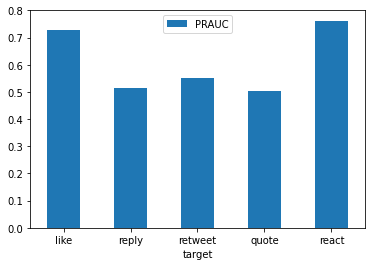

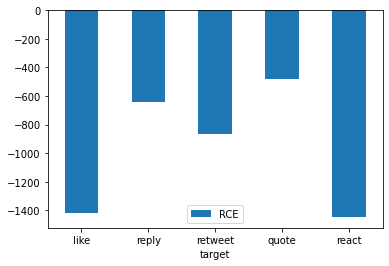

In [15]:
tsvt_prauc = prauc.loc[(prauc["evaluated_on"]=="val+test") & (prauc["to_dataset"]=="train")]
tsvt_rce = rce.loc[(rce["evaluated_on"] == "val+test") & (rce["to_dataset"] == "train")]
best_results_tsvt = get_best_results(tsvt_prauc, tsvt_rce, df_name="trained on a train subset and evaluated on full val+test", print_progress = CALCULATE_STEPS,
                     important_columns=important_columns, export_path=EVALS_VALUE_BEST_RESULTS)

### Mean and STD

First, let us find the mean and STD across the whole dataset and for each group, not considering whether the groups are equally big.

In [16]:
initial_cols = ["algorithm", "note", "feature_selection",  "trained_on", "evaluated_on"]
df_metric_dict = {"PRAUC":deflattened_prauc, "RCE":deflattened_rce, "PRAUC_noNaNs":nonans_deflattened_prauc, "RCE_noNaNs":nonans_deflattened_rce}
mean_std_dfs = {}

with pd.option_context('display.max_rows', 50, 'display.max_columns', None, 'display.width', None):
    for metric_name in df_metric_dict:
        mean_std_dfs[metric_name] = {}
        full_df = df_metric_dict[metric_name]
        print("___________________________________________")
        print(f"Stats for {metric_name} of shape {full_df.shape}.")
        print(full_df.dtypes)
        mean_std_dfs[metric_name]["all"] = full_df.groupby(initial_cols)[ALL_ENGS].agg(['max', 'min', 'mean', 'std']).round(4)
        display(mean_std_dfs[metric_name]["all"]) 
        all_cols = initial_cols
        for potential_subject in initial_cols:
            if len(full_df[potential_subject].unique()) < 2:
                all_cols.remove(potential_subject)

        if len(all_cols) > 0:
            for subject in all_cols:
                mean_std_dfs[metric_name][subject] = full_df.dropna(inplace=False).groupby(subject)[ALL_ENGS].agg(['max', 'min', 'mean', 'std', 'count']).round(2)
                print(metric_name, subject, "↓")
                display(mean_std_dfs[metric_name][subject])

___________________________________________
Stats for PRAUC of shape (11939, 16).
algorithm             object
note                  object
feature_selection     object
trained_on            object
to_dataset            object
to_technique          object
to_percent            object
evaluated_on          object
eo_dataset            object
eo_technique          object
eo_percent            object
like                 float64
reply                float64
retweet              float64
quote                float64
react                float64
dtype: object


like  \
                                                                                                           max   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   
...                                                                                                        ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct         0.6929   
                                                 val_random_sample_5pct  val_random_sample_5pct         0.6887   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct          0.7250   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct          0.7309   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct          0.7269   

                                                                                                                \
                                                                                                           min   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   
...                                                                                                        ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct         0.6929   
                                                 val_random_sample_5pct  val_random_sample_5pct         0.6887   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct          0.7250   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct          0.7309   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct          0.7269   

                                                                                                                \
                                                                                                          mean   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   


PRAUC algorithm ↓


like                         reply                          \
                   max   min  mean   std count   max   min  mean   std count   
algorithm                                                                      
GradientBoosting  0.75  0.32  0.62  0.09  1621  0.51  0.01  0.34  0.22  1621   
bayes             0.71  0.21  0.60  0.09  4129  0.51  0.01  0.33  0.21  4129   
forest            0.72  0.31  0.64  0.08  3625  0.51  0.01  0.51  0.05  3625   
lr                0.71  0.59  0.66  0.03    74  0.51  0.01  0.46  0.16    74   
svc               0.71  0.41  0.64  0.10    12  0.51  0.51  0.51  0.00    12   
tree              0.77  0.21  0.63  0.07  1866  0.51  0.01  0.46  0.15  1866   

                 retweet                         quote                         \
                     max   min  mean   std count   max  min  mean   std count   
algorithm                                                                       
GradientBoosting    0.55  0.05  0.32  0.15  1621  0.50  0.0  0.45  0.14  1621   
bayes               0.56  0.05  0.33  0.20  4129  0.50  0.0  0.44  0.15  4129   
forest              0.56  0.05  0.39  0.16  3625  0.50  0.0  0.50  0.03  3625   
lr                  0.56  0.17  0.29  0.09    74  0.50  0.0  0.34  0.23    74   
svc                 0.55  0.55  0.55  0.00    12  0.50  0.5  0.50  0.00    12   
tree                0.55  0.05  0.30  0.14  1866  0.51  0.0  0.44  0.15  1866   

                 react                          
                   max   min  mean   std count  
algorithm                                       
GradientBoosting  0.79  0.34  0.70  0.07  1621  
bayes             0.74  0.24  0.67  0.07  4129  
forest            0.77  0.24  0.72  0.05  3625  
lr                0.74  0.64  0.72  0.03    74  
svc               0.73  0.37  0.66  0.11    12  
tree              0.81  0.24  0.69  0.06  1866

PRAUC note ↓


like                          reply                           \
                max   min  mean   std  count   max   min  mean   std  count   
note                                                                          
oracle_scaled  0.76  0.32  0.67  0.07    628  0.51  0.01  0.48  0.12    628   
scaled         0.77  0.21  0.62  0.09  10699  0.51  0.01  0.41  0.19  10699   

              retweet                          quote                          \
                  max   min  mean   std  count   max  min  mean   std  count   
note                                                                           
oracle_scaled    0.56  0.05  0.44  0.13    628  0.51  0.0  0.47  0.11    628   
scaled           0.56  0.05  0.33  0.18  10699  0.51  0.0  0.46  0.13  10699   

              react                           
                max   min  mean   std  count  
note                                          
oracle_scaled  0.81  0.51  0.72  0.05    628  
scaled         0.81  0.24  0.69  0.07  10699

PRAUC feature_selection ↓


like                         reply                          \
                    max   min  mean   std count   max   min  mean   std count   
feature_selection                                                               
all                0.77  0.32  0.65  0.06  4329  0.51  0.01  0.45  0.15  4329   
top_10             0.72  0.21  0.59  0.09  1925  0.51  0.01  0.35  0.21  1925   
top_25             0.73  0.21  0.63  0.09  1752  0.51  0.01  0.41  0.18  1752   
top_5              0.71  0.41  0.58  0.08  1650  0.51  0.01  0.37  0.22  1650   
top_50             0.75  0.21  0.62  0.11  1671  0.51  0.01  0.42  0.17  1671   

                  retweet                         quote                   \
                      max   min  mean   std count   max  min  mean   std   
feature_selection                                                          
all                  0.56  0.05  0.41  0.14  4329  0.51  0.0  0.48  0.10   
top_10               0.56  0.05  0.27  0.18  1925  0.50  0.0  0.45  0.15   
top_25               0.55  0.05  0.36  0.18  1752  0.51  0.0  0.44  0.15   
top_5                0.56  0.05  0.23  0.17  1650  0.50  0.0  0.46  0.13   
top_50               0.55  0.05  0.33  0.17  1671  0.51  0.0  0.44  0.14   

                        react                          
                  count   max   min  mean   std count  
feature_selection                                      
all                4329  0.81  0.43  0.70  0.05  4329  
top_10             1925  0.78  0.34  0.67  0.08  1925  
top_25             1752  0.78  0.24  0.70  0.07  1752  
top_5              1650  0.74  0.43  0.68  0.07  1650  
top_50             1671  0.79  0.24  0.70  0.08  1671

PRAUC trained_on ↓


like                         reply                    \
                         max   min  mean   std count   max   min  mean   std   
trained_on                                                                     
test_EU_sample_10pct    0.72  0.69  0.71  0.01     4  0.51  0.51  0.51  0.00   
test_EU_sample_1pct     0.71  0.45  0.61  0.08   229  0.51  0.01  0.31  0.22   
test_EU_sample_2pct     0.71  0.48  0.63  0.09   232  0.51  0.02  0.45  0.14   
test_EU_sample_5pct     0.71  0.63  0.68  0.02    12  0.51  0.04  0.41  0.18   
test_EWU_sample_10pct   0.73  0.52  0.63  0.08     7  0.51  0.04  0.34  0.23   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
val_random_sample_2pct  0.71  0.49  0.65  0.06    62  0.51  0.04  0.48  0.11   
val_random_sample_5pct  0.70  0.62  0.67  0.02    12  0.51  0.04  0.41  0.18   
val_tweet_sample_1pct   0.75  0.49  0.65  0.07    14  0.51  0.03  0.37  0.21   
val_tweet_sample_2pct   0.75  0.50  0.66  0.07    12  0.51  0.03  0.37  0.22   
val_tweet_sample_5pct   0.75  0.63  0.69  0.04    12  0.51  0.04  0.42  0.18   

                             retweet                         quote        \
                       count     max   min  mean   std count   max   min   
trained_on                                                                 
test_EU_sample_10pct       4    0.55  0.34  0.45  0.12     4  0.50  0.50   
test_EU_sample_1pct      229    0.55  0.08  0.36  0.20   229  0.50  0.01   
test_EU_sample_2pct      232    0.55  0.06  0.39  0.21   232  0.50  0.03   
test_EU_sample_5pct       12    0.55  0.14  0.42  0.14    12  0.50  0.06   
test_EWU_sample_10pct      7    0.55  0.14  0.32  0.14     7  0.50  0.04   
...                      ...     ...   ...   ...   ...   ...   ...   ...   
val_random_sample_2pct    62    0.55  0.11  0.50  0.10    62  0.50  0.04   
val_random_sample_5pct    12    0.55  0.13  0.40  0.13    12  0.50  0.06   
val_tweet_sample_1pct     14    0.55  0.11  0.35  0.15    14  0.51  0.00   
val_tweet_sample_2pct     12    0.55  0.11  0.33  0.13    12  0.50  0.06   
val_tweet_sample_5pct     12    0.55  0.13  0.38  0.13    12  0.50  0.05   

                                         react                          
                        mean   std count   max   min  mean   std count  
trained_on                                                              
test_EU_sample_10pct    0.50  0.00     4  0.77  0.74  0.76  0.01     4  
test_EU_sample_1pct     0.44  0.15   229  0.74  0.59  0.68  0.05   229  
test_EU_sample_2pct     0.49  0.07   232  0.74  0.60  0.70  0.05   232  
test_EU_sample_5pct     0.43  0.17    12  0.75  0.69  0.72  0.02    12  
test_EWU_sample_10pct   0.38  0.21     7  0.78  0.63  0.70  0.06     7  
...                      ...   ...   ...   ...   ...   ...   ...   ...  
val_random_sample_2pct  0.49  0.08    62  0.74  0.59  0.72  0.04    62  
val_random_sample_5pct  0.43  0.17    12  0.74  0.69  0.73  0.02    12  
val_tweet_sample_1pct   0.37  0.22    14  0.79  0.59  0.71  0.06    14  
val_tweet_sample_2pct   0.43  0.16    12  0.80  0.61  0.72  0.05    12  
val_tweet_sample_5pct   0.43  0.17    12  0.79  0.69  0.74  0.03    12  

[74 rows x 25 columns]

PRAUC evaluated_on ↓


like                         reply                    \
                         max   min  mean   std count   max   min  mean   std   
evaluated_on                                                                   
test                    0.72  0.37  0.64  0.09    62  0.51  0.02  0.38  0.18   
test_EU_sample_10pct    0.72  0.34  0.64  0.09    69  0.51  0.01  0.38  0.20   
test_EU_sample_1pct     0.71  0.21  0.62  0.09   409  0.51  0.01  0.41  0.19   
test_EU_sample_2pct     0.72  0.39  0.63  0.08   112  0.51  0.01  0.39  0.21   
test_EU_sample_5pct     0.71  0.35  0.65  0.08    91  0.51  0.01  0.40  0.20   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
val_random_sample_5pct  0.72  0.32  0.65  0.08    95  0.51  0.01  0.41  0.18   
val_tweet_sample_10pct  0.71  0.39  0.63  0.08    68  0.51  0.01  0.37  0.20   
val_tweet_sample_1pct   0.75  0.34  0.62  0.09   423  0.51  0.01  0.45  0.16   
val_tweet_sample_2pct   0.75  0.39  0.62  0.08   121  0.51  0.01  0.41  0.18   
val_tweet_sample_5pct   0.75  0.38  0.64  0.08    95  0.51  0.01  0.41  0.18   

                             retweet                         quote             \
                       count     max   min  mean   std count   max  min  mean   
evaluated_on                                                                    
test                      62    0.55  0.08  0.36  0.15    62  0.50  0.0  0.38   
test_EU_sample_10pct      69    0.55  0.07  0.30  0.14    69  0.50  0.0  0.44   
test_EU_sample_1pct      409    0.55  0.05  0.36  0.19   409  0.50  0.0  0.46   
test_EU_sample_2pct      112    0.55  0.05  0.29  0.16   112  0.50  0.0  0.43   
test_EU_sample_5pct       91    0.55  0.07  0.31  0.16    91  0.50  0.0  0.45   
...                      ...     ...   ...   ...   ...   ...   ...  ...   ...   
val_random_sample_5pct    95    0.55  0.06  0.32  0.14    95  0.50  0.0  0.46   
val_tweet_sample_10pct    68    0.55  0.05  0.31  0.15    68  0.50  0.0  0.44   
val_tweet_sample_1pct    423    0.55  0.05  0.34  0.19   423  0.51  0.0  0.47   
val_tweet_sample_2pct    121    0.55  0.05  0.31  0.17   121  0.50  0.0  0.46   
val_tweet_sample_5pct     95    0.55  0.05  0.30  0.14    95  0.50  0.0  0.44   

                                   react                          
                         std count   max   min  mean   std count  
evaluated_on                                                      
test                    0.20    62  0.76  0.46  0.69  0.08    62  
test_EU_sample_10pct    0.16    69  0.77  0.49  0.69  0.07    69  
test_EU_sample_1pct     0.13   409  0.75  0.24  0.71  0.05   409  
test_EU_sample_2pct     0.16   112  0.75  0.51  0.69  0.06   112  
test_EU_sample_5pct     0.15    91  0.75  0.50  0.70  0.07    91  
...                      ...   ...   ...   ...   ...   ...   ...  
val_random_sample_5pct  0.13    95  0.75  0.50  0.70  0.06    95  
val_tweet_sample_10pct  0.16    68  0.75  0.50  0.69  0.07    68  
val_tweet_sample_1pct   0.11   423  0.79  0.49  0.70  0.05   423  
val_tweet_sample_2pct   0.13   121  0.80  0.24  0.68  0.08   121  
val_tweet_sample_5pct   0.16    95  0.79  0.41  0.69  0.07    95  

[83 rows x 25 columns]

___________________________________________
Stats for RCE of shape (11939, 16).
algorithm             object
note                  object
feature_selection     object
trained_on            object
to_dataset            object
to_technique          object
to_percent            object
evaluated_on          object
eo_dataset            object
eo_technique          object
eo_percent            object
like                 float64
reply                float64
retweet              float64
quote                float64
react                float64
dtype: object


like  \
                                                                                                              max   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
                                                                         test_tweet_sample_1pct        -2805.7535   
...                                                                                                           ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct        -1571.5736   
                                                 val_random_sample_5pct  val_random_sample_5pct        -1542.1923   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct         -1393.1909   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct         -1355.8012   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct         -1348.8377   

                                                                                                                   \
                                                                                                              min   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
                                                                         test_tweet_sample_1pct        -2805.7535   
...                                                                                                           ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct        -1571.5736   
                                                 val_random_sample_5pct  val_random_sample_5pct        -1542.1923   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct         -1393.1909   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct         -1355.8012   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct         -1348.8377   

                                                                                                                   \
                                                                                                             mean   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
            

RCE algorithm ↓


like                                   reply            \
                      max      min     mean     std count     max       min   
algorithm                                                                     
GradientBoosting -1233.76 -2884.18 -2027.06  350.39  1621 -635.84 -20125.10   
bayes            -1572.26 -2906.41 -2137.14  262.02  4129 -635.84 -28962.50   
forest           -1419.72 -2902.38 -2096.35  403.10  3625 -635.25  -2665.07   
lr               -1599.89 -2650.49 -1839.74  253.69    74 -635.84   -653.82   
svc              -1650.90 -2030.35 -1956.22  136.69    12 -643.61   -648.08   
tree             -1163.16 -2974.91 -1950.93  342.88  1866 -634.66  -2243.46   

                                         retweet                             \
                     mean      std count     max      min     mean      std   
algorithm                                                                     
GradientBoosting  -833.80  1019.08  1621 -826.82 -9617.65 -1803.81  1993.95   
bayes            -4149.97  7659.30  4129 -952.04 -9695.31 -2064.91  2334.26   
forest            -647.37    75.57  3625 -857.38 -9695.31 -1918.47  2362.85   
lr                -643.87     4.28    74 -941.83 -1668.88 -1027.58   139.47   
svc               -645.44     1.84    12 -958.51  -960.77  -959.36     0.98   
tree              -650.25    76.08  1866 -794.83 -9695.31 -1690.22  1976.49   

                         quote                                       react  \
                 count     max       min     mean       std count      max   
algorithm                                                                    
GradientBoosting  1621 -471.58  -3497.55  -548.21    427.92  1621 -1252.13   
bayes             4129 -471.58 -88091.27 -9900.25  23437.37  4129 -1653.56   
forest            3625 -471.58 -57614.11  -536.91   1654.35  3625 -1433.95   
lr                  74 -471.58  -2865.82  -574.57    456.75    74 -1610.16   
svc                 12 -474.46   -475.28  -474.77      0.36    12 -1625.11   
tree              1866 -464.95 -72080.15 -1035.92   4627.87  1866 -1133.44   

                                                  
                      min     mean     std count  
algorithm                                         
GradientBoosting -2588.41 -2053.11  295.73  1621  
bayes            -2538.14 -2154.19  161.71  4129  
forest           -2650.97 -2084.13  309.03  3625  
lr               -2443.29 -1941.43  246.54    74  
svc              -2299.22 -1837.60  243.72    12  
tree             -2887.55 -1916.94  313.90  1866

RCE note ↓


like                                    reply            \
                   max      min     mean     std  count     max       min   
note                                                                        
oracle_scaled -1163.16 -2895.92 -2128.90  434.76    628 -635.84  -5562.14   
scaled        -1164.20 -2974.91 -2072.39  338.97  10699 -634.66 -28962.50   

                                       retweet                             \
                  mean      std  count     max      min     mean      std   
note                                                                        
oracle_scaled  -676.41   287.58    628 -912.87 -9521.81 -2168.59  2648.46   
scaled        -2026.13  5062.74  10699 -794.83 -9695.31 -1895.88  2210.79   

                       quote                                        react  \
               count     max       min     mean       std  count      max   
note                                                                        
oracle_scaled    628 -465.90  -2865.82  -488.21    159.06    628 -1133.44   
scaled         10699 -464.95 -88091.27 -4242.24  15388.29  10699 -1153.24   

                                                
                   min     mean     std  count  
note                                            
oracle_scaled -2518.29 -2083.25  301.72    628  
scaled        -2887.55 -2076.10  273.98  10699

RCE feature_selection ↓


like                                   reply            \
                       max      min     mean     std count     max       min   
feature_selection                                                              
all               -1163.16 -2974.91 -2078.76  396.48  4329 -635.84 -17822.35   
top_10            -1419.86 -2856.61 -2040.41  282.36  1925 -635.55 -28962.50   
top_25            -1341.55 -2972.50 -2147.63  366.56  1752 -634.96 -28757.40   
top_5             -1615.34 -2818.17 -2002.73  185.77  1650 -634.66 -28757.40   
top_50            -1266.84 -2906.41 -2103.85  347.89  1671 -635.25 -28757.40   

                                          retweet                             \
                      mean      std count     max      min     mean      std   
feature_selection                                                              
all                -842.06  1618.08  4329 -794.83 -9695.31 -2042.61  2430.93   
top_10            -3816.31  7736.89  1925 -926.11 -9549.37 -1249.78  1238.30   
top_25            -2478.22  5524.12  1752 -824.78 -9695.31 -1902.58  2216.04   
top_5             -1089.34  3185.23  1650 -951.93 -6704.62 -1205.74   662.31   
top_50            -2975.09  6151.07  1671 -817.91 -9695.31 -3037.02  2999.49   

                          quote                                       react  \
                  count     max       min     mean       std count      max   
feature_selection                                                             
all                4329 -464.95 -37876.00  -542.73   1481.21  4329 -1133.44   
top_10             1925 -471.58 -85935.94 -4047.71  14695.71  1925 -1384.29   
top_25             1752 -471.58 -88091.27 -9096.71  22609.44  1752 -1311.43   
top_5              1650 -471.58 -85826.48 -2261.48  11363.09  1650 -1609.34   
top_50             1671 -470.63 -88062.88 -9505.74  22636.86  1671 -1276.36   

                                                   
                       min     mean     std count  
feature_selection                                  
all               -2680.62 -2018.88  289.47  4329  
top_10            -2538.14 -2064.42  240.51  1925  
top_25            -2887.55 -2156.04  278.22  1752  
top_5             -2485.05 -2078.45  228.50  1650  
top_50            -2677.73 -2154.31  277.60  1671

RCE trained_on ↓


like                                   reply  \
                            max      min     mean     std count     max   
trained_on                                                                
test_EU_sample_10pct   -1352.79 -1548.42 -1429.46   83.61     4 -643.91   
test_EU_sample_1pct    -1591.93 -2869.24 -2108.86  230.79   229 -635.84   
test_EU_sample_2pct    -1574.91 -2854.68 -2039.11  157.79   232 -635.84   
test_EU_sample_5pct    -1561.66 -2026.82 -1727.20  205.78    12 -644.61   
test_EWU_sample_10pct  -1326.41 -2084.81 -1776.75  297.21     7 -644.44   
...                         ...      ...      ...     ...   ...     ...   
val_random_sample_2pct -1564.45 -2869.36 -2132.98  430.08    62 -635.84   
val_random_sample_5pct -1531.61 -2013.46 -1706.05  206.62    12 -644.54   
val_tweet_sample_1pct  -1222.87 -2099.21 -1693.19  265.10    14 -637.95   
val_tweet_sample_2pct  -1223.26 -2075.43 -1673.49  279.48    12 -640.93   
val_tweet_sample_5pct  -1243.02 -1923.24 -1609.90  231.32    12 -642.51   

                                                          retweet           \
                             min     mean       std count     max      min   
trained_on                                                                   
test_EU_sample_10pct     -643.91  -643.91      0.00     4 -945.35  -960.75   
test_EU_sample_1pct    -28757.40 -2758.83   6192.89   229 -946.18 -9695.31   
test_EU_sample_2pct    -28753.07 -8124.97  11494.37   232 -951.49 -9695.31   
test_EU_sample_5pct     -7444.53 -1281.76   1951.19    12 -947.21 -2760.46   
test_EWU_sample_10pct   -7259.46 -1725.79   2450.80     7 -935.42 -2358.69   
...                          ...      ...       ...   ...     ...      ...   
val_random_sample_2pct  -2190.58  -673.16    197.47    62 -926.28 -9047.57   
val_random_sample_5pct  -7595.58 -1282.64   1994.92    12 -917.66 -2802.45   
val_tweet_sample_1pct   -3729.87  -882.30    821.09    14 -931.85 -2809.25   
val_tweet_sample_2pct   -6773.72 -1173.07   1764.24    12 -929.20 -2457.35   
val_tweet_sample_5pct   -9643.31 -1453.73   2583.49    12 -922.13 -2894.79   

                                                 quote                      \
                           mean      std count     max       min      mean   
trained_on                                                                   
test_EU_sample_10pct    -952.28     6.49     4 -479.30   -479.30   -479.30   
test_EU_sample_1pct    -2685.75  3166.47   229 -471.58 -85935.94 -14552.45   
test_EU_sample_2pct    -3012.66  3600.45   232 -471.58 -88091.27 -22532.19   
test_EU_sample_5pct    -1222.36   577.11    12 -477.10  -5293.69  -1143.22   
test_EWU_sample_10pct  -1363.66   537.69     7 -477.41  -8641.09  -1948.05   
...                         ...      ...   ...     ...       ...       ...   
val_random_sample_2pct -2893.11  3355.24    62 -471.58  -2994.62   -546.88   
val_random_sample_5pct -1248.16   598.49    12 -474.22  -6704.78  -1280.55   
val_tweet_sample_1pct  -1193.99   537.78    14 -473.09  -6720.29  -1046.01   
val_tweet_sample_2pct  -1188.01   461.29    12 -477.86  -7102.36  -1272.97   
val_tweet_sample_5pct  -1231.21   619.83    12 -476.48  -8953.60  -1393.88   

                                          react                            \
                             std count      max      min     mean     std   
trained_on                                                                  
test_EU_sample_10pct        0.00     4 -1345.10 -1527.61 -1412.44   79.51   
test_EU_sample_1pct     28478.04   229 -1578.58 -2499.40 -2149.29  183.19   
test_EU_sample_2pct     36572.58   232 -1551.16 -2328.57 -2157.89  176.23   
test_EU_sample_5pct      1594.29    12 -1520.86 -2034.90 -1684.52  177.83   
test_EWU_sample_10pct    3056.18     7 -1330.56 -2066.41 -1783.20  297.30   
...                          ...   ...      ...      ...      ...     ...   
val_random_sample_2pct    396.33    62 -1533.28 -2328.57 -2104.54  281.72   
val_random_sample_5p

RCE evaluated_on ↓


like                                   reply  \
                            max      min     mean     std count     max   
evaluated_on                                                              
test                   -1379.40 -2138.92 -1726.35  233.00    62 -643.59   
test_EU_sample_10pct   -1352.79 -2397.94 -1892.17  220.86    69 -643.91   
test_EU_sample_1pct    -1591.93 -2858.86 -2200.19  345.64   409 -641.74   
test_EU_sample_2pct    -1574.91 -2827.57 -2109.18  318.72   112 -642.67   
test_EU_sample_5pct    -1561.66 -2853.62 -2054.32  342.27    91 -644.61   
...                         ...      ...      ...     ...   ...     ...   
val_random_sample_5pct -1531.61 -2631.08 -1865.95  249.56    95 -644.54   
val_tweet_sample_10pct -1475.08 -2259.23 -1846.42  201.41    68 -644.94   
val_tweet_sample_1pct  -1222.87 -2916.27 -2166.79  348.60   423 -637.95   
val_tweet_sample_2pct  -1223.26 -2827.84 -1973.16  263.10   121 -640.93   
val_tweet_sample_5pct  -1243.02 -2633.80 -1867.63  250.91    95 -642.51   

                                                         retweet           \
                             min     mean      std count     max      min   
evaluated_on                                                                
test                   -14088.77 -1326.90  2499.73    62 -857.14 -4740.08   
test_EU_sample_10pct   -16330.97 -1518.97  3262.41    69 -945.35 -9499.87   
test_EU_sample_1pct    -28103.50 -1552.35  3675.29   409 -946.18 -9552.63   
test_EU_sample_2pct    -16964.50  -952.15  1777.86   112 -951.49 -9409.79   
test_EU_sample_5pct    -16427.46 -1247.18  2458.85    91 -947.21 -9493.96   
...                          ...      ...      ...   ...     ...      ...   
val_random_sample_5pct -17063.17 -1425.96  2973.17    95 -917.66 -4898.90   
val_tweet_sample_10pct -18879.78 -1898.36  3965.83    68 -907.68 -4527.44   
val_tweet_sample_1pct  -28757.40 -3730.22  8514.85   423 -931.85 -9619.11   
val_tweet_sample_2pct  -28149.77 -2669.07  6322.17   121 -929.20 -9555.86   
val_tweet_sample_5pct  -19589.44 -1404.59  3052.45    95 -922.13 -6406.30   

                                                 quote                     \
                           mean      std count     max       min     mean   
evaluated_on                                                                
test                   -1191.30   705.82    62 -478.35  -7334.39  -846.38   
test_EU_sample_10pct   -1767.91  1696.62    69 -479.30 -37876.00 -1560.60   
test_EU_sample_1pct    -1966.26  2341.50   409 -472.73 -87255.38 -2777.38   
test_EU_sample_2pct    -1858.57  1902.73   112 -477.92 -49522.61 -1577.51   
test_EU_sample_5pct    -1664.77  1682.78    91 -477.10 -15779.50  -973.16   
...                         ...      ...   ...     ...       ...      ...   
val_random_sample_5pct -1315.98   799.36    95 -474.22 -24441.44 -1101.82   
val_tweet_sample_10pct -1326.72   853.60    68 -478.53 -21860.61 -1348.90   
val_tweet_sample_1pct  -1940.89  2408.39   423 -473.09 -85085.16 -6770.62   
val_tweet_sample_2pct  -1924.29  2236.50   121 -477.86 -82558.98 -6880.16   
val_tweet_sample_5pct  -1362.76   935.76    95 -476.48 -30748.25 -1341.47   

                                          react                            \
                             std count      max      min     mean     std   
evaluated_on                                                                
test                     1244.97    62 -1427.67 -2407.10 -1792.66  309.67   
test_EU_sample_10pct     5196.85    69 -1345.10 -2302.57 -1895.34  261.41   
test_EU_sample_1pct     11052.03   409 -1575.03 -2486.66 -2172.34  213.90   
test_EU_sample_2pct      5958.78   112 -1551.16 -2470.89 -2044.90  243.08   
test_EU_sample_5pct      1984.08    91 -1520.86 -2486.58 -1979.49  260.98   
...                          ...   ...      ...      ...      ...     ...   
val_random_sample_5pct   2774.62    95 -1507.45 -2311.41 -1852.96  255.96   
val_tweet_sample_10pct   3351.03    68 -1484.75 

___________________________________________
Stats for PRAUC_noNaNs of shape (11939, 16).
algorithm             object
note                  object
feature_selection     object
trained_on            object
to_dataset            object
to_technique          object
to_percent            object
evaluated_on          object
eo_dataset            object
eo_technique          object
eo_percent            object
like                 float64
reply                float64
retweet              float64
quote                float64
react                float64
dtype: object


like  \
                                                                                                           max   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   
...                                                                                                        ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct         0.6929   
                                                 val_random_sample_5pct  val_random_sample_5pct         0.6887   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct          0.7250   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct          0.7309   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct          0.7269   

                                                                                                                \
                                                                                                           min   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   
...                                                                                                        ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct         0.6929   
                                                 val_random_sample_5pct  val_random_sample_5pct         0.6887   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct          0.7250   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct          0.7309   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct          0.7269   

                                                                                                                \
                                                                                                          mean   
algorithm        note          feature_selection trained_on              evaluated_on                            
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct            0.6982   
                                                                         test_EWU_sample_1pct           0.6917   
                                                                         test_inter_EWU+EU_sample_1pct  0.7018   
                                                                         test_random_sample_1pct        0.6960   
                                                                         test_tweet_sample_1pct         0.6962   


PRAUC_noNaNs algorithm ↓


like                         reply                          \
                   max   min  mean   std count   max   min  mean   std count   
algorithm                                                                      
GradientBoosting  0.75  0.32  0.62  0.09  1621  0.51  0.01  0.34  0.22  1621   
bayes             0.71  0.21  0.60  0.09  4129  0.51  0.01  0.33  0.21  4129   
forest            0.72  0.31  0.64  0.08  3625  0.51  0.01  0.51  0.05  3625   
lr                0.71  0.59  0.66  0.03    74  0.51  0.01  0.46  0.16    74   
svc               0.71  0.41  0.64  0.10    12  0.51  0.51  0.51  0.00    12   
tree              0.77  0.21  0.63  0.07  1866  0.51  0.01  0.46  0.15  1866   

                 retweet                         quote                         \
                     max   min  mean   std count   max  min  mean   std count   
algorithm                                                                       
GradientBoosting    0.55  0.05  0.32  0.15  1621  0.50  0.0  0.45  0.14  1621   
bayes               0.56  0.05  0.33  0.20  4129  0.50  0.0  0.44  0.15  4129   
forest              0.56  0.05  0.39  0.16  3625  0.50  0.0  0.50  0.03  3625   
lr                  0.56  0.17  0.29  0.09    74  0.50  0.0  0.34  0.23    74   
svc                 0.55  0.55  0.55  0.00    12  0.50  0.5  0.50  0.00    12   
tree                0.55  0.05  0.30  0.14  1866  0.51  0.0  0.44  0.15  1866   

                 react                          
                   max   min  mean   std count  
algorithm                                       
GradientBoosting  0.79  0.34  0.70  0.07  1621  
bayes             0.74  0.24  0.67  0.07  4129  
forest            0.77  0.24  0.72  0.05  3625  
lr                0.74  0.64  0.72  0.03    74  
svc               0.73  0.37  0.66  0.11    12  
tree              0.81  0.24  0.69  0.06  1866

PRAUC_noNaNs note ↓


like                          reply                           \
                max   min  mean   std  count   max   min  mean   std  count   
note                                                                          
oracle_scaled  0.76  0.32  0.67  0.07    628  0.51  0.01  0.48  0.12    628   
scaled         0.77  0.21  0.62  0.09  10699  0.51  0.01  0.41  0.19  10699   

              retweet                          quote                          \
                  max   min  mean   std  count   max  min  mean   std  count   
note                                                                           
oracle_scaled    0.56  0.05  0.44  0.13    628  0.51  0.0  0.47  0.11    628   
scaled           0.56  0.05  0.33  0.18  10699  0.51  0.0  0.46  0.13  10699   

              react                           
                max   min  mean   std  count  
note                                          
oracle_scaled  0.81  0.51  0.72  0.05    628  
scaled         0.81  0.24  0.69  0.07  10699

PRAUC_noNaNs feature_selection ↓


like                         reply                          \
                    max   min  mean   std count   max   min  mean   std count   
feature_selection                                                               
all                0.77  0.32  0.65  0.06  4329  0.51  0.01  0.45  0.15  4329   
top_10             0.72  0.21  0.59  0.09  1925  0.51  0.01  0.35  0.21  1925   
top_25             0.73  0.21  0.63  0.09  1752  0.51  0.01  0.41  0.18  1752   
top_5              0.71  0.41  0.58  0.08  1650  0.51  0.01  0.37  0.22  1650   
top_50             0.75  0.21  0.62  0.11  1671  0.51  0.01  0.42  0.17  1671   

                  retweet                         quote                   \
                      max   min  mean   std count   max  min  mean   std   
feature_selection                                                          
all                  0.56  0.05  0.41  0.14  4329  0.51  0.0  0.48  0.10   
top_10               0.56  0.05  0.27  0.18  1925  0.50  0.0  0.45  0.15   
top_25               0.55  0.05  0.36  0.18  1752  0.51  0.0  0.44  0.15   
top_5                0.56  0.05  0.23  0.17  1650  0.50  0.0  0.46  0.13   
top_50               0.55  0.05  0.33  0.17  1671  0.51  0.0  0.44  0.14   

                        react                          
                  count   max   min  mean   std count  
feature_selection                                      
all                4329  0.81  0.43  0.70  0.05  4329  
top_10             1925  0.78  0.34  0.67  0.08  1925  
top_25             1752  0.78  0.24  0.70  0.07  1752  
top_5              1650  0.74  0.43  0.68  0.07  1650  
top_50             1671  0.79  0.24  0.70  0.08  1671

PRAUC_noNaNs trained_on ↓


like                         reply                    \
                         max   min  mean   std count   max   min  mean   std   
trained_on                                                                     
test_EU_sample_10pct    0.72  0.69  0.71  0.01     4  0.51  0.51  0.51  0.00   
test_EU_sample_1pct     0.71  0.45  0.61  0.08   229  0.51  0.01  0.31  0.22   
test_EU_sample_2pct     0.71  0.48  0.63  0.09   232  0.51  0.02  0.45  0.14   
test_EU_sample_5pct     0.71  0.63  0.68  0.02    12  0.51  0.04  0.41  0.18   
test_EWU_sample_10pct   0.73  0.52  0.63  0.08     7  0.51  0.04  0.34  0.23   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
val_random_sample_2pct  0.71  0.49  0.65  0.06    62  0.51  0.04  0.48  0.11   
val_random_sample_5pct  0.70  0.62  0.67  0.02    12  0.51  0.04  0.41  0.18   
val_tweet_sample_1pct   0.75  0.49  0.65  0.07    14  0.51  0.03  0.37  0.21   
val_tweet_sample_2pct   0.75  0.50  0.66  0.07    12  0.51  0.03  0.37  0.22   
val_tweet_sample_5pct   0.75  0.63  0.69  0.04    12  0.51  0.04  0.42  0.18   

                             retweet                         quote        \
                       count     max   min  mean   std count   max   min   
trained_on                                                                 
test_EU_sample_10pct       4    0.55  0.34  0.45  0.12     4  0.50  0.50   
test_EU_sample_1pct      229    0.55  0.08  0.36  0.20   229  0.50  0.01   
test_EU_sample_2pct      232    0.55  0.06  0.39  0.21   232  0.50  0.03   
test_EU_sample_5pct       12    0.55  0.14  0.42  0.14    12  0.50  0.06   
test_EWU_sample_10pct      7    0.55  0.14  0.32  0.14     7  0.50  0.04   
...                      ...     ...   ...   ...   ...   ...   ...   ...   
val_random_sample_2pct    62    0.55  0.11  0.50  0.10    62  0.50  0.04   
val_random_sample_5pct    12    0.55  0.13  0.40  0.13    12  0.50  0.06   
val_tweet_sample_1pct     14    0.55  0.11  0.35  0.15    14  0.51  0.00   
val_tweet_sample_2pct     12    0.55  0.11  0.33  0.13    12  0.50  0.06   
val_tweet_sample_5pct     12    0.55  0.13  0.38  0.13    12  0.50  0.05   

                                         react                          
                        mean   std count   max   min  mean   std count  
trained_on                                                              
test_EU_sample_10pct    0.50  0.00     4  0.77  0.74  0.76  0.01     4  
test_EU_sample_1pct     0.44  0.15   229  0.74  0.59  0.68  0.05   229  
test_EU_sample_2pct     0.49  0.07   232  0.74  0.60  0.70  0.05   232  
test_EU_sample_5pct     0.43  0.17    12  0.75  0.69  0.72  0.02    12  
test_EWU_sample_10pct   0.38  0.21     7  0.78  0.63  0.70  0.06     7  
...                      ...   ...   ...   ...   ...   ...   ...   ...  
val_random_sample_2pct  0.49  0.08    62  0.74  0.59  0.72  0.04    62  
val_random_sample_5pct  0.43  0.17    12  0.74  0.69  0.73  0.02    12  
val_tweet_sample_1pct   0.37  0.22    14  0.79  0.59  0.71  0.06    14  
val_tweet_sample_2pct   0.43  0.16    12  0.80  0.61  0.72  0.05    12  
val_tweet_sample_5pct   0.43  0.17    12  0.79  0.69  0.74  0.03    12  

[74 rows x 25 columns]

PRAUC_noNaNs evaluated_on ↓


like                         reply                    \
                         max   min  mean   std count   max   min  mean   std   
evaluated_on                                                                   
test                    0.72  0.37  0.64  0.09    62  0.51  0.02  0.38  0.18   
test_EU_sample_10pct    0.72  0.34  0.64  0.09    69  0.51  0.01  0.38  0.20   
test_EU_sample_1pct     0.71  0.21  0.62  0.09   409  0.51  0.01  0.41  0.19   
test_EU_sample_2pct     0.72  0.39  0.63  0.08   112  0.51  0.01  0.39  0.21   
test_EU_sample_5pct     0.71  0.35  0.65  0.08    91  0.51  0.01  0.40  0.20   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
val_random_sample_5pct  0.72  0.32  0.65  0.08    95  0.51  0.01  0.41  0.18   
val_tweet_sample_10pct  0.71  0.39  0.63  0.08    68  0.51  0.01  0.37  0.20   
val_tweet_sample_1pct   0.75  0.34  0.62  0.09   423  0.51  0.01  0.45  0.16   
val_tweet_sample_2pct   0.75  0.39  0.62  0.08   121  0.51  0.01  0.41  0.18   
val_tweet_sample_5pct   0.75  0.38  0.64  0.08    95  0.51  0.01  0.41  0.18   

                             retweet                         quote             \
                       count     max   min  mean   std count   max  min  mean   
evaluated_on                                                                    
test                      62    0.55  0.08  0.36  0.15    62  0.50  0.0  0.38   
test_EU_sample_10pct      69    0.55  0.07  0.30  0.14    69  0.50  0.0  0.44   
test_EU_sample_1pct      409    0.55  0.05  0.36  0.19   409  0.50  0.0  0.46   
test_EU_sample_2pct      112    0.55  0.05  0.29  0.16   112  0.50  0.0  0.43   
test_EU_sample_5pct       91    0.55  0.07  0.31  0.16    91  0.50  0.0  0.45   
...                      ...     ...   ...   ...   ...   ...   ...  ...   ...   
val_random_sample_5pct    95    0.55  0.06  0.32  0.14    95  0.50  0.0  0.46   
val_tweet_sample_10pct    68    0.55  0.05  0.31  0.15    68  0.50  0.0  0.44   
val_tweet_sample_1pct    423    0.55  0.05  0.34  0.19   423  0.51  0.0  0.47   
val_tweet_sample_2pct    121    0.55  0.05  0.31  0.17   121  0.50  0.0  0.46   
val_tweet_sample_5pct     95    0.55  0.05  0.30  0.14    95  0.50  0.0  0.44   

                                   react                          
                         std count   max   min  mean   std count  
evaluated_on                                                      
test                    0.20    62  0.76  0.46  0.69  0.08    62  
test_EU_sample_10pct    0.16    69  0.77  0.49  0.69  0.07    69  
test_EU_sample_1pct     0.13   409  0.75  0.24  0.71  0.05   409  
test_EU_sample_2pct     0.16   112  0.75  0.51  0.69  0.06   112  
test_EU_sample_5pct     0.15    91  0.75  0.50  0.70  0.07    91  
...                      ...   ...   ...   ...   ...   ...   ...  
val_random_sample_5pct  0.13    95  0.75  0.50  0.70  0.06    95  
val_tweet_sample_10pct  0.16    68  0.75  0.50  0.69  0.07    68  
val_tweet_sample_1pct   0.11   423  0.79  0.49  0.70  0.05   423  
val_tweet_sample_2pct   0.13   121  0.80  0.24  0.68  0.08   121  
val_tweet_sample_5pct   0.16    95  0.79  0.41  0.69  0.07    95  

[83 rows x 25 columns]

___________________________________________
Stats for RCE_noNaNs of shape (11939, 16).
algorithm             object
note                  object
feature_selection     object
trained_on            object
to_dataset            object
to_technique          object
to_percent            object
evaluated_on          object
eo_dataset            object
eo_technique          object
eo_percent            object
like                 float64
reply                float64
retweet              float64
quote                float64
react                float64
dtype: object


like  \
                                                                                                              max   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
                                                                         test_tweet_sample_1pct        -2805.7535   
...                                                                                                           ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct        -1571.5736   
                                                 val_random_sample_5pct  val_random_sample_5pct        -1542.1923   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct         -1393.1909   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct         -1355.8012   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct         -1348.8377   

                                                                                                                   \
                                                                                                              min   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
                                                                         test_tweet_sample_1pct        -2805.7535   
...                                                                                                           ...   
tree             scaled        top_50            val_random_sample_2pct  val_random_sample_2pct        -1571.5736   
                                                 val_random_sample_5pct  val_random_sample_5pct        -1542.1923   
                                                 val_tweet_sample_1pct   val_tweet_sample_1pct         -1393.1909   
                                                 val_tweet_sample_2pct   val_tweet_sample_2pct         -1355.8012   
                                                 val_tweet_sample_5pct   val_tweet_sample_5pct         -1348.8377   

                                                                                                                   \
                                                                                                             mean   
algorithm        note          feature_selection trained_on              evaluated_on                               
GradientBoosting oracle_scaled all               test_random_sample_1pct test_EU_sample_1pct           -2806.1951   
                                                                         test_EWU_sample_1pct          -2841.3094   
                                                                         test_inter_EWU+EU_sample_1pct -2867.2409   
                                                                         test_random_sample_1pct       -1498.7821   
            

RCE_noNaNs algorithm ↓


like                                   reply            \
                      max      min     mean     std count     max       min   
algorithm                                                                     
GradientBoosting -1233.76 -2884.18 -2027.06  350.39  1621 -635.84 -20125.10   
bayes            -1572.26 -2906.41 -2137.14  262.02  4129 -635.84 -28962.50   
forest           -1419.72 -2902.38 -2096.35  403.10  3625 -635.25  -2665.07   
lr               -1599.89 -2650.49 -1839.74  253.69    74 -635.84   -653.82   
svc              -1650.90 -2030.35 -1956.22  136.69    12 -643.61   -648.08   
tree             -1163.16 -2974.91 -1950.93  342.88  1866 -634.66  -2243.46   

                                         retweet                             \
                     mean      std count     max      min     mean      std   
algorithm                                                                     
GradientBoosting  -833.80  1019.08  1621 -826.82 -9617.65 -1803.81  1993.95   
bayes            -4149.97  7659.30  4129 -952.04 -9695.31 -2064.91  2334.26   
forest            -647.37    75.57  3625 -857.38 -9695.31 -1918.47  2362.85   
lr                -643.87     4.28    74 -941.83 -1668.88 -1027.58   139.47   
svc               -645.44     1.84    12 -958.51  -960.77  -959.36     0.98   
tree              -650.25    76.08  1866 -794.83 -9695.31 -1690.22  1976.49   

                         quote                                       react  \
                 count     max       min     mean       std count      max   
algorithm                                                                    
GradientBoosting  1621 -471.58  -3497.55  -548.21    427.92  1621 -1252.13   
bayes             4129 -471.58 -88091.27 -9900.25  23437.37  4129 -1653.56   
forest            3625 -471.58 -57614.11  -536.91   1654.35  3625 -1433.95   
lr                  74 -471.58  -2865.82  -574.57    456.75    74 -1610.16   
svc                 12 -474.46   -475.28  -474.77      0.36    12 -1625.11   
tree              1866 -464.95 -72080.15 -1035.92   4627.87  1866 -1133.44   

                                                  
                      min     mean     std count  
algorithm                                         
GradientBoosting -2588.41 -2053.11  295.73  1621  
bayes            -2538.14 -2154.19  161.71  4129  
forest           -2650.97 -2084.13  309.03  3625  
lr               -2443.29 -1941.43  246.54    74  
svc              -2299.22 -1837.60  243.72    12  
tree             -2887.55 -1916.94  313.90  1866

RCE_noNaNs note ↓


like                                    reply            \
                   max      min     mean     std  count     max       min   
note                                                                        
oracle_scaled -1163.16 -2895.92 -2128.90  434.76    628 -635.84  -5562.14   
scaled        -1164.20 -2974.91 -2072.39  338.97  10699 -634.66 -28962.50   

                                       retweet                             \
                  mean      std  count     max      min     mean      std   
note                                                                        
oracle_scaled  -676.41   287.58    628 -912.87 -9521.81 -2168.59  2648.46   
scaled        -2026.13  5062.74  10699 -794.83 -9695.31 -1895.88  2210.79   

                       quote                                        react  \
               count     max       min     mean       std  count      max   
note                                                                        
oracle_scaled    628 -465.90  -2865.82  -488.21    159.06    628 -1133.44   
scaled         10699 -464.95 -88091.27 -4242.24  15388.29  10699 -1153.24   

                                                
                   min     mean     std  count  
note                                            
oracle_scaled -2518.29 -2083.25  301.72    628  
scaled        -2887.55 -2076.10  273.98  10699

RCE_noNaNs feature_selection ↓


like                                   reply            \
                       max      min     mean     std count     max       min   
feature_selection                                                              
all               -1163.16 -2974.91 -2078.76  396.48  4329 -635.84 -17822.35   
top_10            -1419.86 -2856.61 -2040.41  282.36  1925 -635.55 -28962.50   
top_25            -1341.55 -2972.50 -2147.63  366.56  1752 -634.96 -28757.40   
top_5             -1615.34 -2818.17 -2002.73  185.77  1650 -634.66 -28757.40   
top_50            -1266.84 -2906.41 -2103.85  347.89  1671 -635.25 -28757.40   

                                          retweet                             \
                      mean      std count     max      min     mean      std   
feature_selection                                                              
all                -842.06  1618.08  4329 -794.83 -9695.31 -2042.61  2430.93   
top_10            -3816.31  7736.89  1925 -926.11 -9549.37 -1249.78  1238.30   
top_25            -2478.22  5524.12  1752 -824.78 -9695.31 -1902.58  2216.04   
top_5             -1089.34  3185.23  1650 -951.93 -6704.62 -1205.74   662.31   
top_50            -2975.09  6151.07  1671 -817.91 -9695.31 -3037.02  2999.49   

                          quote                                       react  \
                  count     max       min     mean       std count      max   
feature_selection                                                             
all                4329 -464.95 -37876.00  -542.73   1481.21  4329 -1133.44   
top_10             1925 -471.58 -85935.94 -4047.71  14695.71  1925 -1384.29   
top_25             1752 -471.58 -88091.27 -9096.71  22609.44  1752 -1311.43   
top_5              1650 -471.58 -85826.48 -2261.48  11363.09  1650 -1609.34   
top_50             1671 -470.63 -88062.88 -9505.74  22636.86  1671 -1276.36   

                                                   
                       min     mean     std count  
feature_selection                                  
all               -2680.62 -2018.88  289.47  4329  
top_10            -2538.14 -2064.42  240.51  1925  
top_25            -2887.55 -2156.04  278.22  1752  
top_5             -2485.05 -2078.45  228.50  1650  
top_50            -2677.73 -2154.31  277.60  1671

RCE_noNaNs trained_on ↓


like                                   reply  \
                            max      min     mean     std count     max   
trained_on                                                                
test_EU_sample_10pct   -1352.79 -1548.42 -1429.46   83.61     4 -643.91   
test_EU_sample_1pct    -1591.93 -2869.24 -2108.86  230.79   229 -635.84   
test_EU_sample_2pct    -1574.91 -2854.68 -2039.11  157.79   232 -635.84   
test_EU_sample_5pct    -1561.66 -2026.82 -1727.20  205.78    12 -644.61   
test_EWU_sample_10pct  -1326.41 -2084.81 -1776.75  297.21     7 -644.44   
...                         ...      ...      ...     ...   ...     ...   
val_random_sample_2pct -1564.45 -2869.36 -2132.98  430.08    62 -635.84   
val_random_sample_5pct -1531.61 -2013.46 -1706.05  206.62    12 -644.54   
val_tweet_sample_1pct  -1222.87 -2099.21 -1693.19  265.10    14 -637.95   
val_tweet_sample_2pct  -1223.26 -2075.43 -1673.49  279.48    12 -640.93   
val_tweet_sample_5pct  -1243.02 -1923.24 -1609.90  231.32    12 -642.51   

                                                          retweet           \
                             min     mean       std count     max      min   
trained_on                                                                   
test_EU_sample_10pct     -643.91  -643.91      0.00     4 -945.35  -960.75   
test_EU_sample_1pct    -28757.40 -2758.83   6192.89   229 -946.18 -9695.31   
test_EU_sample_2pct    -28753.07 -8124.97  11494.37   232 -951.49 -9695.31   
test_EU_sample_5pct     -7444.53 -1281.76   1951.19    12 -947.21 -2760.46   
test_EWU_sample_10pct   -7259.46 -1725.79   2450.80     7 -935.42 -2358.69   
...                          ...      ...       ...   ...     ...      ...   
val_random_sample_2pct  -2190.58  -673.16    197.47    62 -926.28 -9047.57   
val_random_sample_5pct  -7595.58 -1282.64   1994.92    12 -917.66 -2802.45   
val_tweet_sample_1pct   -3729.87  -882.30    821.09    14 -931.85 -2809.25   
val_tweet_sample_2pct   -6773.72 -1173.07   1764.24    12 -929.20 -2457.35   
val_tweet_sample_5pct   -9643.31 -1453.73   2583.49    12 -922.13 -2894.79   

                                                 quote                      \
                           mean      std count     max       min      mean   
trained_on                                                                   
test_EU_sample_10pct    -952.28     6.49     4 -479.30   -479.30   -479.30   
test_EU_sample_1pct    -2685.75  3166.47   229 -471.58 -85935.94 -14552.45   
test_EU_sample_2pct    -3012.66  3600.45   232 -471.58 -88091.27 -22532.19   
test_EU_sample_5pct    -1222.36   577.11    12 -477.10  -5293.69  -1143.22   
test_EWU_sample_10pct  -1363.66   537.69     7 -477.41  -8641.09  -1948.05   
...                         ...      ...   ...     ...       ...       ...   
val_random_sample_2pct -2893.11  3355.24    62 -471.58  -2994.62   -546.88   
val_random_sample_5pct -1248.16   598.49    12 -474.22  -6704.78  -1280.55   
val_tweet_sample_1pct  -1193.99   537.78    14 -473.09  -6720.29  -1046.01   
val_tweet_sample_2pct  -1188.01   461.29    12 -477.86  -7102.36  -1272.97   
val_tweet_sample_5pct  -1231.21   619.83    12 -476.48  -8953.60  -1393.88   

                                          react                            \
                             std count      max      min     mean     std   
trained_on                                                                  
test_EU_sample_10pct        0.00     4 -1345.10 -1527.61 -1412.44   79.51   
test_EU_sample_1pct     28478.04   229 -1578.58 -2499.40 -2149.29  183.19   
test_EU_sample_2pct     36572.58   232 -1551.16 -2328.57 -2157.89  176.23   
test_EU_sample_5pct      1594.29    12 -1520.86 -2034.90 -1684.52  177.83   
test_EWU_sample_10pct    3056.18     7 -1330.56 -2066.41 -1783.20  297.30   
...                          ...   ...      ...      ...      ...     ...   
val_random_sample_2pct    396.33    62 -1533.28 -2328.57 -2104.54  281.72   
val_random_sample_5p

RCE_noNaNs evaluated_on ↓


like                                   reply  \
                            max      min     mean     std count     max   
evaluated_on                                                              
test                   -1379.40 -2138.92 -1726.35  233.00    62 -643.59   
test_EU_sample_10pct   -1352.79 -2397.94 -1892.17  220.86    69 -643.91   
test_EU_sample_1pct    -1591.93 -2858.86 -2200.19  345.64   409 -641.74   
test_EU_sample_2pct    -1574.91 -2827.57 -2109.18  318.72   112 -642.67   
test_EU_sample_5pct    -1561.66 -2853.62 -2054.32  342.27    91 -644.61   
...                         ...      ...      ...     ...   ...     ...   
val_random_sample_5pct -1531.61 -2631.08 -1865.95  249.56    95 -644.54   
val_tweet_sample_10pct -1475.08 -2259.23 -1846.42  201.41    68 -644.94   
val_tweet_sample_1pct  -1222.87 -2916.27 -2166.79  348.60   423 -637.95   
val_tweet_sample_2pct  -1223.26 -2827.84 -1973.16  263.10   121 -640.93   
val_tweet_sample_5pct  -1243.02 -2633.80 -1867.63  250.91    95 -642.51   

                                                         retweet           \
                             min     mean      std count     max      min   
evaluated_on                                                                
test                   -14088.77 -1326.90  2499.73    62 -857.14 -4740.08   
test_EU_sample_10pct   -16330.97 -1518.97  3262.41    69 -945.35 -9499.87   
test_EU_sample_1pct    -28103.50 -1552.35  3675.29   409 -946.18 -9552.63   
test_EU_sample_2pct    -16964.50  -952.15  1777.86   112 -951.49 -9409.79   
test_EU_sample_5pct    -16427.46 -1247.18  2458.85    91 -947.21 -9493.96   
...                          ...      ...      ...   ...     ...      ...   
val_random_sample_5pct -17063.17 -1425.96  2973.17    95 -917.66 -4898.90   
val_tweet_sample_10pct -18879.78 -1898.36  3965.83    68 -907.68 -4527.44   
val_tweet_sample_1pct  -28757.40 -3730.22  8514.85   423 -931.85 -9619.11   
val_tweet_sample_2pct  -28149.77 -2669.07  6322.17   121 -929.20 -9555.86   
val_tweet_sample_5pct  -19589.44 -1404.59  3052.45    95 -922.13 -6406.30   

                                                 quote                     \
                           mean      std count     max       min     mean   
evaluated_on                                                                
test                   -1191.30   705.82    62 -478.35  -7334.39  -846.38   
test_EU_sample_10pct   -1767.91  1696.62    69 -479.30 -37876.00 -1560.60   
test_EU_sample_1pct    -1966.26  2341.50   409 -472.73 -87255.38 -2777.38   
test_EU_sample_2pct    -1858.57  1902.73   112 -477.92 -49522.61 -1577.51   
test_EU_sample_5pct    -1664.77  1682.78    91 -477.10 -15779.50  -973.16   
...                         ...      ...   ...     ...       ...      ...   
val_random_sample_5pct -1315.98   799.36    95 -474.22 -24441.44 -1101.82   
val_tweet_sample_10pct -1326.72   853.60    68 -478.53 -21860.61 -1348.90   
val_tweet_sample_1pct  -1940.89  2408.39   423 -473.09 -85085.16 -6770.62   
val_tweet_sample_2pct  -1924.29  2236.50   121 -477.86 -82558.98 -6880.16   
val_tweet_sample_5pct  -1362.76   935.76    95 -476.48 -30748.25 -1341.47   

                                          react                            \
                             std count      max      min     mean     std   
evaluated_on                                                                
test                     1244.97    62 -1427.67 -2407.10 -1792.66  309.67   
test_EU_sample_10pct     5196.85    69 -1345.10 -2302.57 -1895.34  261.41   
test_EU_sample_1pct     11052.03   409 -1575.03 -2486.66 -2172.34  213.90   
test_EU_sample_2pct      5958.78   112 -1551.16 -2470.89 -2044.90  243.08   
test_EU_sample_5pct      1984.08    91 -1520.86 -2486.58 -1979.49  260.98   
...                          ...   ...      ...      ...      ...     ...   
val_random_sample_5pct   2774.62    95 -1507.45 -2311.41 -1852.96  255.96   
val_tweet_sample_10pct   3351.03    68 -1484.75 

Now, let us do the same but more conservativly, considering only the common sets of factors.

In [17]:
cf_mean_std_dfs = {}

with pd.option_context('display.max_rows', 50, 'display.max_columns', None, 'display.width', None):
    for metric_name in common_factors_dict:
        cf_mean_std_dfs[metric_name] = {}
        for factor in common_factors_dict[metric_name]:
            this_shape = common_factors_dict[metric_name][factor].shape
            if (this_shape[0] > 0) and factor != "target":
                full_df = common_factors_dict[metric_name][factor]
                # Do the basic transformation, https://prnt.sc/QLse1k3hNDcL
                df = full_df.dropna(inplace=False).groupby([factor, "target"])["evaluation"].agg(['max', 'mean', 'std', 'min']).round(4)
                # Unstack the 'target' index level to create a hierarchical column index, https://prnt.sc/wTAOW0kHmyjj
                df = df.unstack(level='target')
                # Swap the order of the levels in the column index, https://prnt.sc/hSC0BxpRbtiM
                df.columns = df.columns.swaplevel()
                # Sort the index
                df = df.sort_index(level=0, axis=1)
                no_instances_per_group = this_shape[0] / len(df.index)
                print(metric_name, factor, this_shape, no_instances_per_group,"↓")
                df.columns.rename("statistic", level=1, inplace=True)
                cf_mean_std_dfs[metric_name][factor] = df 
                display(df)
                if EVALS_VALUE_DESCRIPTIVE_STATISTICS_FOLDER is not None:
                    filename_csv = os.path.join(EVALS_VALUE_DESCRIPTIVE_STATISTICS_FOLDER, "csv", "_".join(["CS_DesriptiveStats", factor, metric_name+".csv"]))
                    filename_tex = filename_csv.replace("csv", "tex")
                    df.to_csv(filename_csv, index=True)
                    df.T.to_csv(filename_csv.replace(".csv", "-T.csv"), index=True)
                    # https://github.com/pandas-dev/pandas/issues/38328#issuecomment-830646493
                    # http://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
                    prec = 4 if metric_name == "PRAUC" else 1
                    df.T.style.highlight_max(props='textbf:--rwrap', axis=1).format(precision=prec).to_latex(filename_tex, hrules=True, caption=f"Statistics for {metric_name} of common results for {factor}; there are {this_shape[0]} such {metric_name} results in total, i.e. {int(no_instances_per_group)} instances per group.",
                          environment="longtable", label=f"tabDescStatistic{factor}{metric_name}".replace("_", "\\_"), position="ht")

PRAUC algorithm (612, 13) 102.0 ↓


target              like                           quote                  \
statistic            max    mean     min     std     max    mean     min   
algorithm                                                                  
GradientBoosting  0.7109  0.6194  0.3798  0.1144  0.5033  0.5033  0.5033   
bayes             0.7100  0.6130  0.2095  0.1004  0.5033  0.2307  0.0884   
forest            0.7100  0.6613  0.4060  0.0789  0.5033  0.5033  0.5033   
lr                0.7110  0.6183  0.3345  0.0821  0.5033  0.5033  0.5033   
svc               0.7138  0.6090  0.2964  0.1021  0.5033  0.5033  0.5033   
tree              0.7151  0.6274  0.2095  0.1275  0.5044  0.3407  0.0140   

target                     react                           reply          \
statistic            std     max    mean     min     std     max    mean   
algorithm                                                                  
GradientBoosting  0.0000  0.7544  0.7489  0.7455  0.0048  0.5138  0.4228   
bayes             0.2361  0.7019  0.6958  0.6858  0.0088  0.5131  0.2107   
forest            0.0000  0.7324  0.7315  0.7311  0.0007  0.5137  0.5131   
lr                0.0000  0.7270  0.7202  0.7147  0.0063  0.5137  0.4359   
svc               0.0000  0.7252  0.7204  0.7171  0.0042  0.5137  0.5131   
tree              0.2829  0.7348  0.7306  0.7284  0.0036  0.5137  0.4137   

target                           retweet                          
statistic            min     std     max    mean     min     std  
algorithm                                                         
GradientBoosting  0.0129  0.1848  0.4169  0.4017  0.3717  0.0184  
bayes             0.0306  0.2177  0.5494  0.2905  0.1325  0.1554  
forest            0.5129  0.0003  0.4529  0.4009  0.3595  0.0389  
lr                0.0129  0.1808  0.5553  0.3813  0.2231  0.1178  
svc               0.5129  0.0003  0.5553  0.5518  0.5494  0.0032  
tree              0.0129  0.2030  0.3774  0.3556  0.3273  0.0190

PRAUC note (5182, 13) 2591.0 ↓


target           like                           quote                          \
statistic         max    mean     min     std     max    mean     min     std   
note                                                                            
oracle_scaled  0.7684  0.6657  0.3234  0.0766  0.5082  0.4992  0.0035  0.0360   
scaled         0.7681  0.6556  0.4592  0.0690  0.5051  0.4980  0.0033  0.0481   

target          react                           reply                          \
statistic         max    mean     min     std     max    mean     min     std   
note                                                                            
oracle_scaled  0.8090  0.7209  0.5560  0.0395  0.5138  0.4917  0.0123  0.0942   
scaled         0.8086  0.7177  0.5491  0.0439  0.5138  0.4995  0.0125  0.0743   

target        retweet                          
statistic         max    mean     min     std  
note                                           
oracle_scaled   0.556  0.4584  0.0485  0.1270  
scaled          0.556  0.4935  0.0860  0.1046

PRAUC feature_selection (37845, 13) 7569.0 ↓


target               like                           quote                  \
statistic             max    mean     min     std     max    mean     min   
feature_selection                                                           
all                0.7681  0.6541  0.3732  0.0646  0.5056  0.4874  0.0032   
top_10             0.7216  0.5940  0.3190  0.0924  0.5042  0.4604  0.0032   
top_25             0.7334  0.6283  0.2095  0.0963  0.5059  0.4447  0.0032   
top_5              0.7138  0.5915  0.3798  0.0848  0.5041  0.4766  0.0032   
top_50             0.7969  0.6168  0.2079  0.1073  0.5056  0.4513  0.0034   

target                      react                           reply          \
statistic             std     max    mean     min     std     max    mean   
feature_selection                                                           
all                0.0806  0.8086  0.7089  0.4721  0.0515  0.5142  0.4571   
top_10             0.1343  0.7761  0.6755  0.3402  0.0823  0.5142  0.3589   
top_25             0.1434  0.7849  0.6973  0.2402  0.0730  0.5142  0.4185   
top_5              0.1108  0.7440  0.6873  0.4331  0.0649  0.5142  0.3797   
top_50             0.1308  0.7897  0.6992  0.2383  0.0731  0.5142  0.4273   

target                            retweet                          
statistic             min     std     max    mean     min     std  
feature_selection                                                  
all                0.0123  0.1445  0.5562  0.4110  0.0495  0.1464  
top_10             0.0123  0.2157  0.5553  0.2702  0.0490  0.1846  
top_25             0.0123  0.1750  0.5525  0.3616  0.0489  0.1889  
top_5              0.0123  0.2137  0.5560  0.2360  0.0485  0.1702  
top_50             0.0123  0.1670  0.5525  0.3271  0.0485  0.1717

RCE algorithm (612, 13) 102.0 ↓


target                 like                                     quote  \
statistic               max       mean        min       std       max   
algorithm                                                               
GradientBoosting -1483.8955 -1733.1855 -2346.8674  257.9037 -474.4591   
bayes            -1905.3402 -2088.3163 -2345.0860   99.9331 -474.4591   
forest           -1545.0033 -1716.8730 -2043.9238  186.2691 -474.4591   
lr               -1592.7361 -1927.2742 -2763.8816  316.5849 -474.4591   
svc              -1650.8953 -1966.5525 -2197.7605  125.1892 -474.4591   
tree             -1427.3293 -1769.9133 -2622.9922  274.4255 -473.1863   

target                                                 react             \
statistic              mean        min        std        max       mean   
algorithm                                                                 
GradientBoosting  -474.4591  -474.4591     0.0000 -1449.7284 -1483.9240   
bayes            -5327.4938 -8752.5495  4319.8424 -1979.6795 -1991.3842   
forest            -474.4591  -474.4591     0.0000 -1576.1161 -1581.4108   
lr                -474.4591  -474.4591     0.0000 -1610.1571 -1646.8775   
svc               -474.4591  -474.4591     0.0000 -1625.1129 -1664.0988   
tree              -512.3613  -589.8628    67.1196 -1560.6473 -1580.4164   

target                                   reply                        \
statistic               min      std       max       mean        min   
algorithm                                                              
GradientBoosting -1506.0316  30.0350 -643.6822  -849.7308 -2491.5776   
bayes            -2009.2010  15.6811 -643.6822 -1159.6912 -5915.0363   
forest           -1588.7017   6.5259 -643.6822  -646.4704  -653.8207   
lr               -1681.0243  35.5036 -643.6822  -646.6844  -653.8207   
svc              -1704.1444  39.5264 -643.6822  -646.4704  -653.8207   
tree             -1591.2662  17.1477 -643.6822  -648.0658  -664.2247   

target                        retweet                                  
statistic               std       max       mean        min       std  
algorithm                                                              
GradientBoosting   493.8935 -924.5763  -950.5528  -980.1267   22.0683  
bayes             1257.6436 -958.5131 -1809.0254 -2522.2505  674.0912  
forest               3.4197 -936.2732  -961.0432  -985.5770   22.6187  
lr                   3.3776 -943.4070  -982.0421 -1072.9331   55.6364  
svc                  3.4197 -958.5131  -974.4895  -998.4541   21.8766  
tree                 5.7604 -943.2502  -964.3441  -990.9412   21.6022

RCE note (5182, 13) 2591.0 ↓


target              like                                     quote            \
statistic            max       mean        min       std       max      mean   
note                                                                           
oracle_scaled -1162.3611 -2093.9677 -2895.9218  410.5297 -465.8979 -476.7703   
scaled        -1164.2033 -2214.4902 -2883.2783  458.9898 -464.9516 -477.5151   

target                                react                                  \
statistic           min      std        max       mean        min       std   
note                                                                          
oracle_scaled -494.3183   4.0353 -1133.4365 -2078.7428 -2518.2889  311.7500   
scaled        -606.4848  10.2948 -1153.2383 -2111.6037 -2473.5318  277.4608   

target            reply                               retweet             \
statistic           max      mean       min     std       max       mean   
note                                                                       
oracle_scaled -635.8393 -644.1574 -703.9051  6.8979 -861.2585 -1992.8391   
scaled        -635.8393 -643.8094 -780.3436  7.3513 -862.2688 -1955.3938   

target                               
statistic            min        std  
note                                 
oracle_scaled -9521.8118  2451.9262  
scaled        -9695.3141  2645.1563

RCE feature_selection (37845, 13) 7569.0 ↓


target                  like                                     quote  \
statistic                max       mean        min       std       max   
feature_selection                                                        
all               -1164.2033 -2050.0722 -2974.9074  410.0315 -464.9516   
top_10            -1419.8628 -1994.3465 -2856.6065  244.8348 -471.5758   
top_25            -1341.5475 -2133.4232 -2927.8028  374.9169 -471.5758   
top_5             -1615.3376 -1985.2052 -2818.1715  198.9448 -471.5758   
top_50            -1022.9493 -2100.2557 -2906.4078  353.6232 -470.6295   

target                                                    react             \
statistic               mean         min         std        max       mean   
feature_selection                                                            
all                -660.9766 -37876.0012   2511.3165 -1153.2383 -2038.2376   
top_10            -1778.8977 -85935.9404   8256.4555 -1384.2854 -2081.8605   
top_25            -9391.0862 -88091.2684  23587.4304 -1311.4251 -2180.3998   
top_5             -1871.7003 -85826.4767  10362.2694 -1609.3445 -2077.2882   
top_50            -9630.1387 -88062.8782  23459.8701 -1276.3567 -2181.7560   

target                                     reply                         \
statistic                min       std       max       mean         min   
feature_selection                                                         
all               -2588.4109  308.2943 -635.8393  -805.5057 -17822.3490   
top_10            -2538.1398  249.0414 -635.5454 -2688.6946 -28962.5040   
top_25            -2551.6227  261.7481 -634.9577 -2550.0504 -28757.4028   
top_5             -2485.0497  235.4808 -634.6638 -1059.3194 -28757.4028   
top_50            -2677.7316  259.9521 -635.2515 -2863.3751 -28757.4028   

target                         retweet                                   
statistic                std       max       mean        min        std  
feature_selection                                                        
all                1422.4396 -794.8307 -2232.7781 -9695.3141  2655.3482  
top_10             6365.0898 -926.1086 -1182.0537 -9549.3727   992.2047  
top_25             5754.6191 -824.7815 -1900.2441 -9695.3141  2284.1350  
top_5              3120.6051 -951.9254 -1117.9478 -6704.6165   421.4279  
top_50             6177.8353 -817.9130 -3130.8259 -9695.3141  3066.9264

Let us prepare for systemic significance testing.

## Prepareing for Statistican Testing


First, we test equality of variance, cf. https://pingouin-stats.org/build/html/generated/pingouin.homoscedasticity.html#pingouin.homoscedasticity.

In [18]:
# Done in a different notebook and has not been refactored, cf. 02-EvalAllStatistics+ShowcasingWhyNotMultifactor.ipynb in Old

In [19]:
# Done in a different notebook and has not been refactored, cf. 02-EvalAllStatistics+ShowcasingWhyNotMultifactor.ipynb in Old

Since the assumptions of normality and equal variance are not followed throughtout, we will use nonparametric tests for paired measures, with evaluated_on being the subject. Let us see what the distribution should be.

## Factors Subsets

Let us see if we would have common factors if we limit the ```eo_dataset```. to just "val", "test", "val+test". We will then show what is done at a single example before running a systemic set of tests.

____16.05.2023 20:51:16____

Read final evals for _PRAUC of shape (57611, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (57611, 13), of that non-nans for evaluation=56139.
Present algorithms in _PRAUC


evaluations
algorithm                    
bayes                   20235
forest                  18335
tree                     9760
GradientBoosting         8121
lr                        820
svc                       340

Present notes in _PRAUC


evaluations
note                      
scaled               54565
oracle_scaled         3046

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                      22526
top_10                    9535
top_25                    8670
top_5                     8600
top_50                    8280

Present trained_ons in _PRAUC


evaluations
trained_on                                    
train_EU_sample_1pct                      6000
train_EU_sample_10pct                     4425
train_EWU_sample_2pct                     2460
train_EU_sample_2pct                      2460
train_EWU_sample_1pct                     2400
train_inter_EWU+EU_sample_1pct            2370
train_random_sample_1pct                  2280
train_inter_EWU+EU_sample_2pct            2160
test_random_sample_1pct                   2125
train_random_sample_2pct                  1950
train_EU_sample_5pct                      1500
train_EWU_sample_5pct                     1500
train_tweet_sample_2pct                   1440
test_random_sample_2pct                   1365
test_inter_EWU+EU_sample_1pct             1305
train_tweet_sample_1pct                   1215
test_EWU_sample_2pct                      1175
test_EU_sample_2pct                       1175
test_EWU_sample_1pct                      1155
test_EU_sample_1pct                       1150
train_inter_EWU+EU_sample_10pct           1125
train_EWU_sample_10pct                    1125
test_inter_EWU+EU_sample_2pct             1060
val+test_random_sample_1pct                861
val+test_EU_sample_1pct                    775
test_tweet_sample_2pct                     750
test_tweet_sample_1pct                     705
train_random_sample_5pct                   690
val_random_sample_1pct                     685
val+test_EU_sample_2pct                    675
val+test_random_sample_2pct                540
val+test_inter_EWU+EU_sample_2pct          465
val+test_inter_EWU+EU_sample_1pct          440
val_inter_EWU+EU_sample_2pct               390
val_inter_EWU+EU_sample_1pct               370
val_random_sample_2pct                     315
val_EU_sample_2pct                         300
val+test_EWU_sample_2pct                   300
val_EWU_sample_2pct                        300
train_tweet_sample_5pct                    300
train_random_sample_10pct                  300
train_inter_EWU+EU_sample_5pct             300
val+test_EWU_sample_1pct                   290
val_EWU_sample_1pct                        290
val_EU_sample_1pct                         285
train_tweet_sample_10pct                   225
val+test_tweet_sample_2pct                 225
val+test_tweet_sample_1pct                 215
val_EWU_sample_5pct                         75
val_inter_EWU+EU_sample_5pct                75
val_random_sample_10pct                     75
val_EU_sample_5pct                          75
val_random_sample_5pct                      75
val_tweet_sample_1pct                       75
val_tweet_sample_2pct                       75
val_tweet_sample_5pct                       75
test_EU_sample_5pct                         75
val+test_random_sample_5pct                 75
val+test_inter_EWU+EU_sample_5pct           75
val+test_EWU_sample_5pct                    75
val+test_EU_sample_5pct                     75
val+test_tweet_sample_5pct                  75
test_tweet_sample_5pct                      75
test_random_sample_5pct                     75
test_random_sample_10pct                    75
test_inter_EWU+EU_sample_5pct               75
test_EWU_sample_5pct                        75
val+test_random_sample_10pct                60
val_EWU_sample_10pct                        50
test_EWU_sample_10pct                       50
val+test_EWU_sample_10pct                   40
val_EU_sample_10pct                         25
val+test_EU_sample_10pct                    25
test_EU_sample_10pct                        25

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
val_random_sample_1pct                     2395
val+test_random_sample_1pct                2361
test_random_sample_1pct                    2275
val_tweet_sample_1pct                      2135
val+test_tweet_sample_1pct                 2125
val_inter_EWU+EU_sample_1pct               2125
val_EWU_sample_1pct                        2120
val+test_EWU_sample_1pct                   2120
val+test_inter_EWU+EU_sample_1pct          2120
val_EU_sample_1pct                         2100
test_tweet_sample_1pct                     2090
test_EWU_sample_1pct                       2085
test_inter_EWU+EU_sample_1pct              2085
test_EU_sample_1pct                        2065
val+test_EU_sample_1pct                    2065
val+test_random_sample_2pct                1065
val_random_sample_2pct                     1065
test_random_sample_2pct                    1065
val+test_inter_EWU+EU_sample_2pct           635
test_tweet_sample_2pct                      635
val+test_tweet_sample_2pct                  635
val_inter_EWU+EU_sample_2pct                635
val_tweet_sample_2pct                       635
test_inter_EWU+EU_sample_2pct               630
val_EU_sample_2pct                          615
val_EWU_sample_2pct                         615
val+test_EWU_sample_2pct                    615
val+test_EU_sample_2pct                     615
test_EWU_sample_2pct                        590
test_EU_sample_2pct                         590
val+test_random_sample_5pct                 505
test_random_sample_5pct                     505
val+test_tweet_sample_5pct                  505
val_inter_EWU+EU_sample_5pct                505
test_tweet_sample_5pct                      505
val_tweet_sample_5pct                       505
test_random_sample_10pct                    505
test_inter_EWU+EU_sample_5pct               505
val_random_sample_10pct                     505
val_random_sample_5pct                      505
val+test_inter_EWU+EU_sample_5pct           505
val+test_random_sample_10pct                490
val_EWU_sample_5pct                         485
val_EU_sample_5pct                          485
val+test_EWU_sample_5pct                    485
test_EU_sample_5pct                         485
val+test_EU_sample_5pct                     485
test_EWU_sample_5pct                        485
test_EWU_sample_10pct                       440
val_EWU_sample_10pct                        440
val+test_EWU_sample_10pct                   430
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val+test_tweet_sample_10pct                 405
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
val_inter_EWU+EU_sample_10pct               390
val+test_EU_sample_10pct                    360
test_EU_sample_10pct                        360
val_EU_sample_10pct                         360
val                                         325
val+test                                    325
test                                        325

Present to_datasets in _PRAUC


evaluations
to_dataset             
train             36225
test              12490
val+test           5286
val                3610

Present to_techniques in _PRAUC


evaluations
to_technique             
EU                  19045
random              11546
EWU                 11360
inter_EWU+EU        10210
tweet                5450

Present to_percents in _PRAUC


evaluations
to_percent             
1pct              24991
2pct              19580
10pct              7625
5pct               5415

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
val               19350
val+test          19241
test              19020

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random              13241
tweet               10985
inter_EWU+EU        10915
EWU                 10910
EU                  10585
full                  975

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct              32266
2pct              10640
5pct               7455
10pct              6275
full                975

algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

________



algorithm    note feature_selection            trained_on to_dataset  \
0      tree  scaled               all  test_EU_sample_10pct       test   
1      tree  scaled               all  test_EU_sample_10pct       test   
2      tree  scaled               all  test_EU_sample_10pct       test   
3      tree  scaled               all  test_EU_sample_10pct       test   
4      tree  scaled               all  test_EU_sample_10pct       test   

  to_technique to_percent          evaluated_on eo_dataset eo_technique  \
0           EU      10pct  test_EU_sample_10pct       test           EU   
1           EU      10pct  test_EU_sample_10pct       test           EU   
2           EU      10pct  test_EU_sample_10pct       test           EU   
3           EU      10pct  test_EU_sample_10pct       test           EU   
4           EU      10pct  test_EU_sample_10pct       test           EU   

  eo_percent   target  evaluation  
0      10pct     like    0.724162  
1      10pct    reply    0.512919  
2      10pct  retweet    0.351565  
3      10pct    quote    0.503487  
4      10pct    react    0.771817

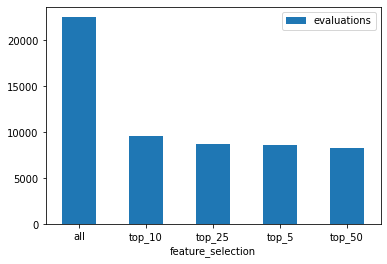

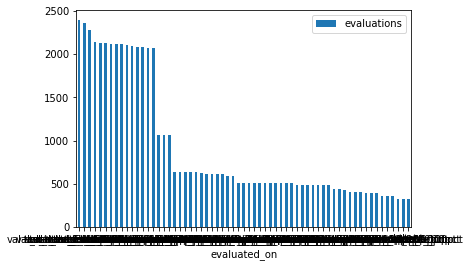

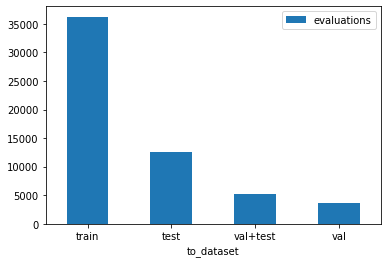

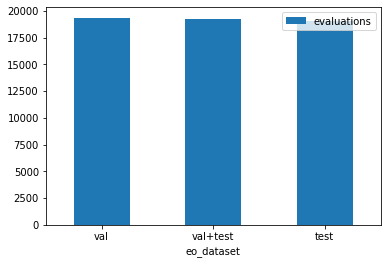

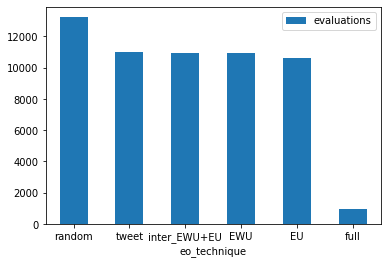

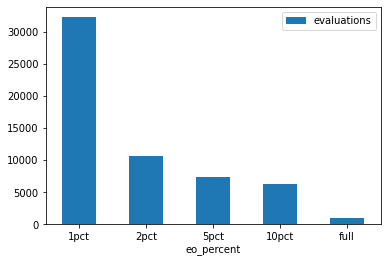

In [20]:
# https://prnt.sc/baA8bojyEWrc
loc_dict_lmt = {
    "eo_dataset": ["val", "test", "val+test",],
}

prauc_lmt = loc_by_dict(prauc, filters=loc_dict_lmt)
rce_lmt = loc_by_dict(rce, filters=loc_dict_lmt)
custom_prauc_rce_display(prauc_lmt, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

In [21]:
lmt_prauc_dict_paired, lmt_prauc_counts = get_common_factor_combinations(prauc_lmt, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
display(lmt_prauc_counts)

df = lmt_prauc_dict_paired["evaluated_on"]["react"]
withins = ["algorithm", "note", "feature_selection", "trained_on", "to_dataset", "to_technique", "to_percent"]

for col in withins:
    print(f"{col} in lmt balanced for evaluated_on and react")
    cross_tab = pd.crosstab(index=df["evaluated_on"], columns=df[col], margins=False)
    print(cross_tab.sum())
    display(cross_tab.head(2))  # https://prnt.sc/on62TG6DPj6r, https://prnt.sc/f-7Q1Hbh5iG7
    if col in lmt_prauc_dict_paired.keys():
        print(f"{col} in lmt balanced for {col} and react")
        cross_tab = pd.crosstab(index=lmt_prauc_dict_paired[col]["react"]["evaluated_on"], columns=lmt_prauc_dict_paired[col]["react"][col], margins=False) 
        print(cross_tab.sum())
        display(cross_tab.head(2)) 
        
    print("________________________________")

factor        calculated_dt  \
0             algorithm  16.05.2023 20:51:21   
1                  note  16.05.2023 20:51:24   
2     feature_selection  16.05.2023 20:51:26   
3            trained_on  16.05.2023 20:51:28   
4            to_dataset  16.05.2023 20:51:30   
5          to_technique  16.05.2023 20:51:32   
6            to_percent  16.05.2023 20:51:34   
7          evaluated_on  16.05.2023 20:51:36   
8                target  16.05.2023 20:51:39   
9  all factors combined  16.05.2023 20:51:41   

                                              values  common_counts   like  \
0   [GradientBoosting, bayes, forest, lr, svc, tree]            546    366   
1                            [oracle_scaled, scaled]           4984   1016   
2               [all, top_10, top_25, top_5, top_50]          36000   7770   
3                                                 []              0      0   
4                                                 []              0      0   
5                                                 []              0      0   
6                                                 []              0      0   
7  [test, test_EU_sample_10pct, test_EU_sample_1p...          19908   4095   
8               [like, reply, retweet, quote, react]          54730  10946   
9                               all factors combined              0      0   

   reply  retweet  quote  react  
0    126       18     18     18  
1    992      992    992    992  
2   7150     7135   7130   6815  
3      0        0      0      0  
4      0        0      0      0  
5      0        0      0      0  
6      0        0      0      0  
7   3969     3969   3969   3906  
8  10946    10946  10946  10946  
9      0        0      0      0

algorithm in lmt balanced for evaluated_on and react
algorithm
GradientBoosting     756
bayes               1134
forest              1071
tree                 945
dtype: int64


algorithm             GradientBoosting  bayes  forest  tree
evaluated_on                                               
test                                12     18      17    15
test_EU_sample_10pct                12     18      17    15

algorithm in lmt balanced for algorithm and react
algorithm
GradientBoosting    3
bayes               3
forest              3
lr                  3
svc                 3
tree                3
dtype: int64


algorithm               GradientBoosting  bayes  forest  lr  svc  tree
evaluated_on                                                          
val_random_sample_1pct                 3      3       3   3    3     3

________________________________
note in lmt balanced for evaluated_on and react
note
scaled    3906
dtype: int64


note                  scaled
evaluated_on                
test                      62
test_EU_sample_10pct      62

note in lmt balanced for note and react
note
oracle_scaled    496
scaled           496
dtype: int64


note                  oracle_scaled  scaled
evaluated_on                               
test_EU_sample_1pct              30      30
test_EWU_sample_1pct             31      31

________________________________
feature_selection in lmt balanced for evaluated_on and react
feature_selection
all       2205
top_10     441
top_25     441
top_5      441
top_50     378
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                   35       7       7      7       6
test_EU_sample_10pct   35       7       7      7       6

feature_selection in lmt balanced for feature_selection and react
feature_selection
all       1363
top_10    1363
top_25    1363
top_5     1363
top_50    1363
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                    4       4       4      4       4
test_EU_sample_10pct    6       6       6      6       6

________________________________
trained_on in lmt balanced for evaluated_on and react
trained_on
train_EU_sample_10pct               819
train_EU_sample_1pct               1197
train_EU_sample_2pct                252
train_EU_sample_5pct                252
train_EWU_sample_10pct              189
train_EWU_sample_1pct               252
train_EWU_sample_2pct               252
train_EWU_sample_5pct               252
train_inter_EWU+EU_sample_10pct      63
train_inter_EWU+EU_sample_1pct      252
train_inter_EWU+EU_sample_2pct      126
dtype: int64


trained_on            train_EU_sample_10pct  train_EU_sample_1pct  \
evaluated_on                                                        
test                                     13                    19   
test_EU_sample_10pct                     13                    19   

trained_on            train_EU_sample_2pct  train_EU_sample_5pct  \
evaluated_on                                                       
test                                     4                     4   
test_EU_sample_10pct                     4                     4   

trained_on            train_EWU_sample_10pct  train_EWU_sample_1pct  \
evaluated_on                                                          
test                                       3                      4   
test_EU_sample_10pct                       3                      4   

trained_on            train_EWU_sample_2pct  train_EWU_sample_5pct  \
evaluated_on                                                         
test                                      4                      4   
test_EU_sample_10pct                      4                      4   

trained_on            train_inter_EWU+EU_sample_10pct  \
evaluated_on                                            
test                                                1   
test_EU_sample_10pct                                1   

trained_on            train_inter_EWU+EU_sample_1pct  \
evaluated_on                                           
test                                               4   
test_EU_sample_10pct                               4   

trained_on            train_inter_EWU+EU_sample_2pct  
evaluated_on                                          
test                                               2  
test_EU_sample_10pct                               2

trained_on in lmt balanced for trained_on and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_dataset in lmt balanced for evaluated_on and react
to_dataset
train    3906
dtype: int64


to_dataset            train
evaluated_on               
test                     62
test_EU_sample_10pct     62

to_dataset in lmt balanced for to_dataset and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_technique in lmt balanced for evaluated_on and react
to_technique
EU              2520
EWU              945
inter_EWU+EU     441
dtype: int64


to_technique          EU  EWU  inter_EWU+EU
evaluated_on                               
test                  40   15             7
test_EU_sample_10pct  40   15             7

to_technique in lmt balanced for to_technique and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_percent in lmt balanced for evaluated_on and react
to_percent
10pct    1071
1pct     1701
2pct      630
5pct      504
dtype: int64


to_percent            10pct  1pct  2pct  5pct
evaluated_on                                 
test                     17    27    10     8
test_EU_sample_10pct     17    27    10     8

to_percent in lmt balanced for to_percent and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________


In [22]:
for within in withins:
    friedman_prauc_reacht_lmt = pg.friedman(data=df, dv="evaluation", within=within, subject="evaluated_on", method="chisq")
    display(friedman_prauc_reacht_lmt)

Source         W  ddof1          Q         p-unc
Friedman  algorithm  0.488637      3  92.352381  6.842706e-20

C:\Users\Jovan\miniconda3\lib\site-packages\pingouin\nonparametric.py:715: RuntimeWarning: invalid value encountered in double_scalars
  W = (12 * ssbn - 3 * n**2 * k * (k + 1) ** 2) / (n**2 * k * (k - 1) * (k + 1) - n * ties)


Source   W  ddof1   Q  p-unc
Friedman   note NaN      0 NaN    NaN

Source         W  ddof1           Q         p-unc
Friedman  feature_selection  0.574049      4  144.660317  2.835919e-30

Source         W  ddof1           Q         p-unc
Friedman  trained_on  0.605854     10  381.688312  7.397595e-76

C:\Users\Jovan\miniconda3\lib\site-packages\pingouin\nonparametric.py:715: RuntimeWarning: invalid value encountered in double_scalars
  W = (12 * ssbn - 3 * n**2 * k * (k + 1) ** 2) / (n**2 * k * (k - 1) * (k + 1) - n * ties)


Source   W  ddof1   Q  p-unc
Friedman  to_dataset NaN      0 NaN    NaN

Source         W  ddof1         Q         p-unc
Friedman  to_technique  0.535903      2  67.52381  2.174658e-15

Source         W  ddof1          Q         p-unc
Friedman  to_percent  0.510204      3  96.428571  9.105010e-21

### First Round 

Now, we are going to limit the evaluations to only those calculated in the first round of evaluations.

____16.05.2023 20:51:41____

Read final evals for _PRAUC of shape (35790, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (35790, 13), of that non-nans for evaluation=35357.
Present algorithms in _PRAUC


evaluations
algorithm                    
forest                  10890
bayes                    9930
GradientBoosting         7680
tree                     7290

Present notes in _PRAUC


evaluations
note                      
scaled               35190
oracle_scaled          600

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                      14550
top_10                    5385
top_25                    5385
top_5                     5385
top_50                    5085

Present trained_ons in _PRAUC


evaluations
trained_on                                  
train_EU_sample_1pct                    6000
train_EU_sample_10pct                   4425
train_EWU_sample_2pct                   2460
train_EU_sample_2pct                    2460
train_inter_EWU+EU_sample_1pct          2370
train_EWU_sample_1pct                   2280
train_inter_EWU+EU_sample_2pct          2160
train_random_sample_1pct                1965
train_random_sample_2pct                1950
train_EWU_sample_5pct                   1500
train_EU_sample_5pct                    1500
train_tweet_sample_2pct                 1440
train_tweet_sample_1pct                 1215
train_inter_EWU+EU_sample_10pct         1125
train_EWU_sample_10pct                  1125
train_random_sample_5pct                 690
train_inter_EWU+EU_sample_5pct           300
train_random_sample_10pct                300
train_tweet_sample_5pct                  300
train_tweet_sample_10pct                 225

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
test_tweet_sample_1pct                     1070
val+test_tweet_sample_1pct                 1070
val_tweet_sample_1pct                      1070
test_EWU_sample_1pct                       1065
val_inter_EWU+EU_sample_1pct               1065
val+test_EWU_sample_1pct                   1065
test_inter_EWU+EU_sample_1pct              1065
val+test_inter_EWU+EU_sample_1pct          1065
val_EWU_sample_1pct                        1065
val+test_EU_sample_1pct                    1050
val_EU_sample_1pct                         1050
test_EU_sample_1pct                        1050
val_random_sample_1pct                     1045
test_random_sample_1pct                    1045
val+test_random_sample_1pct                1045
val_random_sample_2pct                      585
test_random_sample_2pct                     585
val+test_random_sample_2pct                 585
val+test_random_sample_10pct                430
val+test_inter_EWU+EU_sample_5pct           430
val+test_tweet_sample_2pct                  430
val+test_tweet_sample_5pct                  430
val_tweet_sample_5pct                       430
test_inter_EWU+EU_sample_5pct               430
test_random_sample_10pct                    430
val_tweet_sample_2pct                       430
val_random_sample_5pct                      430
val_random_sample_10pct                     430
val_inter_EWU+EU_sample_5pct                430
val+test_random_sample_5pct                 430
test_random_sample_5pct                     430
test_tweet_sample_2pct                      430
test_tweet_sample_5pct                      430
test_inter_EWU+EU_sample_2pct               415
val_inter_EWU+EU_sample_2pct                415
val+test_inter_EWU+EU_sample_2pct           415
val_EWU_sample_2pct                         410
val_EU_sample_2pct                          410
val_EU_sample_5pct                          410
val_EWU_sample_5pct                         410
val+test_EWU_sample_5pct                    410
test_EWU_sample_5pct                        410
val+test_EWU_sample_2pct                    410
test_EU_sample_2pct                         410
val+test_EU_sample_5pct                     410
test_EU_sample_5pct                         410
val+test_EU_sample_2pct                     410
test_EWU_sample_2pct                        410
val+test_tweet_sample_10pct                 405
val_tweet_sample_10pct                      405
test_tweet_sample_10pct                     405
val_inter_EWU+EU_sample_10pct               390
val+test_inter_EWU+EU_sample_10pct          390
test_inter_EWU+EU_sample_10pct              390
test_EWU_sample_10pct                       390
val_EWU_sample_10pct                        390
val+test_EWU_sample_10pct                   390
val+test_EU_sample_10pct                    335
val_EU_sample_10pct                         335
test_EU_sample_10pct                        335
val                                         325
val+test                                    325
test                                        325

Present to_datasets in _PRAUC


evaluations
to_dataset             
train             35790

Present to_techniques in _PRAUC


evaluations
to_technique             
EU                  14385
EWU                  7365
inter_EWU+EU         5955
random               4905
tweet                3180

Present to_percents in _PRAUC


evaluations
to_percent             
1pct              13830
2pct              10470
10pct              7200
5pct               4290

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
test              11930
val+test          11930
val               11930

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random               7470
tweet                7005
inter_EWU+EU         6900
EWU                  6825
EU                   6615
full                  975

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct              15885
2pct               6750
5pct               6330
10pct              5850
full                975

algorithm    note feature_selection             trained_on to_dataset  \
12490     bayes  scaled               all  train_EU_sample_10pct      train   
12491     bayes  scaled               all  train_EU_sample_10pct      train   
12492     bayes  scaled               all  train_EU_sample_10pct      train   
12493     bayes  scaled               all  train_EU_sample_10pct      train   
12494     bayes  scaled               all  train_EU_sample_10pct      train   

      to_technique to_percent          evaluated_on eo_dataset eo_technique  \
12490           EU      10pct  test_EU_sample_10pct       test           EU   
12491           EU      10pct  test_EU_sample_10pct       test           EU   
12492           EU      10pct  test_EU_sample_10pct       test           EU   
12493           EU      10pct  test_EU_sample_10pct       test           EU   
12494           EU      10pct  test_EU_sample_10pct       test           EU   

      eo_percent   target  evaluation  
12490      10pct     like    0.679306  
12491      10pct    reply    0.368943  
12492      10pct  retweet    0.433508  
12493      10pct    quote    0.295560  
12494      10pct    react    0.719809

________



algorithm    note feature_selection             trained_on to_dataset  \
12490     bayes  scaled               all  train_EU_sample_10pct      train   
12491     bayes  scaled               all  train_EU_sample_10pct      train   
12492     bayes  scaled               all  train_EU_sample_10pct      train   
12493     bayes  scaled               all  train_EU_sample_10pct      train   
12494     bayes  scaled               all  train_EU_sample_10pct      train   

      to_technique to_percent          evaluated_on eo_dataset eo_technique  \
12490           EU      10pct  test_EU_sample_10pct       test           EU   
12491           EU      10pct  test_EU_sample_10pct       test           EU   
12492           EU      10pct  test_EU_sample_10pct       test           EU   
12493           EU      10pct  test_EU_sample_10pct       test           EU   
12494           EU      10pct  test_EU_sample_10pct       test           EU   

      eo_percent   target  evaluation  
12490      10pct     like    0.679306  
12491      10pct    reply    0.368943  
12492      10pct  retweet    0.433508  
12493      10pct    quote    0.295560  
12494      10pct    react    0.719809

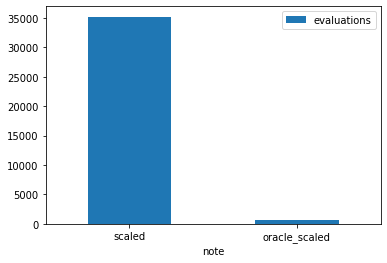

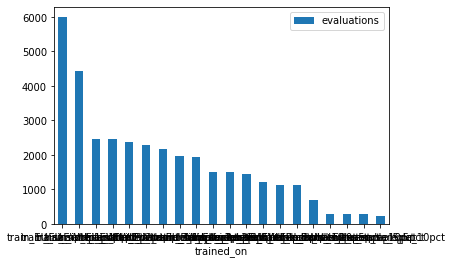

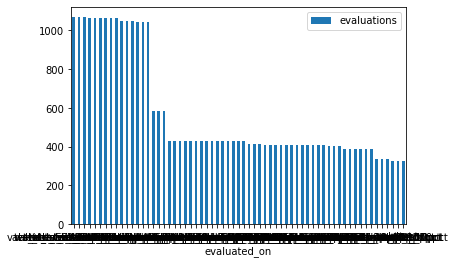

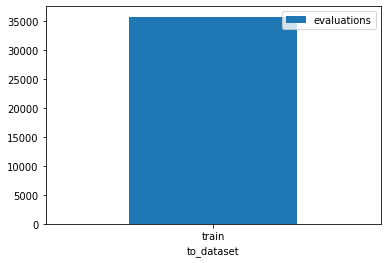

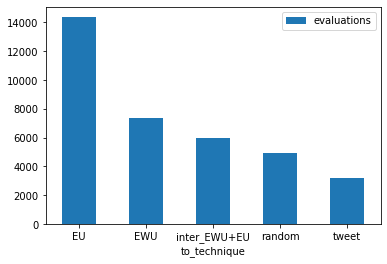

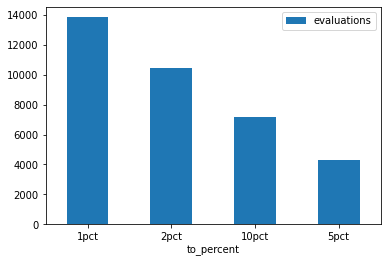

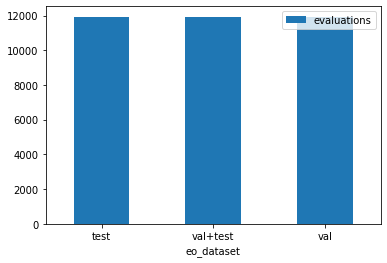

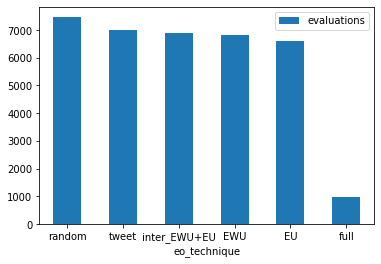

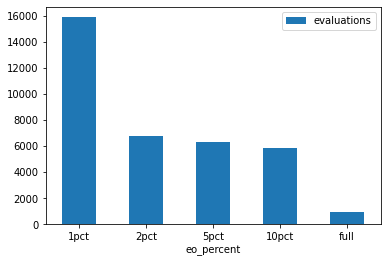

In [23]:
# https://prnt.sc/baA8bojyEWrc
loc_dict_r1 = {
    "algorithm": ["bayes", "forest", "tree", "GradientBoosting",],
    "to_dataset": ['train',],
    "eo_dataset": ["val", "test", "val+test",],
}

prauc_r1 = loc_by_dict(prauc, filters=loc_dict_r1)
rce_r1 = loc_by_dict(prauc, filters=loc_dict_r1)
custom_prauc_rce_display(prauc_r1, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

In [24]:
r1_prauc_dict_paired, r1_prauc_counts = get_common_factor_combinations(prauc_r1, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
r1_rce_dict_paired, r1_rce_counts = get_common_factor_combinations(rce_r1, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
df = r1_prauc_dict_paired["evaluated_on"]["react"]
r1_prauc_counts

factor        calculated_dt  \
0             algorithm  16.05.2023 20:51:45   
1                  note  16.05.2023 20:51:46   
2     feature_selection  16.05.2023 20:51:47   
3            trained_on  16.05.2023 20:51:49   
4            to_dataset  16.05.2023 20:51:50   
5          to_technique  16.05.2023 20:51:51   
6            to_percent  16.05.2023 20:51:53   
7          evaluated_on  16.05.2023 20:51:54   
8                target  16.05.2023 20:51:55   
9  all factors combined  16.05.2023 20:51:57   

                                              values  common_counts  like  \
0            [GradientBoosting, bayes, forest, tree]          19308  3912   
1                            [oracle_scaled, scaled]           1200   240   
2               [all, top_10, top_25, top_5, top_50]          23320  4785   
3                                                 []              0     0   
4                                            [train]          35357  7158   
5                                                 []              0     0   
6                                                 []              0     0   
7  [test, test_EU_sample_10pct, test_EU_sample_1p...          19908  4095   
8               [like, reply, retweet, quote, react]          34435  6887   
9                               all factors combined              0     0   

   reply  retweet  quote  react  
0   3876     3840   3840   3840  
1    240      240    240    240  
2   4730     4710   4700   4395  
3      0        0      0      0  
4   7135     7100   7076   6888  
5      0        0      0      0  
6      0        0      0      0  
7   3969     3969   3969   3906  
8   6887     6887   6887   6887  
9      0        0      0      0

In [25]:
for col in withins:
    print(f"{col} in r1 balanced for evaluated_on and react")
    cross_tab = pd.crosstab(index=df["evaluated_on"], columns=df[col],margins=False)
    print(cross_tab.sum())
    display(cross_tab.head(2))  # https://prnt.sc/on62TG6DPj6r, https://prnt.sc/f-7Q1Hbh5iG7
    if col in r1_rce_dict_paired.keys():
        print(f"{col} in r1 balanced for {col} and react")
        cross_tab = pd.crosstab(index=r1_rce_dict_paired[col]["react"]["evaluated_on"], columns=r1_rce_dict_paired[col]["react"][col], margins=False)
        print(cross_tab.sum()) 
        display(cross_tab.head(2))
    
    print("________________________________")

algorithm in r1 balanced for evaluated_on and react
algorithm
GradientBoosting     756
bayes               1134
forest              1071
tree                 945
dtype: int64


algorithm             GradientBoosting  bayes  forest  tree
evaluated_on                                               
test                                12     18      17    15
test_EU_sample_10pct                12     18      17    15

algorithm in r1 balanced for algorithm and react
algorithm
GradientBoosting    960
bayes               960
forest              960
tree                960
dtype: int64


algorithm             GradientBoosting  bayes  forest  tree
evaluated_on                                               
test                                10     10      10    10
test_EU_sample_10pct                10     10      10    10

________________________________
note in r1 balanced for evaluated_on and react
note
scaled    3906
dtype: int64


note                  scaled
evaluated_on                
test                      62
test_EU_sample_10pct      62

note in r1 balanced for note and react
note
oracle_scaled    120
scaled           120
dtype: int64


note                  oracle_scaled  scaled
evaluated_on                               
test_EU_sample_1pct               8       8
test_EWU_sample_1pct              8       8

________________________________
feature_selection in r1 balanced for evaluated_on and react
feature_selection
all       2205
top_10     441
top_25     441
top_5      441
top_50     378
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                   35       7       7      7       6
test_EU_sample_10pct   35       7       7      7       6

feature_selection in r1 balanced for feature_selection and react
feature_selection
all       879
top_10    879
top_25    879
top_5     879
top_50    879
dtype: int64


feature_selection     all  top_10  top_25  top_5  top_50
evaluated_on                                            
test                    4       4       4      4       4
test_EU_sample_10pct    6       6       6      6       6

________________________________
trained_on in r1 balanced for evaluated_on and react
trained_on
train_EU_sample_10pct               819
train_EU_sample_1pct               1197
train_EU_sample_2pct                252
train_EU_sample_5pct                252
train_EWU_sample_10pct              189
train_EWU_sample_1pct               252
train_EWU_sample_2pct               252
train_EWU_sample_5pct               252
train_inter_EWU+EU_sample_10pct      63
train_inter_EWU+EU_sample_1pct      252
train_inter_EWU+EU_sample_2pct      126
dtype: int64


trained_on            train_EU_sample_10pct  train_EU_sample_1pct  \
evaluated_on                                                        
test                                     13                    19   
test_EU_sample_10pct                     13                    19   

trained_on            train_EU_sample_2pct  train_EU_sample_5pct  \
evaluated_on                                                       
test                                     4                     4   
test_EU_sample_10pct                     4                     4   

trained_on            train_EWU_sample_10pct  train_EWU_sample_1pct  \
evaluated_on                                                          
test                                       3                      4   
test_EU_sample_10pct                       3                      4   

trained_on            train_EWU_sample_2pct  train_EWU_sample_5pct  \
evaluated_on                                                         
test                                      4                      4   
test_EU_sample_10pct                      4                      4   

trained_on            train_inter_EWU+EU_sample_10pct  \
evaluated_on                                            
test                                                1   
test_EU_sample_10pct                                1   

trained_on            train_inter_EWU+EU_sample_1pct  \
evaluated_on                                           
test                                               4   
test_EU_sample_10pct                               4   

trained_on            train_inter_EWU+EU_sample_2pct  
evaluated_on                                          
test                                               2  
test_EU_sample_10pct                               2

trained_on in r1 balanced for trained_on and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_dataset in r1 balanced for evaluated_on and react
to_dataset
train    3906
dtype: int64


to_dataset            train
evaluated_on               
test                     62
test_EU_sample_10pct     62

to_dataset in r1 balanced for to_dataset and react
to_dataset
train    6888
dtype: int64


to_dataset            train
evaluated_on               
test                     62
test_EU_sample_10pct     65

________________________________
to_technique in r1 balanced for evaluated_on and react
to_technique
EU              2520
EWU              945
inter_EWU+EU     441
dtype: int64


to_technique          EU  EWU  inter_EWU+EU
evaluated_on                               
test                  40   15             7
test_EU_sample_10pct  40   15             7

to_technique in r1 balanced for to_technique and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_percent in r1 balanced for evaluated_on and react
to_percent
10pct    1071
1pct     1701
2pct      630
5pct      504
dtype: int64


to_percent            10pct  1pct  2pct  5pct
evaluated_on                                 
test                     17    27    10     8
test_EU_sample_10pct     17    27    10     8

to_percent in r1 balanced for to_percent and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________


In [26]:
withins_1r = ["algorithm", "note", "feature_selection", "trained_on", "to_dataset", "to_technique", "to_percent"]
withins_1r.remove("note")
withins_1r.remove("to_dataset")
withins_1r

['algorithm', 'feature_selection', 'trained_on', 'to_technique', 'to_percent']

In [27]:
for within in withins_1r:
    friedman_prauc_reacht_1r = pg.friedman(data=df, dv="evaluation", within=within, subject="evaluated_on", method="chisq")
    display(friedman_prauc_reacht_1r)

Source         W  ddof1          Q         p-unc
Friedman  algorithm  0.488637      3  92.352381  6.842706e-20

Source         W  ddof1           Q         p-unc
Friedman  feature_selection  0.574049      4  144.660317  2.835919e-30

Source         W  ddof1           Q         p-unc
Friedman  trained_on  0.605854     10  381.688312  7.397595e-76

Source         W  ddof1         Q         p-unc
Friedman  to_technique  0.535903      2  67.52381  2.174658e-15

Source         W  ddof1          Q         p-unc
Friedman  to_percent  0.510204      3  96.428571  9.105010e-21

In [28]:
for within in withins_1r:
    if within in r1_rce_dict_paired.keys():
        data = r1_rce_dict_paired[within]["react"]
        friedman_prauc_reacht_1r = pg.friedman(data=data, dv="evaluation", within=within, subject="evaluated_on", method="chisq")
        display(friedman_prauc_reacht_1r)

Source         W  ddof1          Q         p-unc
Friedman  algorithm  0.528143      3  99.819048  1.699821e-21

Source         W  ddof1           Q         p-unc
Friedman  feature_selection  0.439809      4  110.831746  4.837193e-23

C:\Users\Jovan\miniconda3\lib\site-packages\pingouin\nonparametric.py:715: RuntimeWarning: invalid value encountered in double_scalars
  W = (12 * ssbn - 3 * n**2 * k * (k + 1) ** 2) / (n**2 * k * (k - 1) * (k + 1) - n * ties)


Source   W  ddof1   Q  p-unc
Friedman  trained_on NaN     -1 NaN    NaN

C:\Users\Jovan\miniconda3\lib\site-packages\pingouin\nonparametric.py:715: RuntimeWarning: invalid value encountered in double_scalars
  W = (12 * ssbn - 3 * n**2 * k * (k + 1) ** 2) / (n**2 * k * (k - 1) * (k + 1) - n * ties)


Source   W  ddof1   Q  p-unc
Friedman  to_technique NaN     -1 NaN    NaN

C:\Users\Jovan\miniconda3\lib\site-packages\pingouin\nonparametric.py:715: RuntimeWarning: invalid value encountered in double_scalars
  W = (12 * ssbn - 3 * n**2 * k * (k + 1) ** 2) / (n**2 * k * (k - 1) * (k + 1) - n * ties)


Source   W  ddof1   Q  p-unc
Friedman  to_percent NaN     -1 NaN    NaN

In [29]:
for within in withins_1r:
    pairwise_tests_1r = pg.pairwise_tests(data=df,
                                          dv="evaluation", 
                                          within=within, 
                                          subject="evaluated_on", 
                                          parametric=False, 
                                          alpha=0.5, 
                                          alternative="two-sided",
                                          nan_policy = "pairwise",
                                          return_desc = True,
                                          padjust="holm")
    display(pairwise_tests_1r)

Contrast                 A       B   mean(A)    std(A)   mean(B)  \
0  algorithm  GradientBoosting   bayes  0.671234  0.019855  0.636163   
1  algorithm  GradientBoosting  forest  0.671234  0.019855  0.693687   
2  algorithm  GradientBoosting    tree  0.671234  0.019855  0.672236   
3  algorithm             bayes  forest  0.636163  0.049958  0.693687   
4  algorithm             bayes    tree  0.636163  0.049958  0.672236   
5  algorithm            forest    tree  0.693687  0.013858  0.672236   

     std(B)  Paired  Parametric  W-val alternative         p-unc  \
0  0.049958    True       False  353.0   two-sided  7.437244e-06   
1  0.013858    True       False  133.0   two-sided  2.138545e-09   
2  0.021449    True       False  954.0   two-sided  7.141662e-01   
3  0.013858    True       False    0.0   two-sided  5.294431e-12   
4  0.021449    True       False   30.0   two-sided  2.200404e-11   
5  0.021449    True       False  190.0   two-sided  2.184827e-08   

         p-corr p-adjust    hedges  
0  1.487449e-05     holm  0.917020  
1  8.554179e-09     holm -1.303452  
2  7.141662e-01     holm -0.048178  
3  3.176659e-11     holm -1.559633  
4  1.100202e-10     holm -0.932650  
5  6.554482e-08     holm  1.180757

Contrast       A       B   mean(A)    std(A)   mean(B)    std(B)  \
0  feature_selection     all  top_10  0.691016  0.030327  0.602146  0.027443   
1  feature_selection     all  top_25  0.691016  0.030327  0.652976  0.031545   
2  feature_selection     all   top_5  0.691016  0.030327  0.635808  0.022181   
3  feature_selection     all  top_50  0.691016  0.030327  0.659980  0.026922   
4  feature_selection  top_10  top_25  0.602146  0.027443  0.652976  0.031545   
5  feature_selection  top_10   top_5  0.602146  0.027443  0.635808  0.022181   
6  feature_selection  top_10  top_50  0.602146  0.027443  0.659980  0.026922   
7  feature_selection  top_25   top_5  0.652976  0.031545  0.635808  0.022181   
8  feature_selection  top_25  top_50  0.652976  0.031545  0.659980  0.026922   
9  feature_selection   top_5  top_50  0.635808  0.022181  0.659980  0.026922   

   Paired  Parametric  W-val alternative         p-unc        p-corr p-adjust  \
0    True       False    0.0   two-sided  5.294431e-12  5.294431e-11     holm   
1    True       False   99.0   two-sided  4.981521e-10  3.195385e-09     holm   
2    True       False   97.0   two-sided  4.564835e-10  3.195385e-09     holm   
3    True       False  197.0   two-sided  2.876907e-08  1.150763e-07     holm   
4    True       False   52.0   two-sided  6.092420e-11  4.873936e-10     holm   
5    True       False   15.0   two-sided  1.084943e-11  9.764483e-11     holm   
6    True       False   97.0   two-sided  4.564835e-10  3.195385e-09     holm   
7    True       False  533.0   two-sided  1.160248e-03  2.320497e-03     holm   
8    True       False  732.0   two-sided  5.928125e-02  5.928125e-02     holm   
9    True       False  354.0   two-sided  7.679524e-06  2.303857e-05     holm   

     hedges  
0  3.054196  
1  1.221943  
2  2.065401  
3  1.075797  
4 -1.708800  
5 -1.340932  
6 -2.114573  
7  0.625787  
8 -0.237372  
9 -0.974026

Contrast                                A  \
0   trained_on            train_EU_sample_10pct   
1   trained_on            train_EU_sample_10pct   
2   trained_on            train_EU_sample_10pct   
3   trained_on            train_EU_sample_10pct   
4   trained_on            train_EU_sample_10pct   
5   trained_on            train_EU_sample_10pct   
6   trained_on            train_EU_sample_10pct   
7   trained_on            train_EU_sample_10pct   
8   trained_on            train_EU_sample_10pct   
9   trained_on            train_EU_sample_10pct   
10  trained_on             train_EU_sample_1pct   
11  trained_on             train_EU_sample_1pct   
12  trained_on             train_EU_sample_1pct   
13  trained_on             train_EU_sample_1pct   
14  trained_on             train_EU_sample_1pct   
15  trained_on             train_EU_sample_1pct   
16  trained_on             train_EU_sample_1pct   
17  trained_on             train_EU_sample_1pct   
18  trained_on             train_EU_sample_1pct   
19  trained_on             train_EU_sample_2pct   
20  trained_on             train_EU_sample_2pct   
21  trained_on             train_EU_sample_2pct   
22  trained_on             train_EU_sample_2pct   
23  trained_on             train_EU_sample_2pct   
24  trained_on             train_EU_sample_2pct   
25  trained_on             train_EU_sample_2pct   
26  trained_on             train_EU_sample_2pct   
27  trained_on             train_EU_sample_5pct   
28  trained_on             train_EU_sample_5pct   
29  trained_on             train_EU_sample_5pct   
30  trained_on             train_EU_sample_5pct   
31  trained_on             train_EU_sample_5pct   
32  trained_on             train_EU_sample_5pct   
33  trained_on             train_EU_sample_5pct   
34  trained_on           train_EWU_sample_10pct   
35  trained_on           train_EWU_sample_10pct   
36  trained_on           train_EWU_sample_10pct   
37  trained_on           train_EWU_sample_10pct   
38  trained_on           train_EWU_sample_10pct   
39  trained_on           train_EWU_sample_10pct   
40  trained_on            train_EWU_sample_1pct   
41  trained_on            train_EWU_sample_1pct   
42  trained_on            train_EWU_sample_1pct   
43  trained_on            train_EWU_sample_1pct   
44  trained_on            train_EWU_sample_1pct   
45  trained_on            train_EWU_sample_2pct   
46  trained_on            train_EWU_sample_2pct   
47  trained_on            train_EWU_sample_2pct   
48  trained_on            train_EWU_sample_2pct   
49  trained_on            train_EWU_sample_5pct   
50  trained_on            train_EWU_sample_5pct   
51  trained_on            train_EWU_sample_5pct   
52  trained_on  train_inter_EWU+EU_sample_10pct   
53  trained_on  train_inter_EWU+EU_sample_10pct   
54  trained_on   train_inter_EWU+EU_sample_1pct   

                                  B   mean(A)    std(A)   mean(B)    std(B)  \
0              train_EU_sample_1pct  0.681876  0.034278  0.626170  0.034547   
1              train_EU_sample_2pct  0.681876  0.034278  0.716248  0.016782   
2              train_EU_sample_5pct  0.681876  0.034278  0.701653  0.019861   
3            train_EWU_sample_10pct  0.681876  0.034278  0.681706  0.045990   
4             train_EWU_sample_1pct  0.681876  0.034278  0.662033  0.052248   
5             train_EWU_sample_2pct  0.681876  0.034278  0.689646  0.023651   
6             train_EWU_sample_5pct  0.681876  0.034278  0.668890  0.051772   
7   train_inter_EWU+EU_sample_10pct  0.681876  0.034278  0.651129  0.062320   
8    train_inter_EWU+EU_sample_1pct  0.681876  0.034278  0.700382  0.027702   
9    train_inter_EWU+EU_sample_2pct  0.681876  0.034278  0.684346  0.031943   
10             train_EU_sample_2pct  0.626170  0.034547  0.716248  0.016782   
11             train_EU_sample_5pct  0.626170  0.034547  0.701653  0.019861   
12           train_EWU_sample_10pct  0.626170  0.034547  0.681706  0.045990   
13            train_EWU_sample_1pct  0.6261

Contrast    A             B  mean(A)    std(A)   mean(B)    std(B)  \
0  to_technique   EU           EWU  0.66083  0.013858  0.675160  0.040924   
1  to_technique   EU  inter_EWU+EU  0.66083  0.013858  0.688764  0.033292   
2  to_technique  EWU  inter_EWU+EU  0.67516  0.040924  0.688764  0.033292   

   Paired  Parametric  W-val alternative         p-unc        p-corr p-adjust  \
0    True       False  505.0   two-sided  5.813547e-04  5.813547e-04     holm   
1    True       False  157.0   two-sided  5.793511e-09  1.158702e-08     holm   
2    True       False    0.0   two-sided  5.294431e-12  1.588329e-11     holm   

     hedges  
0 -0.466177  
1 -1.088841  
2 -0.362483

Contrast      A     B   mean(A)    std(A)   mean(B)    std(B)  Paired  \
0  to_percent  10pct  1pct  0.680037  0.033560  0.642477  0.026401    True   
1  to_percent  10pct  2pct  0.680037  0.033560  0.699227  0.022065    True   
2  to_percent  10pct  5pct  0.680037  0.033560  0.685272  0.034001    True   
3  to_percent   1pct  2pct  0.642477  0.026401  0.699227  0.022065    True   
4  to_percent   1pct  5pct  0.642477  0.026401  0.685272  0.034001    True   
5  to_percent   2pct  5pct  0.699227  0.022065  0.685272  0.034001    True   

   Parametric  W-val alternative         p-unc        p-corr p-adjust  \
0       False  289.0   two-sided  8.702045e-07  1.740409e-06     holm   
1       False   97.0   two-sided  4.564835e-10  1.825934e-09     holm   
2       False  785.0   two-sided  1.276941e-01  1.276941e-01     holm   
3       False   15.0   two-sided  1.084943e-11  6.509655e-11     holm   
4       False  132.0   two-sided  2.050387e-09  6.151161e-09     holm   
5       False   38.0   two-sided  3.194855e-11  1.597427e-10     holm   

     hedges  
0  1.236437  
1 -0.671590  
2 -0.154012  
3 -2.318373  
4 -1.397378  
5  0.483949

### Second Round 

Now, we are going to limit the evaluations to only those calculated in the second -- purely local -- round of evaluations.

____16.05.2023 20:52:12____

Read final evals for _PRAUC of shape (3310, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (3310, 13), of that non-nans for evaluation=3202.
Present algorithms in _PRAUC


evaluations
algorithm                    
bayes                    1110
forest                    965
GradientBoosting          540
tree                      515
lr                        120
svc                        60

Present notes in _PRAUC


evaluations
note                      
scaled                2700
oracle_scaled          610

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                       3310

Present trained_ons in _PRAUC


evaluations
trained_on                                 
train_random_sample_1pct                360
test_random_sample_1pct                 350
train_inter_EWU+EU_sample_1pct          300
train_EU_sample_1pct                    240
train_EU_sample_2pct                    240
train_EWU_sample_1pct                   240
train_EWU_sample_2pct                   240
train_random_sample_2pct                240
train_inter_EWU+EU_sample_2pct          225
test_random_sample_2pct                 180
test_inter_EWU+EU_sample_2pct           175
test_inter_EWU+EU_sample_1pct           160
test_EU_sample_1pct                      90
test_EU_sample_2pct                      90
test_EWU_sample_1pct                     90
test_EWU_sample_2pct                     90

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                  
test_random_sample_1pct                    370
val+test_random_sample_1pct                365
val_random_sample_1pct                     365
test_inter_EWU+EU_sample_1pct              350
val+test_inter_EWU+EU_sample_1pct          340
val_inter_EWU+EU_sample_1pct               340
test_random_sample_2pct                    255
val+test_random_sample_2pct                225
val_random_sample_2pct                     225
test_inter_EWU+EU_sample_2pct              175
val+test_inter_EWU+EU_sample_2pct          150
val_inter_EWU+EU_sample_2pct               150

Present to_datasets in _PRAUC


evaluations
to_dataset             
train              2085
test               1225

Present to_techniques in _PRAUC


evaluations
to_technique             
random               1130
inter_EWU+EU          860
EU                    660
EWU                   660

Present to_percents in _PRAUC


evaluations
to_percent             
1pct               1830
2pct               1480

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
test               1150
val+test           1080
val                1080

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random               1805
inter_EWU+EU         1505

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct               2130
2pct               1180

algorithm    note feature_selection           trained_on to_dataset  \
45     bayes  scaled               all  test_EU_sample_1pct       test   
46     bayes  scaled               all  test_EU_sample_1pct       test   
47     bayes  scaled               all  test_EU_sample_1pct       test   
48     bayes  scaled               all  test_EU_sample_1pct       test   
49     bayes  scaled               all  test_EU_sample_1pct       test   

   to_technique to_percent                   evaluated_on eo_dataset  \
45           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
46           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
47           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
48           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
49           EU       1pct  test_inter_EWU+EU_sample_1pct       test   

    eo_technique eo_percent   target  evaluation  
45  inter_EWU+EU       1pct     like    0.586241  
46  inter_EWU+EU       1pct    reply    0.512593  
47  inter_EWU+EU       1pct  retweet    0.549608  
48  inter_EWU+EU       1pct    quote    0.503410  
49  inter_EWU+EU       1pct    react    0.626989

________



algorithm    note feature_selection           trained_on to_dataset  \
45     bayes  scaled               all  test_EU_sample_1pct       test   
46     bayes  scaled               all  test_EU_sample_1pct       test   
47     bayes  scaled               all  test_EU_sample_1pct       test   
48     bayes  scaled               all  test_EU_sample_1pct       test   
49     bayes  scaled               all  test_EU_sample_1pct       test   

   to_technique to_percent                   evaluated_on eo_dataset  \
45           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
46           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
47           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
48           EU       1pct  test_inter_EWU+EU_sample_1pct       test   
49           EU       1pct  test_inter_EWU+EU_sample_1pct       test   

    eo_technique eo_percent   target  evaluation  
45  inter_EWU+EU       1pct     like    0.586241  
46  inter_EWU+EU       1pct    reply    0.512593  
47  inter_EWU+EU       1pct  retweet    0.549608  
48  inter_EWU+EU       1pct    quote    0.503410  
49  inter_EWU+EU       1pct    react    0.626989

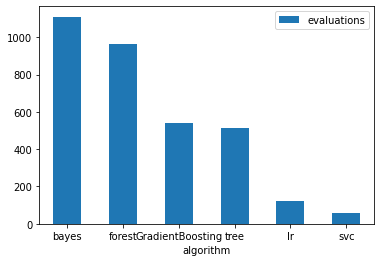

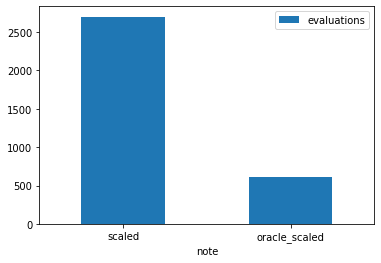

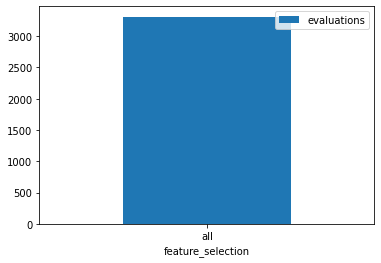

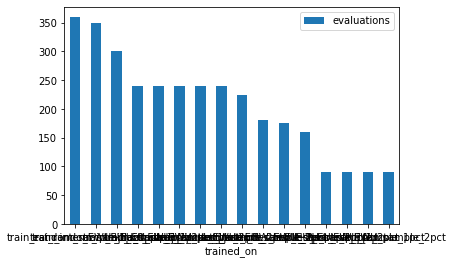

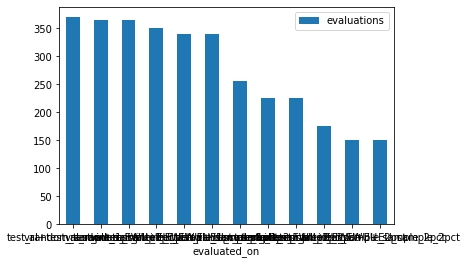

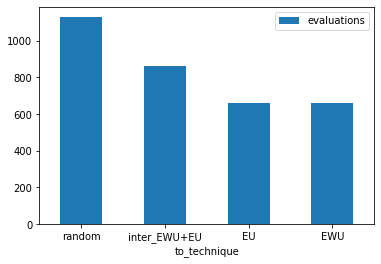

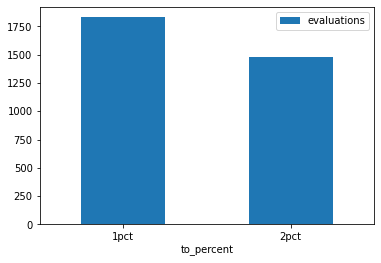

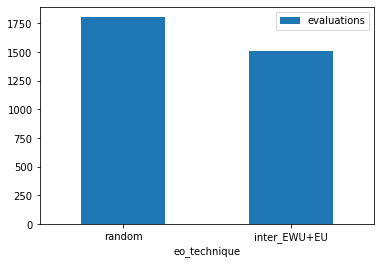

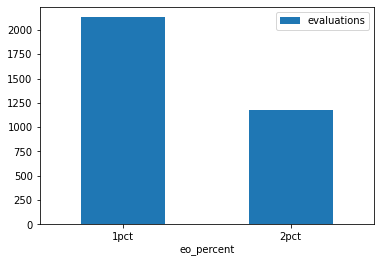

In [30]:
loc_dict_r2 = {
    "note": ['scaled', 'oracle_scaled'],
    "feature_selection": ['all',],
    "to_dataset": ["train", "test",],
    "to_percent": ['1pct', '2pct',],
    "to_technique": ["random", "EU", "EWU", "inter_EWU+EU"],
    "eo_percent": ['1pct', '2pct',],
    "eo_technique": ["random", "inter_EWU+EU"],
    "eo_dataset": ["val", "test", "val+test"],
}

prauc_r2 = loc_by_dict(prauc, filters=loc_dict_r2)
rce_r2 = loc_by_dict(rce, filters=loc_dict_r2)
custom_prauc_rce_display(prauc_r2, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

In [31]:
r2_prauc_dict_paired, r2_prauc_counts = get_common_factor_combinations(prauc_r2, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
r2_rce_dict_paired, r2_rce_counts = get_common_factor_combinations(rce_r2, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
display(r2_prauc_counts)
df = r2_rce_dict_paired["evaluated_on"]["react"]
withins=["algorithm", "note", "feature_selection", "trained_on", "to_dataset", "to_technique", "to_percent"]

for col in withins:
    print(f"{col} in r2 balanced for evaluated_on and react")
    cross_tab = pd.crosstab(index=df["evaluated_on"], columns=df[col],margins=False)
    print(cross_tab.sum())
    display(cross_tab.head(2))  # https://prnt.sc/on62TG6DPj6r, https://prnt.sc/f-7Q1Hbh5iG7
    if col in r2_rce_dict_paired.keys():
        print(f"{col} in r2 balanced for {col} and react")
        cross_tab = pd.crosstab(index=r2_rce_dict_paired[col]["react"]["evaluated_on"], columns=r2_rce_dict_paired[col]["react"][col], margins=False)
        print(cross_tab.sum()) 
        display(cross_tab.head(2))
    
    print("________________________________")

factor        calculated_dt  \
0             algorithm  16.05.2023 20:52:13   
1                  note  16.05.2023 20:52:13   
2     feature_selection  16.05.2023 20:52:13   
3            trained_on  16.05.2023 20:52:13   
4            to_dataset  16.05.2023 20:52:13   
5          to_technique  16.05.2023 20:52:13   
6            to_percent  16.05.2023 20:52:14   
7          evaluated_on  16.05.2023 20:52:14   
8                target  16.05.2023 20:52:14   
9  all factors combined  16.05.2023 20:52:14   

                                              values  common_counts  like  \
0   [GradientBoosting, bayes, forest, lr, svc, tree]             66    66   
1                            [oracle_scaled, scaled]           1062   224   
2                                              [all]           3202   661   
3                                                 []              0     0   
4                                                 []              0     0   
5                                                 []              0     0   
6                                                 []              0     0   
7  [test_inter_EWU+EU_sample_1pct, test_inter_EWU...           1740   348   
8               [like, reply, retweet, quote, react]           3145   629   
9                               all factors combined              0     0   

   reply  retweet  quote  react  
0      0        0      0      0  
1    208      210    210    210  
2    645      633    633    630  
3      0        0      0      0  
4      0        0      0      0  
5      0        0      0      0  
6      0        0      0      0  
7    348      348    348    348  
8    629      629    629    629  
9      0        0      0      0

algorithm in r2 balanced for evaluated_on and react
algorithm
GradientBoosting     72
bayes               144
forest               72
tree                 60
dtype: int64


algorithm                      GradientBoosting  bayes  forest  tree
evaluated_on                                                        
test_inter_EWU+EU_sample_1pct                 6     12       6     5
test_inter_EWU+EU_sample_2pct                 6     12       6     5

algorithm in r2 balanced for algorithm and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
note in r2 balanced for evaluated_on and react
note
scaled    348
dtype: int64


note                           scaled
evaluated_on                         
test_inter_EWU+EU_sample_1pct      29
test_inter_EWU+EU_sample_2pct      29

note in r2 balanced for note and react
note
oracle_scaled    105
scaled           105
dtype: int64


note                           oracle_scaled  scaled
evaluated_on                                        
test_inter_EWU+EU_sample_1pct             17      17
test_inter_EWU+EU_sample_2pct              3       3

________________________________
feature_selection in r2 balanced for evaluated_on and react
feature_selection
all    348
dtype: int64


feature_selection              all
evaluated_on                      
test_inter_EWU+EU_sample_1pct   29
test_inter_EWU+EU_sample_2pct   29

feature_selection in r2 balanced for feature_selection and react
feature_selection
all    630
dtype: int64


feature_selection              all
evaluated_on                      
test_inter_EWU+EU_sample_1pct   70
test_inter_EWU+EU_sample_2pct   35

________________________________
trained_on in r2 balanced for evaluated_on and react
trained_on
test_EU_sample_1pct               12
test_EU_sample_2pct               12
test_EWU_sample_1pct              12
test_EWU_sample_2pct              12
test_inter_EWU+EU_sample_1pct     12
test_inter_EWU+EU_sample_2pct     12
train_EU_sample_1pct              48
train_EU_sample_2pct              48
train_EWU_sample_1pct             48
train_EWU_sample_2pct             48
train_inter_EWU+EU_sample_1pct    48
train_inter_EWU+EU_sample_2pct    36
dtype: int64


trained_on                     test_EU_sample_1pct  test_EU_sample_2pct  \
evaluated_on                                                              
test_inter_EWU+EU_sample_1pct                    1                    1   
test_inter_EWU+EU_sample_2pct                    1                    1   

trained_on                     test_EWU_sample_1pct  test_EWU_sample_2pct  \
evaluated_on                                                                
test_inter_EWU+EU_sample_1pct                     1                     1   
test_inter_EWU+EU_sample_2pct                     1                     1   

trained_on                     test_inter_EWU+EU_sample_1pct  \
evaluated_on                                                   
test_inter_EWU+EU_sample_1pct                              1   
test_inter_EWU+EU_sample_2pct                              1   

trained_on                     test_inter_EWU+EU_sample_2pct  \
evaluated_on                                                   
test_inter_EWU+EU_sample_1pct                              1   
test_inter_EWU+EU_sample_2pct                              1   

trained_on                     train_EU_sample_1pct  train_EU_sample_2pct  \
evaluated_on                                                                
test_inter_EWU+EU_sample_1pct                     4                     4   
test_inter_EWU+EU_sample_2pct                     4                     4   

trained_on                     train_EWU_sample_1pct  train_EWU_sample_2pct  \
evaluated_on                                                                  
test_inter_EWU+EU_sample_1pct                      4                      4   
test_inter_EWU+EU_sample_2pct                      4                      4   

trained_on                     train_inter_EWU+EU_sample_1pct  \
evaluated_on                                                    
test_inter_EWU+EU_sample_1pct                               4   
test_inter_EWU+EU_sample_2pct                               4   

trained_on                     train_inter_EWU+EU_sample_2pct  
evaluated_on                                                   
test_inter_EWU+EU_sample_1pct                               3  
test_inter_EWU+EU_sample_2pct                               3

trained_on in r2 balanced for trained_on and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_dataset in r2 balanced for evaluated_on and react
to_dataset
test      72
train    276
dtype: int64


to_dataset                     test  train
evaluated_on                              
test_inter_EWU+EU_sample_1pct     6     23
test_inter_EWU+EU_sample_2pct     6     23

to_dataset in r2 balanced for to_dataset and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_technique in r2 balanced for evaluated_on and react
to_technique
EU              120
EWU             120
inter_EWU+EU    108
dtype: int64


to_technique                   EU  EWU  inter_EWU+EU
evaluated_on                                        
test_inter_EWU+EU_sample_1pct  10   10             9
test_inter_EWU+EU_sample_2pct  10   10             9

to_technique in r2 balanced for to_technique and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________
to_percent in r2 balanced for evaluated_on and react
to_percent
1pct    180
2pct    168
dtype: int64


to_percent                     1pct  2pct
evaluated_on                             
test_inter_EWU+EU_sample_1pct    15    14
test_inter_EWU+EU_sample_2pct    15    14

to_percent in r2 balanced for to_percent and react
Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: []

________________________________


Unfortunatelly, as we see above, we cannot test for whether the oracle features affect the result in a balanced manner, because there are no intersecting combinations (and there is no time to let them run to the end). So, we would have to run the tests on unbalanced eval_all datasets. But, given that we are working with only two gorups and can use MWU test, this is not a great issue.

____16.05.2023 20:52:15____

Read final evals for _PRAUC of shape (3820, 13) for data_to_be_cosidered=combined-.
_PRAUC shape: (3820, 13), of that non-nans for evaluation=3760.
Present algorithms in _PRAUC


evaluations
algorithm                    
forest                   1135
bayes                    1075
GradientBoosting          910
tree                      550
lr                        115
svc                        35

Present notes in _PRAUC


evaluations
note                      
scaled                3075
oracle_scaled          745

Present feature_selections in _PRAUC


evaluations
feature_selection             
all                       3820

Present trained_ons in _PRAUC


evaluations
trained_on                                 
train_inter_EWU+EU_sample_1pct         1445
train_inter_EWU+EU_sample_2pct         1055
train_random_sample_1pct                775
train_random_sample_2pct                545

Present evaluated_ons in _PRAUC


evaluations
evaluated_on                                   
val_random_sample_1pct                      130
val+test_random_sample_1pct                 130
test_random_sample_1pct                     130
val+test_inter_EWU+EU_sample_1pct           120
test_EU_sample_1pct                         120
val+test_tweet_sample_1pct                  120
val_EU_sample_1pct                          120
test_EWU_sample_1pct                        120
val+test_EWU_sample_1pct                    120
val_tweet_sample_1pct                       120
val_EWU_sample_1pct                         120
test_inter_EWU+EU_sample_1pct               120
val+test_EU_sample_1pct                     120
val_inter_EWU+EU_sample_1pct                120
test_tweet_sample_1pct                      120
val+test_random_sample_2pct                  85
test_random_sample_2pct                      85
val_random_sample_2pct                       85
train_random_sample_1pct                     55
val_inter_EWU+EU_sample_2pct                 40
val+test_inter_EWU+EU_sample_2pct            40
test_inter_EWU+EU_sample_2pct                40
val_tweet_sample_2pct                        35
train_inter_EWU+EU_sample_2pct               35
val+test_tweet_sample_2pct                   35
val+test_tweet_sample_5pct                   35
val_EU_sample_10pct                          35
val_tweet_sample_5pct                        35
val_EU_sample_2pct                           35
val_EWU_sample_10pct                         35
val_EU_sample_5pct                           35
val_random_sample_10pct                      35
val_tweet_sample_10pct                       35
val_EWU_sample_2pct                          35
val_EWU_sample_5pct                          35
val_inter_EWU+EU_sample_10pct                35
val_random_sample_5pct                       35
val+test_tweet_sample_10pct                  35
val_inter_EWU+EU_sample_5pct                 35
train_random_sample_2pct                     35
val+test_random_sample_5pct                  35
test_tweet_sample_5pct                       35
test_EU_sample_2pct                          35
test_EU_sample_5pct                          35
test_EWU_sample_10pct                        35
test_EWU_sample_2pct                         35
test_EWU_sample_5pct                         35
test_inter_EWU+EU_sample_10pct               35
test_inter_EWU+EU_sample_5pct                35
test_random_sample_10pct                     35
test_random_sample_5pct                      35
test_tweet_sample_10pct                      35
test_tweet_sample_2pct                       35
train_inter_EWU+EU_sample_1pct               35
val+test_random_sample_10pct                 35
val+test_EU_sample_10pct                     35
val+test_EU_sample_2pct                      35
val+test_EU_sample_5pct                      35
val+test_EWU_sample_10pct                    35
val+test_EWU_sample_2pct                     35
val+test_EWU_sample_5pct                     35
val+test_inter_EWU+EU_sample_10pct           35
test_EU_sample_10pct                         35
val+test_inter_EWU+EU_sample_5pct            35
val                                          30
val+test                                     30
test                                         30

Present to_datasets in _PRAUC


evaluations
to_dataset             
train              3820

Present to_techniques in _PRAUC


evaluations
to_technique             
inter_EWU+EU         2500
random               1320

Present to_percents in _PRAUC


evaluations
to_percent             
1pct               2220
2pct               1600

Present eo_datasets in _PRAUC


evaluations
eo_dataset             
test               1220
val                1220
val+test           1220
train               160

Present eo_techniques in _PRAUC


evaluations
eo_technique             
random                945
inter_EWU+EU          760
EU                    675
EWU                   675
tweet                 675
full                   90

Present eo_percents in _PRAUC


evaluations
eo_percent             
1pct               1920
2pct                760
10pct               525
5pct                525
full                 90

algorithm    note feature_selection  \
36344  GradientBoosting  scaled               all   
36345  GradientBoosting  scaled               all   
36346  GradientBoosting  scaled               all   
36347  GradientBoosting  scaled               all   
36348  GradientBoosting  scaled               all   

                           trained_on to_dataset  to_technique to_percent  \
36344  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36345  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36346  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36347  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36348  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   

      evaluated_on eo_dataset eo_technique eo_percent   target  evaluation  
36344         test       test         full       full     like    0.703686  
36345         test       test         full       full    reply    0.286443  
36346         test       test         full       full  retweet    0.437518  
36347         test       test         full       full    quote    0.503453  
36348         test       test         full       full    react    0.741553

________



algorithm    note feature_selection  \
36344  GradientBoosting  scaled               all   
36345  GradientBoosting  scaled               all   
36346  GradientBoosting  scaled               all   
36347  GradientBoosting  scaled               all   
36348  GradientBoosting  scaled               all   

                           trained_on to_dataset  to_technique to_percent  \
36344  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36345  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36346  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36347  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36348  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   

      evaluated_on eo_dataset eo_technique eo_percent   target  evaluation  
36344         test       test         full       full     like    0.703686  
36345         test       test         full       full    reply    0.286443  
36346         test       test         full       full  retweet    0.437518  
36347         test       test         full       full    quote    0.503453  
36348         test       test         full       full    react    0.741553

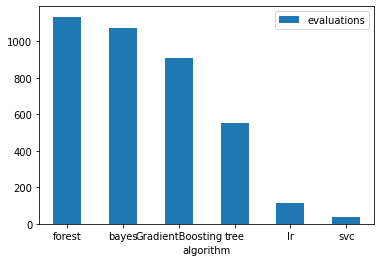

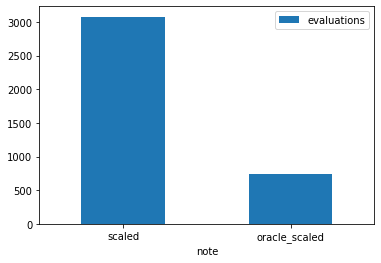

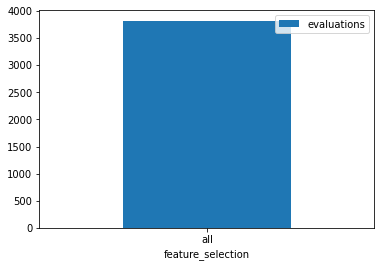

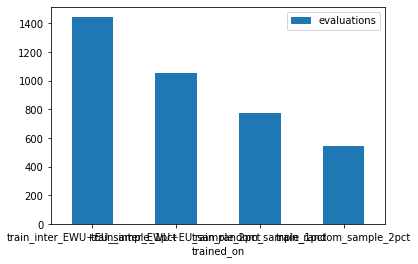

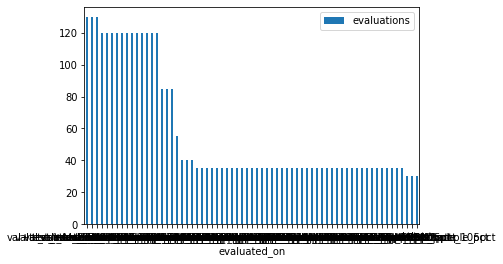

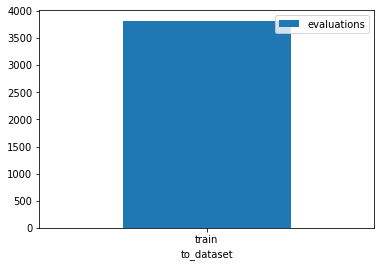

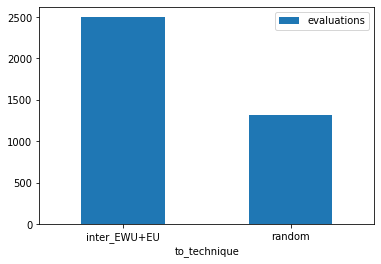

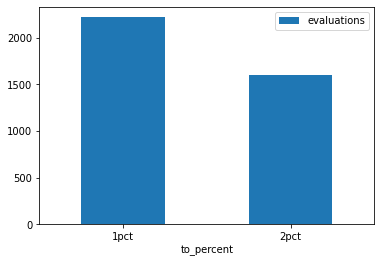

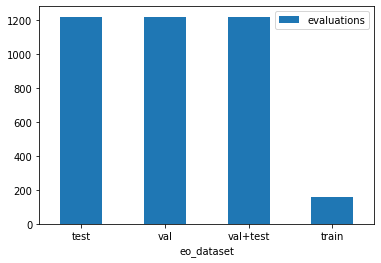

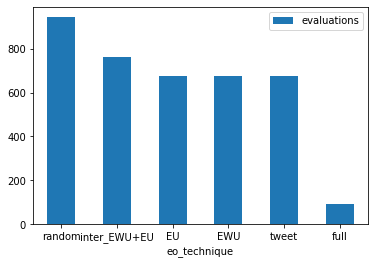

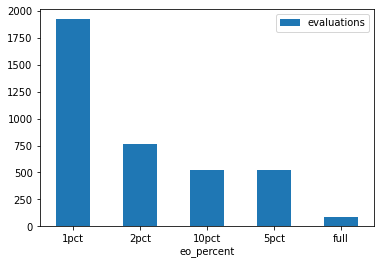

In [32]:
loc_dict_jn = {
    "note": ['scaled', 'oracle_scaled'],
    "feature_selection": ['all',],
    "to_dataset": ["train",],
    "to_percent": ['1pct', '2pct',],
    "to_technique": ["random", "inter_EWU+EU"],
}

prauc_jn = loc_by_dict(prauc, filters=loc_dict_jn)
rce_jn = loc_by_dict(rce, filters=loc_dict_jn)
custom_prauc_rce_display(prauc_jn, None, data_to_be_cosidered=DATA_TO_BE_CONSIDERED, flatten=True, print_progress=CALCULATE_STEPS)

In [33]:
jn_prauc_dict_paired, jn_prauc_counts = get_common_factor_combinations(prauc_jn, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
jn_rce_dict_paired, jn_rce_counts = get_common_factor_combinations(rce_jn, target_col = "target", look_at_all_together=True, return_found_counts=True, print_progress=False)
display(jn_prauc_counts)
df = jn_rce_dict_paired["note"]["react"]
display(df)

cross_tab = pd.crosstab(index=df["evaluated_on"], columns=df["note"], margins=False)
cross_tab

factor        calculated_dt  \
0             algorithm  16.05.2023 20:52:17   
1                  note  16.05.2023 20:52:17   
2     feature_selection  16.05.2023 20:52:17   
3            trained_on  16.05.2023 20:52:17   
4            to_dataset  16.05.2023 20:52:18   
5          to_technique  16.05.2023 20:52:18   
6            to_percent  16.05.2023 20:52:18   
7          evaluated_on  16.05.2023 20:52:18   
8                target  16.05.2023 20:52:18   
9  all factors combined  16.05.2023 20:52:18   

                                             values  common_counts  like  \
0  [GradientBoosting, bayes, forest, lr, svc, tree]             42    42   
1                           [oracle_scaled, scaled]           1338   274   
2                                             [all]           3760   764   
3                                                []              0     0   
4                                           [train]           3760   764   
5                                                []              0     0   
6                                                []              0     0   
7                                                []              0     0   
8              [like, reply, retweet, quote, react]           3735   747   
9                              all factors combined              0     0   

   reply  retweet  quote  react  
0      0        0      0      0  
1    266      266    266    266  
2    755      747    747    747  
3      0        0      0      0  
4    755      747    747    747  
5      0        0      0      0  
6      0        0      0      0  
7      0        0      0      0  
8    747      747    747    747  
9      0        0      0      0

algorithm           note feature_selection  \
36988     bayes  oracle_scaled               all   
36993     bayes  oracle_scaled               all   
36998     bayes  oracle_scaled               all   
37003     bayes  oracle_scaled               all   
37008     bayes  oracle_scaled               all   
...         ...            ...               ...   
45573    forest         scaled               all   
45578    forest         scaled               all   
45588    forest         scaled               all   
45973      tree  oracle_scaled               all   
46008      tree         scaled               all   

                           trained_on to_dataset  to_technique to_percent  \
36988  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36993  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
36998  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
37003  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
37008  train_inter_EWU+EU_sample_1pct      train  inter_EWU+EU       1pct   
...                               ...        ...           ...        ...   
45573        train_random_sample_2pct      train        random       2pct   
45578        train_random_sample_2pct      train        random       2pct   
45588        train_random_sample_2pct      train        random       2pct   
45973        train_random_sample_2pct      train        random       2pct   
46008        train_random_sample_2pct      train        random       2pct   

                        evaluated_on eo_dataset  eo_technique eo_percent  \
36988            test_EU_sample_1pct       test            EU       1pct   
36993           test_EWU_sample_1pct       test           EWU       1pct   
36998  test_inter_EWU+EU_sample_1pct       test  inter_EWU+EU       1pct   
37003        test_random_sample_1pct       test        random       1pct   
37008         test_tweet_sample_1pct       test         tweet       1pct   
...                              ...        ...           ...        ...   
45573   val_inter_EWU+EU_sample_1pct        val  inter_EWU+EU       1pct   
45578         val_random_sample_1pct        val        random       1pct   
45588          val_tweet_sample_1pct        val         tweet       1pct   
45973       train_random_sample_2pct      train        random       2pct   
46008       train_random_sample_2pct      train        random       2pct   

      target   evaluation  
36988  react -2066.413818  
36993  react -2260.043520  
36998  react -2201.178973  
37003  react -2063.858647  
37008  react -2130.740200  
...      ...          ...  
45573  react -2319.500364  
45578  react -1600.654114  
45588  react -2289.417538  
45973  react -1424.745333  
46008  react -1428.676328  

[266 rows x 13 columns]

note                               oracle_scaled  scaled
evaluated_on                                            
test_EU_sample_1pct                            8       8
test_EWU_sample_1pct                           8       8
test_inter_EWU+EU_sample_1pct                  8       8
test_random_sample_1pct                        8       8
test_tweet_sample_1pct                         8       8
train_inter_EWU+EU_sample_1pct                 3       3
train_inter_EWU+EU_sample_2pct                 3       3
train_random_sample_1pct                       4       4
train_random_sample_2pct                       3       3
val+test_EU_sample_1pct                        8       8
val+test_EWU_sample_1pct                       8       8
val+test_inter_EWU+EU_sample_1pct              8       8
val+test_random_sample_1pct                    8       8
val+test_tweet_sample_1pct                     8       8
val_EU_sample_1pct                             8       8
val_EWU_sample_1pct                            8       8
val_inter_EWU+EU_sample_1pct                   8       8
val_random_sample_1pct                         8       8
val_tweet_sample_1pct                          8       8

In [34]:
mwu_jn = pg.mwu(df.loc[df["note"]=="scaled"]["evaluation"],
                           df.loc[df["note"]=="oracle_scaled"]["evaluation"],
                           alternative="two-sided",)
display(mwu_jn)

U-val alternative     p-val       RBC      CLES
MWU  10166.0   two-sided  0.035204 -0.149415  0.574707

In [35]:
mwu_jn = pg.mwu(df.loc[df["note"]=="scaled"]["evaluation"],
                           df.loc[df["note"]=="oracle_scaled"]["evaluation"],
                           alternative="greater",)
display(mwu_jn)

U-val alternative     p-val       RBC      CLES
MWU  10166.0     greater  0.017602 -0.149415  0.574707

In [36]:
mwu_jn = pg.mwu(df.loc[df["note"]=="scaled"]["evaluation"],
                           df.loc[df["note"]=="oracle_scaled"]["evaluation"],
                           alternative="less",)
display(mwu_jn)

U-val alternative     p-val       RBC      CLES
MWU  10166.0        less  0.982467 -0.149415  0.425293

We would do the same for training done one val as well. 